# **Libraries**

In [ ]:
!pip install ucimlrepo==0.0.7
!pip install dcor==0.6
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.3 MB/s eta 0:00:00


In [ ]:
# Importing Libraries

## Data import
from ucimlrepo import fetch_ucirepo

## Data manipulation
import numpy as np
import pandas as pd

## Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
  )
from dcor import distance_correlation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


## Validation and Hyperparameter tuning
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split
  )


## Models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    ExtraTreesRegressor
  )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance


## Performance metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
  )

## Scipy functions
from scipy.stats import randint

## Othe imports
import time
import datetime
import warnings
from os import rename
from google.colab import files
# Ignore the UndefinedMetricWarning
warnings.filterwarnings("ignore")
RANDOM_STATE=2025

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# **Base functions**

**Load data**

In [ ]:
def load_data_from_ucimlrepo(repo_id, variable_rename_dict=None):
  # fetch dataset
  dataset = fetch_ucirepo(id=repo_id)

  # metadata
  print(dataset.metadata)

  # variable information
  print(dataset.variables)
  variables_df = dataset.variables
  variables_df['name'] = variables_df['name'].str.lstrip()

  # data (as pandas dataframes)
  df = dataset.data.features

  # Rename columns using the dictionary
  if variable_rename_dict:
    df = df.rename(columns=variable_rename_dict)
    variables_df['name'] = variables_df['name'].map(variable_rename_dict)

  df['Target'] = dataset.data.targets

  # Remove spaces at the beginning of each column name
  df.columns = df.columns.str.lstrip()
  return df, variables_df

**Variable encoding**

In [ ]:
def encode_binary_variables(df, binary_cols, binary_values):
  for col in binary_cols:
      df[col] = df[col].map(binary_values)
  return df

def one_hot_encoding(df, categorical_cols, encoder=None):
  """
  Performs one-hot encoding on specified categorical columns.

  Args:
      df: The input DataFrame.
      categorical_cols: A list of categorical columns to encode
      encoder: if mode 'test', receives here the scaler object to be used

  Returns:
      A DataFrame with the categorical columns one-hot encoded.
  """
  # Initialize encoder
  if encoder is None:  # train mode
    encoder = OneHotEncoder(
        drop='first', sparse_output=False, handle_unknown='ignore'
    )
    # Fit and transform training data
    encoded_df = encoder.fit_transform(df[categorical_cols])
  else:  # test mode
    # Transform test data using same encoding
    encoded_df = encoder.transform(df[categorical_cols])

  # Convert to DataFrame with proper column names
  feature_names = encoder.get_feature_names_out(categorical_cols)
  encoded_df = pd.DataFrame(encoded_df, columns=feature_names, index=df.index)

  non_categorical_cols = [col for col in df.columns if col not in categorical_cols]
  final_df = pd.concat([df[non_categorical_cols], encoded_df], axis=1)
  return final_df, encoder


def map_encoded_variables_to_original(encoded_vars, categorical_vars):
  """
  Creates a dictionary that maps each one-hot encoded variable to its
  original categorical variable.

  Args:
      encoded_vars: A list of one-hot encoded variable names.
      categorical_vars: A list of original categorical variable names.

  Returns:
      A dictionary with one-hot encoded variables as keys and original
      categorical variables as values.
  """
  # dictionary to store the mapping
  one_hot_mapping = {}

  # Iterate through original categorical variables
  for cvar in categorical_vars:
      # Get the one-hot encoded columns derived from this original column
      encoded_cols = [c for c in encoded_vars if c.startswith(cvar + "_")]
      # Map encoded columns to the original column
      for evar in encoded_cols:
          one_hot_mapping[evar] = cvar
  return one_hot_mapping

**Feature scaling:**

- In use for SVM and LR algorithms.
- MinMax Scaler chosen due to maintaining binary/ohe variables original values, meanwhile numerical variables get a similar domain of variation. This choice keeps the full interpretability of binary/ohe variables.

In [ ]:
def scale_minmax_features(df, mode, scaler = None):
  """
  Scale features to range [0,1] using MinMaxScaler

  Args:
      df: dataframe with the features to be scaled
      mode: 'train' or 'test'
      scaler: if mode 'test', receives here the scaler object to be used

  Returns:
      df_scaled: scaled features
      scaler: fitted scaler object
  """
  if mode == 'train':
      # Initialize the scaler
    scaler = MinMaxScaler()
    # Fit on training data and transform it
    df_scaled = scaler.fit_transform(df)
  else:
    # Transform test data using the fitted scaler
    df_scaled = scaler.transform(df)

  # Convert back to DataFrames with original column names
  df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

  return df_scaled, scaler

**Data summary and quality**

In [ ]:
def describe_data(df):
  # Dimension
  print("\nData dimension :")
  print("Number of Records : ",df.shape[0],"\nNumber of Features : ", df.shape[1])

  # Datatype of columns
  print("\nDatatype of Features :")
  print(df.dtypes.value_counts())

  # Missing values
  print("\nMissing values :")
  na_value_check = df.isna().sum()
  if len(na_value_check[na_value_check > 0]) == 0 :
      print("Missing values not identified")
  else :
      print(na_value_check[na_value_check > 0])

  # Duplicated records check
  print("\nDuplicated records :")
  duplicate_rows = df.duplicated()
  if len(df[duplicate_rows]) == 0:
      print("Duplicated records not identified")
  else :
      print("Number of duplicated records :",len(df[duplicate_rows]))

  # data summary
  print("\nData summary :")
  print(df.describe())

**Correlation**

In [ ]:
def non_numeric_variables(df, exclude_types):
  # Filter out variables that are not mumeric
  non_numeric_variables = df.select_dtypes(exclude=exclude_types)
  return non_numeric_variables.columns.tolist()

def create_heatmap(matrix, title, center=0, mask=None):
  # Create a heatmap from the matrix provided as input
  f, ax = plt.subplots(figsize=(11, 9))
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  sns.heatmap(matrix, cmap=cmap, center=center,
              mask=mask, linewidths=.5,
              cbar_kws={"shrink": .5})
  plt.title(title)
  plt.show()

def calculate_correlation(df, corr_method, features='all'):
  # Compute the correlation matrix
  if features == "all":
    corr = df.corr(method=corr_method)
  else :
    corr = df[features].corr()

  # Create a mask to hide the upper triangle of the correlation matrix
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Generate a heatmap with the correlation matrix
  create_heatmap(corr, title="Correlation matrix", mask=mask)
  return corr

In [ ]:
def calculate_distance_correlation_matrix(df, features='all', debug=False):
    """
    Calculates the distance correlation matrix for a given DataFrame.

    Args:
      df: the input DataFrame
      features: 'all' or a list of the features to be considered
      debug: True / False to control the printing of additional information

    Returns:
      A distance correlation matrix as a pandas DataFrame.
      Produces a heatmap for the distance correlation matrix.
    """

    # Select features
    if features == "all":
        selected_df = df
    else:
        selected_df = df[features]

    print('df columns: ', selected_df.columns)

    # Convert all int64 columns in float64 to avoid errors
    int64_cols = selected_df.select_dtypes(include=['int64']).columns
    selected_df[int64_cols] = df[int64_cols].astype('float64')

    # Initialize distance correlation matrix
    n_features = len(selected_df.columns)
    print('num_features: ', n_features)
    dcor_matrix = pd.DataFrame(
        np.zeros((n_features, n_features)),
        index=selected_df.columns,
        columns=selected_df.columns
    )

    # Calculate distance correlation for each pair
    for i, col1 in enumerate(selected_df.columns):
        if debug: print('col1: ', col1)
        for j, col2 in enumerate(selected_df.columns):
            if debug: print('----- col2: ', col2)
            if i <= j:  # Only calculate upper triangle
                # Convert categorical variables to numeric
                x = pd.Categorical(selected_df[col1]).codes if selected_df[col1].dtype == 'object' else selected_df[col1]
                y = pd.Categorical(selected_df[col2]).codes if selected_df[col2].dtype == 'object' else selected_df[col2]

                # Calculate distance correlation
                dcor = distance_correlation(x, y, method='mergesort')

                dcor_matrix.iloc[i, j] = dcor
                dcor_matrix.iloc[j, i] = dcor  # Matrix is symmetric

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(dcor_matrix, dtype=bool))
    # Create heatmap
    create_heatmap(dcor_matrix, title="Distance Correlation Matrix", mask=mask)
    return dcor_matrix

In [ ]:
def plot_dcor_histogram(dcor_df):
    """
    Reads a distance correlation (dcor) DataFrame and produces a histogram
    of the distance correlations, displaying percentages on the y-axis.
    Also prints the percentage of correlations below different thresholds.

    Args:
      dcor_df : The distance correlation matrix as a pandas DataFrame.

    Returns:
      Histogram plot of the distance corelations between features.
    """

    # Flatten the matrix and exclude diagonal elements for histogram
    flattened_dcor = dcor_df.where(~np.eye(dcor_df.shape[0], dcor_df.shape[1], dtype=bool)).stack()

    # Create histogram with 10 equally spaced bins from 0 to 1.0
    bins = np.linspace(0, 1.0, 11)  # Creates bins with edges at 0, 0.1, ..., 1
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(flattened_dcor, bins=bins, color='blue', alpha=0.7, edgecolor='black')

    # Convert counts to percentages of total
    total_count = flattened_dcor.count()
    percentage_heights = (n / total_count) * 100  # Multiply by 100 for actual percentage values

    # Set y-axis labels to percentages
    for i in range(len(patches)):
        patches[i].set_height(percentage_heights[i])  # Update patch height
        plt.text(patches[i].get_x() + patches[i].get_width() / 2,
                 percentage_heights[i] + 0.5,  # Add 0.5 for better spacing
                 f'{percentage_heights[i]:.2f}%',  # Display percentage with 2 decimal places
                 ha='center', va='bottom')

    plt.title('Histogram of Distance Correlations (% of Total)')
    plt.xlabel('Distance Correlation')
    plt.ylabel('% of Total Correlations')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(percentage_heights) + 5)  # Set y-axis limits slightly above max percentage
    plt.show()

    # Calculate and print percentage of correlations below different thresholds
    for i in np.arange(0.1, 1.1, 0.1):  # From 0.1 to 1.0 in steps of 0.1
        percentage_below = (flattened_dcor[flattened_dcor <= i].count() / total_count) * 100
        print(f"Percentage of correlations below {i:.1f}: {percentage_below:.2f}%")


**Pre-feature selection**

In [ ]:
def identify_zero_variance_columns(df):
  # Calculate the variance of each column
  variances = df.var()
  print("Variance of each column:")
  print(variances)

  # Identify columns with zero variance
  zero_variance_columns = variances[variances <= 1.00e-10].index.tolist()
  print("Columns with zero variance to be dropped:")
  print(zero_variance_columns)
  return zero_variance_columns


def identify_weak_associated_features(association_matrix, target_variable, threshold=0.1):
  """
  Identifies features with a weak association with the target variable.

  Args:
    association_matrix: usually a correlation matrix as dataframe
    target_variable: The name of the target variable column.
    threshold: value for which correlations below are considered weak

  Returns:
    A list of feature names that have a association with the target variable
    lower than the threshold.
  """
  target_association = association_matrix[target_variable]
  weak_associated_features = target_association[
      abs(target_association) < threshold
  ].index.tolist()
  print("Features with weak association with the target variable:")
  print(weak_associated_features)
  return weak_associated_features


def filter_out_intercorrelated_features(corr_df, target_name, correlation_threshold=0.8):
  """
  Filters highly correlated features based on a distance correlation matrix.

  Args:
      corr_df: Dataframe with the correlation matrix
      target_name: Name of the column with the target
      correlation_threshold: The threshold for correlation above which features
                             are considered highly correlated.

  Returns:
      A list of features after dropping of intercorrelated
  """

  # get a list with the features sorted by correlation with target
  target_correlations = corr_df[target_name].sort_values(ascending=False)
  sorted_correlated_feat_with_target = [feat for feat in target_correlations.index if feat != target_name]

  selected_features = []
  eliminated_features = []

  # Iterate through features, starting with the most correlated to the target
  for feat in sorted_correlated_feat_with_target:
      if feat not in eliminated_features:  # If not already eliminated
          selected_features.append(feat)
          print('appended feature: ', feat)

          # Eliminate other features highly correlated with the current feature
          for other_feat in sorted_correlated_feat_with_target:
              if other_feat != feat and other_feat not in eliminated_features:
                  correlation = corr_df[corr_df.index==feat][other_feat][0]
                  if abs(correlation) > correlation_threshold:
                      eliminated_features.append(other_feat)
                      print('eliminated feature: ', other_feat, correlation)
  return selected_features

**Missing values handling**

**Simple imputation (median and mode):** Missing values will be inputed with the median for numerical variables and with the model for binary/ohe variables. This choice guarantees that the value inputed is a value that makes sense for the domain of each variable and also avoid the influence of outliers or long-tailed distributions.

**Imputation via MissForest:** The missing values are inputed via an ensemble model that makes use of all other features available at the moment. Note that for this use case a new MissForest algorithm has to be run at each scenario, because the features available will change. Otherwise there will be unfair data leakage.

Note: In the case of models that require feature scaling (normalization), the simple inputation will be based on the median and mode of features after scaling.

In [ ]:
def calculate_imputation_values_for_missing(df):
  """
  Calculates the median for numeric columns and mode for non-numeric columns in a DataFrame.

  Args:
    df: The pandas DataFrame.

  Returns:
    A dictionary with column names as keys and their median/mode as values.
  """
  imputation_dict = dict()
  for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
      imputation_dict[column] = df[column].median()
    else:
      imputation_dict[column] = df[column].mode()[0] if not df[column].mode().empty else None
  return imputation_dict


def imputation_missforest(train_df, test_df, cat_vars_list=[]):
  """
  Auxiliary function for Performance Decay
  Imputes missing values in the testing datasets using the MissForest algorithm.

  Args:
    train_df / test_df: DataFrame with training/test data
    cat_vars_list: list of categorical variables for imputation

  Returns:
    test_df_imputed: DataFrame with imputed missing values by MissForest
  """
  # check of the nr of columsn with nan
  nan_counts_per_column = test_df.isnull().any()
  num_columns_with_nan = nan_counts_per_column.sum()
  print('Nr. columns with nan: ', num_columns_with_nan)
  columns_with_nulls = test_df.columns[test_df.isnull().any()].tolist()

  # identify categorical and numerical features
  categorical = cat_vars_list
  numerical = [col for col in test_df.columns if col not in categorical and col!='Type']
  print('Numerical columns: ', numerical)
  print('Categorical columns: ', categorical)

  train_df['Type'] = 'Train'
  test_df['Type'] = 'Test'
  df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
  df_imputation = df.drop(columns=['Type'])
  """
  # missforest with random forests

  imp_num = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)
  """

  # missforest with extra trees (faster and with similar performance)
  imp_num = IterativeImputer(estimator=ExtraTreesRegressor(
                              max_features='sqrt',
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='median',
                              max_iter=1, random_state=RANDOM_STATE)
  imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(
                              n_jobs=-1,
                              random_state=RANDOM_STATE),
                              initial_strategy='most_frequent',
                              max_iter=1, random_state=RANDOM_STATE)

  if len(numerical)>0:
    df_imputation[numerical] = imp_num.fit_transform(df_imputation[numerical])

  if len(categorical)>0:
    df_imputation[categorical] = imp_cat.fit_transform(df_imputation[categorical])

  # test_df_imputed and auxiliary info to be displayed along the imputation
  test_df_imputed = df_imputation[df['Type']=='Test']
  for col in columns_with_nulls:
    print('Column imputed: ', col)
    if col in numerical:
      print('Mean: ', test_df_imputed[col].mean())
      print('Std deviation: ', test_df_imputed[col].std())
    else:
      print(test_df_imputed[col].value_counts())
  return test_df_imputed

**Model training / Feature permutation importance / Hyperparameter optimization**

In [ ]:
def apply_model(model, X_train, y_train, X_test, y_test):
  # Fit the model
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  return model, y_train_pred, y_test_pred


def analyze_feat_permut_import(
    model, X, y, scoring_metric, n_repeats=5, random_state=RANDOM_STATE
):
    # Calculate permutation importance
    result = permutation_importance(
        model, X, y, scoring=scoring_metric, n_repeats=n_repeats,
        random_state=random_state, n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean,
        'Std': result.importances_std
    }).sort_values(by='Importance', ascending=True)

    return importance_df.sort_values(by='Importance', ascending=False)


def plot_feat_permut_importance(feat_imp_df, threshold=0, k=20):
  # Filter features with importance above the threshold
  feat_imp_plot = feat_imp_df[feat_imp_df['Importance'] > threshold]
  feat_imp_plot = feat_imp_plot.sort_values(by='Importance', ascending=False)

  # select the top k features
  if len(feat_imp_plot) > k:
    feat_imp_plot = feat_imp_plot.head(k)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp_plot['Feature'], feat_imp_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Permutation Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()


def plot_feature_importance(model, importance_threshold, col_names):
  if model.__class__.__name__ == 'LGBMClassifier':
    feature_importances = model.booster_.feature_importance(importance_type='split')
  else:
    feature_importances = model.feature_importances_

  # Create a DataFrame with feature names and importances
  feature_importance_df = pd.DataFrame({'Feature': col_names, 'Importance': feature_importances})

  # Sort features by importance in descending order
  feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

  # Filter features with importance above the threshold
  feature_importance_plot = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]
  if len(feature_importance_plot) > 20:
    feature_importance_plot = feature_importance_plot.head(20)

  # Create a bar chart
  plt.figure(figsize=(10, 6))
  plt.barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
  plt.xlabel('Importance')
  plt.ylabel('Feature')
  plt.title('Feature Importance')
  plt.gca().invert_yaxis()  # Display the highest importance at the top
  plt.show()
  return feature_importance_df


def hyperparameter_tuning(model, param_grid, k_hyp_par, k_cv, scoring_metric, X, y):
    """
    Performs hyperparameter tuning using nested cross-validation.

    Args:
        model: The base model to be tuned.
        param_grid: A dictionary containing the hyperparameter grid.
        k_hyp_par: The number of folds for the inner cross-validation.
        k_cv: The number of folds for the outer cross-validation.
        scoring_metric: The scoring metric to be used for evaluation.
        X: The feature matrix.
        y: The target variable.

    Returns:
        A tuple containing the fitted GridSearchCV object, nested scores, and best parameters.
    """
    # Time control
    start_time = time.time()
    print(f"Starting hyperparameter tuning at: {datetime.datetime.now()}")

    # Cross-validation strategies for inner and outer loops
    cv_inner = StratifiedKFold(n_splits=k_hyp_par, shuffle=True, random_state=RANDOM_STATE)
    cv_outer = StratifiedKFold(n_splits=k_cv, shuffle=True, random_state=RANDOM_STATE)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_inner,
        scoring=scoring_metric,
        verbose=3,
        n_jobs=-1,
        return_train_score=True,  # To help diagnose overfitting/underfitting
        refit=True
    )

    # Perform nested cross-validation
    nested_scores = cross_val_score(
        grid_search,
        X=X,
        y=y,
        cv=cv_outer,
        scoring=scoring_metric,
        n_jobs=-1
    )

    # Print cross-validation results
    print("\nNested Cross-validation Results:")
    print(f"Individual scores: {nested_scores}")
    print(f"Average nested CV score: {nested_scores.mean():.3f} (+/- {nested_scores.std() * 2:.3f})")

    # Fit the model on the entire dataset
    print("\nFitting final model on entire dataset...")
    grid_search.fit(X, y)

    # Get best parameters and scores
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")
    cv_results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Model Performance:")
    print(f"Best CV score: {grid_search.best_score_:.3f}")

    # Print execution time
    print(datetime.datetime.now())
    end_time = time.time()
    execution_time = (end_time - start_time) / 60
    print(f"\nExecution time: {execution_time:.2f} minutes")

    return grid_search, best_model, best_params

**Performance**

In [ ]:
# Calculation of performance metrics
def perf_metrics(y_true, y_pred_binary):
    """
    Returns a dictionary with the values of the main metrics
    """
    # Calculate Specificity using confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn + fp)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary,average='binary')
    recall = recall_score(y_true, y_pred_binary,average='binary')
    f1 = f1_score(y_true, y_pred_binary,average='binary')

    # Create dictionary to store metrics
    metrics_dict = {
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'precision': round(precision*100,2),
        'recall': round(recall*100,2),
        'specificity': round(specificity*100,2),
        'accuracy': round(accuracy*100,2),
        'f1_score': round(f1*100,2),
        'balanced_accuracy' : round(balanced_accuracy*100,2)
    }

    return metrics_dict


def measure_performance_decline(
  X_train, X_test, y_test, model, feat_importance_df, imputation_dict=None, num_feat=25,
  method='simple', encoded_vars_family=None, categorical_vars=[], log_info=False
):
  """
  Simulates the feature disruption events by decreasing order of feature
  permutation importance and imputs missing values in accordance with the method
  chosen. In the case of ohe features, it disrupts simultaneously all ohe
  features generated from the same original feature.
  Re-evaluated the performance of the model in the imputed test set.

  Args:
    imputation_dict: mandatory if nethod='simple', and for each feature (key)
                     has the value to be imputed (median / mode)
    num_feat: max number of original features to be disrupted
    method: imputation method 'simple' or 'missforest'
    encoded_vars_family: dict with ohe features (keys) and their original
                         features (values)

  Returns:
    Dataframe with performance metrics evolution for each disruption event
  """

  # validation of the inputs
  if method not in ['simple', 'missforest']:
    raise ValueError("method must be 'simple' or 'missforest'")

  # if method == 'simple' then inputation_dict must be provided
  if method == 'simple' and imputation_dict is None:
    raise ValueError("imputation_dict must be provided for method 'simple'")

  # list of features ordered by feature importance
  feat_importance_df = (
      feat_importance_df.sort_values('Importance', ascending=False)
  )
  features_importance_list = feat_importance_df['Feature'].to_list()

  # to not affect X_train and X_test outside of the function
  X_train_new = X_train.copy()
  X_test_new = X_test.copy()
  test_pred = model.predict(X_test_new)

  df_perf = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
  df_perf['num_feat_missing'] = [0]
  df_perf['imputed'] = ['']

  removed = list()  # store all the features (includes the ohe)
  original_removed = list()  # store only the original features removed
  i=0
  while len(original_removed)<num_feat and i <= len(features_importance_list):
    print('')
    print('--- NEW ITERATION ---')
    if features_importance_list[i] in removed:
      i = i+1
      continue
    current_feature = features_importance_list[i]
    print("Removing feature: ", current_feature)
    if encoded_vars_family is not None:
      # all the ohe variables derived from the original category should be set to missing
      if current_feature in encoded_vars_family.keys():
        original_feature = encoded_vars_family[current_feature]
        related_features = [k for k,v in encoded_vars_family.items() if v == original_feature]
        # related features that are still in the model (e.g. logistic regression does not have all feat)
        related_features = [feat for feat in related_features if feat in X_test.columns]
        print("Removing related features: ", related_features)
        removed.extend(related_features)
        original_removed.extend([original_feature])
        for feature in related_features:
          if method == 'simple':
            X_test_new[feature] = imputation_dict[feature]
      else:
        removed.extend([current_feature])
        original_removed.extend([current_feature])
        if method == 'simple':
          X_test_new[current_feature] = imputation_dict[current_feature]
    else:
      removed.extend([current_feature])
      original_removed.extend([current_feature])
      if method == 'simple':
        X_test_new[current_feature] = imputation_dict[current_feature]

    if log_info and method=='simple':
      variances = X_test_new.var(numeric_only=True) # Calculate variance for numerical columns
      variance_df = pd.DataFrame({'feature': variances.index, 'variance': variances.values})
      print("Variance of each column:")
      print(variance_df[variance_df['variance']<1e-10])

    # model predictions with inputed data
    # if missforest, then the nan values must be inputed here before applying the model
    if method == 'missforest':
      for col in removed:
        X_test_new[col] = np.nan
      X_test_new = imputation_missforest(X_train_new, X_test_new, categorical_vars)
    test_pred = model.predict(X_test_new)
    new_row = pd.DataFrame.from_dict([perf_metrics(np.array(y_test.astype(int)),np.array(test_pred.astype(int)))])
    feat_removed = len(original_removed)
    print('Original feat removed so far: ', original_removed)
    new_row['num_feat_missing'] = feat_removed
    new_row['imputed'] = f'{removed} imputed'
    df_perf = pd.concat([df_perf, new_row], ignore_index=True)
    i=i+1
  return df_perf, original_removed, removed

**Save Results**

In [ ]:
def combine_datasets(datasets, source_name, scenario_name, seed):
  """Combines multiple datasets with the same schema into a single DataFrame.

  Args:
    datasets: A dictionary of pandas DataFrames.
    source_name: A string representing the name of the dataset source.
    scenario_name: A string representing the name of the experiment.

  Returns:
    A pandas DataFrame containing all datasets combined, with new columns
    indicating the source dataset and the experiment name.
  """

  combined_df = pd.DataFrame()
  for name, df in datasets.items():
      df['dataset'] = name
      df['source'] = source_name
      df['scenario'] = scenario_name
      df['random_state'] = seed
      if '2' in name:
        df['metric'] = 'balanced accuracy'
      else:
        df['metric'] = 'f1 score'
      combined_df = pd.concat([combined_df, df], ignore_index=True)
  return combined_df

def save_dataset(df, dataset_name):
  df.to_csv(dataset_name, encoding = 'utf-8-sig')
  files.download(dataset_name)

# **Load data**

In [ ]:
taiwanese_bankruptcy, taiwanese_variables = load_data_from_ucimlrepo(572)

{'uci_id': 572, 'name': 'Taiwanese Bankruptcy Prediction', 'repository_url': 'https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction', 'data_url': 'https://archive.ics.uci.edu/static/public/572/data.csv', 'abstract': 'The data were collected from the Taiwan Economic Journal  for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6819, 'num_features': 95, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Bankrupt?'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5004D', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': None, 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': Non

In [ ]:
taiwanese_bankruptcy.head()

ROA(C) before interest and depreciation before interest  \
0                                           0.370594         
1                                           0.464291         
2                                           0.426071         
3                                           0.399844         
4                                           0.465022         

   ROA(A) before interest and % after tax  \
0                                0.424389   
1                                0.538214   
2                                0.499019   
3                                0.451265   
4                                0.538432   

   ROA(B) before interest and depreciation after tax  Operating Gross Margin  \
0                                           0.405750                0.601457   
1                                           0.516730                0.610235   
2                                           0.472295                0.601450   
3                                           0.457733                0.583541   
4                                           0.522298                0.598783   

   Realized Sales Gross Margin  Operating Profit Rate  \
0                     0.601457               0.998969   
1                     0.610235               0.998946   
2                     0.601364               0.998857   
3                     0.583541               0.998700   
4                     0.598783               0.998973   

   Pre-tax net Interest Rate  After-tax net Interest Rate  \
0                   0.796887                     0.808809   
1                   0.797380                     0.809301   
2                   0.796403                     0.808388   
3                   0.796967                     0.808966   
4                   0.797366                     0.809304   

   Non-industry income and expenditure/revenue  \
0                                     0.302646   
1                                     0.303556   
2                                     0.302035   
3                                     0.303350   
4                                     0.303475   

   Continuous interest rate (after tax)  ...  Total assets to GNP price  \
0                              0.780985  ...                   0.009219   
1                              0.781506  ...                   0.008323   
2                              0.780284  ...                   0.040003   
3                              0.781241  ...                   0.003252   
4                              0.781550  ...                   0.003878   

   No-credit Interval  Gross Profit to Sales  \
0            0.622879               0.601453   
1            0.623652               0.610237   
2            0.623841               0.601449   
3            0.622929               0.583538   
4            0.623521               0.598782   

   Net Income to Stockholder's Equity  Liability to Equity  \
0                            0.827890             0.290202   
1                            0.839969             0.283846   
2                            0.836774             0.290189   
3                            0.834697             0.281721   
4                            0.839973             0.278514   

   Degree of Financial Leverage (DFL)  \
0                            0.026601   
1                            0.264577   
2                            0.026555   
3                            0.026697   
4                            0.024752   

   Interest Coverage Ratio (Interest expense to EBIT)  Net Income Flag  \
0                                           0.564050                 1   
1                                           0.570175                 1   
2                                           0.563706                 1   
3                                           0.564663                 1   
4                                           0.575617                 1   

   Equity to Liability  Target  
0             0.016469       

In [ ]:
taiwanese_variables

name     role        type  \
0                                           Bankrupt?   Target     Integer   
1   ROA(C) before interest and depreciation before...  Feature  Continuous   
2              ROA(A) before interest and % after tax  Feature  Continuous   
3   ROA(B) before interest and depreciation after tax  Feature  Continuous   
4                              Operating Gross Margin  Feature  Continuous   
..                                                ...      ...         ...   
91                                Liability to Equity  Feature  Continuous   
92                 Degree of Financial Leverage (DFL)  Feature  Continuous   
93  Interest Coverage Ratio (Interest expense to E...  Feature  Continuous   
94                                    Net Income Flag  Feature     Integer   
95                                Equity to Liability  Feature  Continuous   

   demographic description units missing_values  
0         None        None  None             no  
1         None        None  None             no  
2         None        None  None             no  
3         None        None  None             no  
4         None        None  None             no  
..         ...         ...   ...            ...  
91        None        None  None             no  
92        None        None  None             no  
93        None        None  None             no  
94        None        None  None             no  
95        None        None  None             no  

[96 rows x 7 columns]

# **Data summary and quality**

In [ ]:
describe_data(taiwanese_bankruptcy)


Data dimension :
Number of Records :  6819 
Number of Features :  96

Datatype of Features :
float64    93
int64       3
Name: count, dtype: int64

Missing values :
Missing values not identified

Duplicated records :
Duplicated records not identified

Data summary :
       ROA(C) before interest and depreciation before interest  \
count                                        6819.000000         
mean                                            0.505180         
std                                             0.060686         
min                                             0.000000         
25%                                             0.476527         
50%                                             0.502706         
75%                                             0.535563         
max                                             1.000000         

       ROA(A) before interest and % after tax  \
count                             6819.000000   
mean                                 0.

# **Split data in train and test set**

In [ ]:
taiwanese_bankruptcy_train, taiwanese_bankruptcy_test = train_test_split(
    taiwanese_bankruptcy, test_size=0.2, random_state=RANDOM_STATE,
    stratify=taiwanese_bankruptcy["Target"]
)
taiwanese_bankruptcy_train['Target'].value_counts()

Target
0    5279
1     176
Name: count, dtype: int64

# **Correlation**

In [ ]:
taiwanese_bankruptcy_train.dtypes

ROA(C) before interest and depreciation before interest    float64
ROA(A) before interest and % after tax                     float64
ROA(B) before interest and depreciation after tax          float64
Operating Gross Margin                                     float64
Realized Sales Gross Margin                                float64
                                                            ...   
Degree of Financial Leverage (DFL)                         float64
Interest Coverage Ratio (Interest expense to EBIT)         float64
Net Income Flag                                              int64
Equity to Liability                                        float64
Target                                                       int64
Length: 96, dtype: object

Despite distance correlation having been selected as the association metric, it is also presented below the results for Spearman correlation just for reference and comparison.

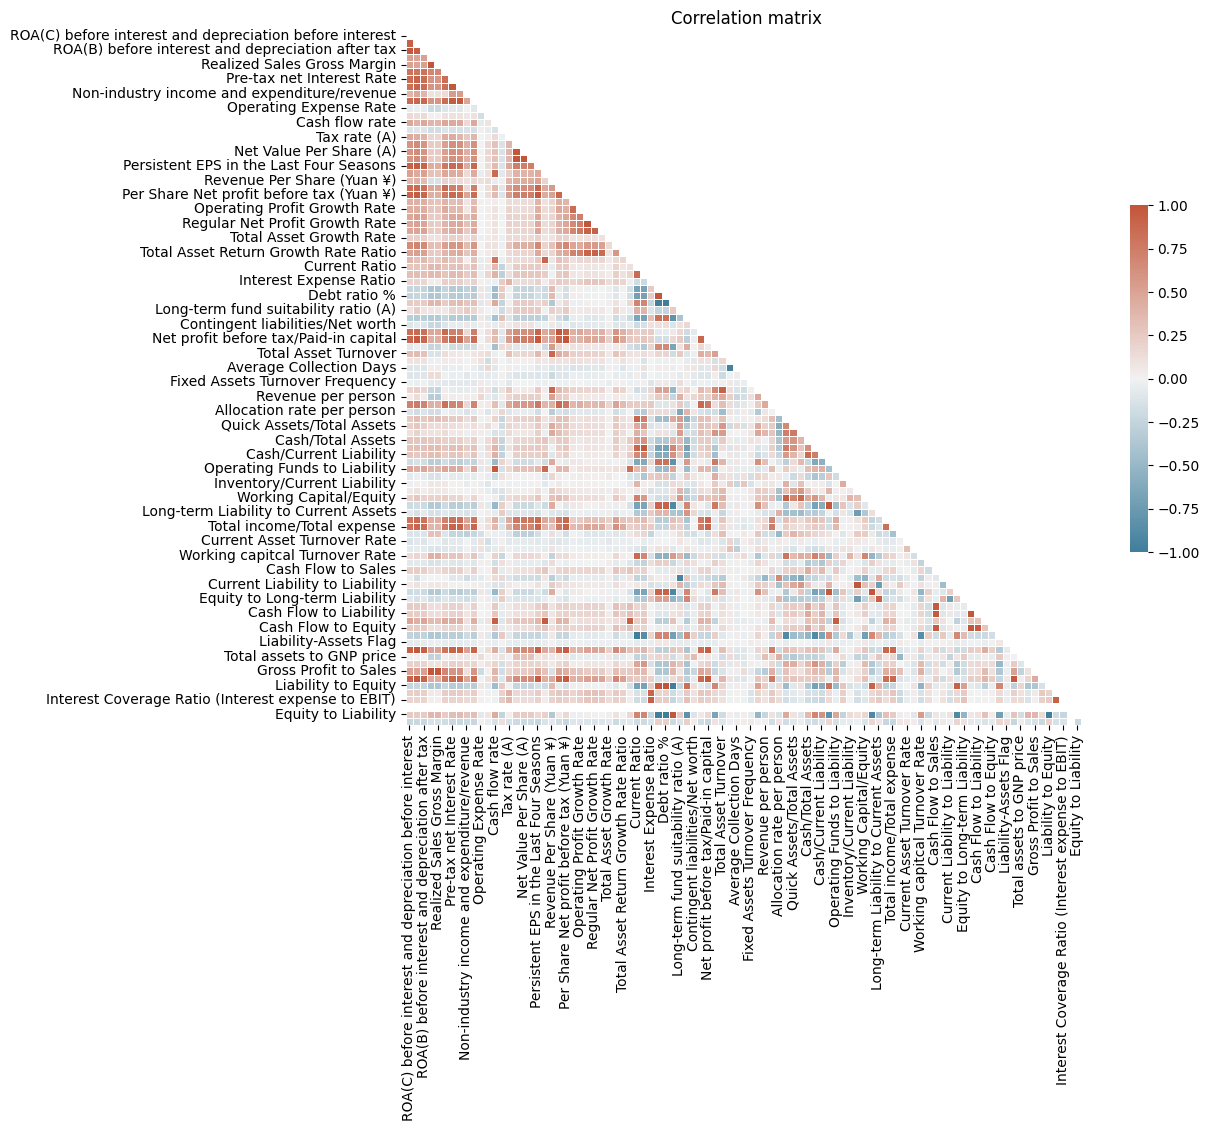

In [ ]:
taiwan_corr = calculate_correlation(taiwanese_bankruptcy_train, 'spearman')

In [ ]:
abs(taiwan_corr['Target']).sort_values(ascending=False)

Target                                      1.000000
Persistent EPS in the Last Four Seasons     0.237251
Net Income to Total Assets                  0.234639
Net profit before tax/Paid-in capital       0.232964
Per Share Net profit before tax (Yuan ¥)    0.232289
                                              ...   
Cash Turnover Rate                          0.016342
Operating Expense Rate                      0.015004
Revenue per person                          0.014447
Net Worth Turnover Rate (times)             0.004070
Net Income Flag                                  NaN
Name: Target, Length: 96, dtype: float64

df columns:  Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

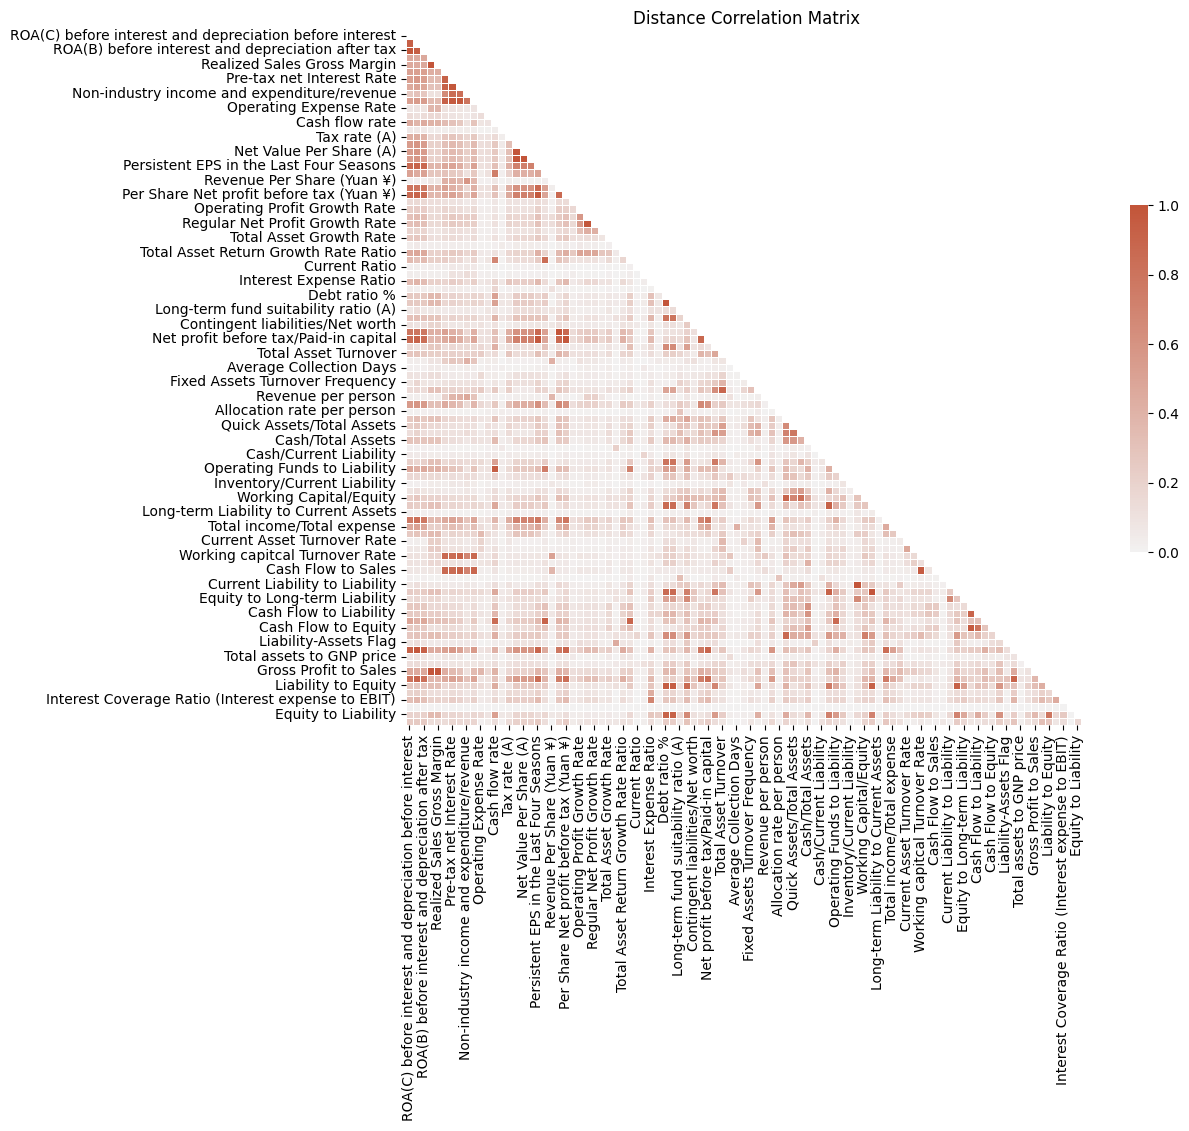

In [ ]:
taiwan_dist_corr = calculate_distance_correlation_matrix(taiwanese_bankruptcy_train)

In [ ]:
taiwan_dist_corr['Target'].sort_values(ascending=False)

Target                                1.000000
Net Income to Stockholder's Equity    0.326439
Borrowing dependency                  0.293049
Net Income to Total Assets            0.284681
Retained Earnings to Total Assets     0.272502
                                        ...   
Inventory/Current Liability           0.005592
Revenue Per Share (Yuan ¥)            0.004946
Quick Assets/Current Liability        0.004280
Current Ratio                         0.002472
Net Income Flag                       0.000000
Name: Target, Length: 96, dtype: float64

# **Pre-feature selection**
Features with zero-variance will be dropped. The code gives the option for additional removal of extremely weak correlation with the target variable. Nonetheless we will not be using it given that we have non-linear models being tested.

In [ ]:
# Drop columns with zero variance or weak correlation
DROP_WEAK_FEATURES = False
WEAK_THRESHOLD = 0.01

taiwan_zero_variance_columns = identify_zero_variance_columns(taiwanese_bankruptcy_train)

if DROP_WEAK_FEATURES:
  taiwan_weak_features = identify_weak_associated_features(
      taiwan_dist_corr, "Target", WEAK_THRESHOLD
  )
else:
  taiwan_weak_features = []

remove_columns = set(taiwan_zero_variance_columns + taiwan_weak_features)
print(remove_columns)

taiwanese_bankruptcy_train = taiwanese_bankruptcy_train.drop(columns=remove_columns)
taiwanese_bankruptcy_test = taiwanese_bankruptcy_test.drop(columns=remove_columns)

Variance of each column:
ROA(C) before interest and depreciation before interest    0.003672
ROA(A) before interest and % after tax                     0.004242
ROA(B) before interest and depreciation after tax          0.003769
Operating Gross Margin                                     0.000323
Realized Sales Gross Margin                                0.000322
                                                             ...   
Degree of Financial Leverage (DFL)                         0.000266
Interest Coverage Ratio (Interest expense to EBIT)         0.000183
Net Income Flag                                            0.000000
Equity to Liability                                        0.002324
Target                                                     0.031229
Length: 96, dtype: float64
Columns with zero variance to be dropped:
['Net Income Flag']
{'Net Income Flag'}


In [ ]:
print('Original number of features: ', len(taiwanese_bankruptcy.columns))
print('Number of features after pre-feature selection: ', len(taiwanese_bankruptcy_train.columns))

Original number of features:  96
Number of features after pre-feature selection:  95


# **Imbalanced dataset**

In [ ]:
X_train = taiwanese_bankruptcy_train.drop('Target', axis=1)
y_train = taiwanese_bankruptcy_train['Target']

X_test = taiwanese_bankruptcy_test.drop('Target', axis=1)
y_test = taiwanese_bankruptcy_test['Target']

In [ ]:
target_counts = y_train.value_counts()
target_percentages = y_train.value_counts(normalize=True)

df_target_stats = pd.DataFrame({'Count': target_counts, 'Percentage': target_percentages})
df_target_stats

Count  Percentage
Target                   
0.0      5279    0.967736
1.0       176    0.032264

Class imbalance will be addressed directly in the models by using class_weight='balanced' or scale_pos_weight = # majority class / # minority class

# **Models optimized for F1-score**

**Usage of feature permutation importance** Instead of calculating the feature importance because  permutation importance is less biased and reflects better the final goal of this use-case which is to measure the capacity of other variables replace the missing one.

**F1-score and Balanced Accuracy as performance metrics:** All the models in this section are trained using F1-score. In the next section, it will be used the Balanced Accuracy. These metrics were selected over the remaining ones because they:
- provide a more holistic view of the performance by considering precision and recall at the same time
- are more resilient to imbalanced datasets
- are among the preferred on several industries like Financial Services where the accuracy it is not enough per se.

**Missing values imputation with median (continuous variables) and mode (categorical variables):**
- simple missing value imputation technique to overcome the fact of some models implementation not handlung missing values natively and with this level up all the models with the same conditions
- median was used instead of the mean because it is more resilient to outliers and guarantees that the imputed value is part of the domain of the variable and in the case of binary variables median and mode coincide

In [ ]:
taiwan_imputation_values_dict = calculate_imputation_values_for_missing(taiwanese_bankruptcy_train)
taiwan_imputation_values_dict

{'ROA(C) before interest and depreciation before interest': 0.502705601325988,
 'ROA(A) before interest and % after tax': 0.559692542520715,
 'ROA(B) before interest and depreciation after tax': 0.552224423148991,
 'Operating Gross Margin': 0.605997492036495,
 'Realized Sales Gross Margin': 0.605983078453134,
 'Operating Profit Rate': 0.999021892732888,
 'Pre-tax net Interest Rate': 0.797463472237766,
 'After-tax net Interest Rate': 0.809375068353608,
 'Non-industry income and expenditure/revenue': 0.303525734529034,
 'Continuous interest rate (after tax)': 0.781634255356715,
 'Operating Expense Rate': 0.0002789152233015,
 'Research and development expense rate': 543000000.0,
 'Cash flow rate': 0.465049529033827,
 'Interest-bearing debt interest rate': 0.0003190319031903,
 'Tax rate (A)': 0.0740965684785909,
 'Net Value Per Share (B)': 0.184273734777296,
 'Net Value Per Share (A)': 0.184273734777296,
 'Net Value Per Share (C)': 0.18435801272597,
 'Persistent EPS in the Last Four Season

In [ ]:
taiwan_cat_vars = [col for col in X_train.columns if X_train[col].nunique() <= 2]
taiwan_cat_vars

['Liability-Assets Flag']

##**Decision tree**

**Cross-validation (3,3) for large datasets and (5,5) for smaller datasets:**
- due to the unpractical runtime of some of the models, the cross-validaton set up on large datasets consists in a nested-cv with 3-fold in both inner and outer CV. The number of folds is increased to (5,5) in smaller datsets.
- this assumption is reasonable given that in larger datasets there is a higher chance of the holdout samples being big enough to be more representative and less prone to biases. So a smaller number of folds can be assummed
- on the other hand, in smaller datasets it is crucial to reduce the variance and any potential misrepresentativeness of a specific validation set, so it is requires a larger number of folds to make a more efficient use of the data available.

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],  # last option reflects num of samples instead of proportion
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]  # last option reflects num of samples instead of proportion
  }
else:
  # best model
  dt_param_grid = {
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt_grid_search, dt_best_model, dt_best_params = hyperparameter_tuning(
    dt_classifier, dt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 15:45:54.732207

Nested Cross-validation Results:
Individual scores: [0.28213166 0.32258065 0.30901288]
Average nested CV score: 0.305 (+/- 0.034)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Model Performance:
Best CV score: 0.305
2025-01-16 15:45:58.620943

Execution time: 0.06 minutes




```
Starting hyperparameter tuning at: 2025-01-15 18:36:09.292088

Nested Cross-validation Results:
Individual scores: [0.28660436 0.3        0.24647887]
Average nested CV score: 0.278 (+/- 0.045)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Model Performance:
Best CV score: 0.305
2025-01-15 18:36:53.210342

Execution time: 0.73 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt_classifier, dt_train_pred, dt_test_pred = apply_model(dt_best_model, X_train, y_train, X_test, y_test)
dt_feat_permut_import_df = analyze_feat_permut_import(dt_classifier, X_train, y_train, scoring_metric="f1")
dt_feat_permut_import_df[dt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
18      Persistent EPS in the Last Four Seasons    0.168925  0.011566
33                                  Quick Ratio    0.115630  0.006970
35                   Total debt/Total net worth    0.079802  0.012594
61                    Inventory/Working Capital    0.031341  0.003590
8   Non-industry income and expenditure/revenue    0.029875  0.005790
34                       Interest Expense Ratio    0.022143  0.004066
70                  Current Asset Turnover Rate    0.020918  0.001707
62                  Inventory/Current Liability    0.018407  0.003035
29                        Net Value Growth Rate    0.011035  0.002261
5                         Operating Profit Rate    0.010255  0.004077
63                Current Liabilities/Liability    0.010152  0.001805
12                               Cash flow rate    0.009315  0.003803
19                          Cash Flow Per Share    0.008448  0.000953
53              Working Capital to Total Assets    0.005938  0.002592
67            Retained Earnings to Total Assets    0.003913  0.002271
43  Inventory and accounts receivable/Net value    0.003559  0.000632
46                      Average Collection Days    0.002238  0.000956
17                      Net Value Per Share (C)    0.001870  0.002033
73                           Cash Turnover Rate    0.001087  0.001004

**Note:** feature permutation importance values do not sum up to 100% because they represent the drop in model performance when each feature is permuted, and they are not normalized.

Values can be negative if permuting an unimportant feature improves model performance.

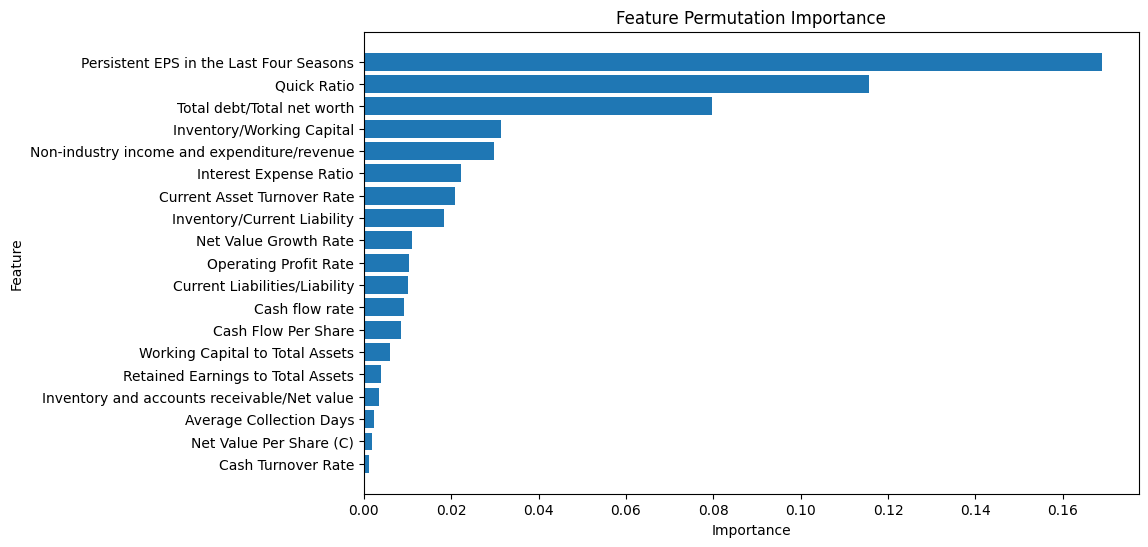

In [ ]:
plot_feat_permut_importance(dt_feat_permut_import_df)

In [ ]:
dt_perf, dt_orig_missing, dt_missing = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    taiwan_imputation_values_dict, 20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Quick Ratio', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Inventory/Working Capital
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Quick Ratio', 'Total debt/Total net worth', 'Inventory/Working Capital']

--- NEW ITERATION ---
Removing feature:  Non-industry income and expenditure/revenue
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Quick Ratio', 'Total debt/Total net worth', 'Inventory/Working Capital', 'Non-industry income and expenditure/revenue']

--- NEW IT

In [ ]:
dt_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   32  1203  117  12      21.48   72.73        91.14     90.54     33.16   
1    8  1256   64  36      11.11   18.18        95.15     92.67     13.79   
2    8  1256   64  36      11.11   18.18        95.15     92.67     13.79   
3    8  1256   64  36      11.11   18.18        95.15     92.67     13.79   
4    8  1262   58  36      12.12   18.18        95.61     93.11     14.55   
5    8  1291   29  36      21.62   18.18        97.80     95.23     19.75   
6    5  1310   10  39      33.33   11.36        99.24     96.41     16.95   
7    5  1310   10  39      33.33   11.36        99.24     96.41     16.95   
8    5  1310   10  39      33.33   11.36        99.24     96.41     16.95   
9    0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
10   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
11   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
12   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
13   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
14   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
15   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
16   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
17   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
18   0  1318    2  44       0.00    0.00        99.85     96.63      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               81.93                 0   
1               56.67                 1   
2               56.67                 2   
3               56.67                 3   
4               56.89                 4   
5               57.99                 5   
6               55.30                 6   
7               55.30                 7   
8               55.30                 8   
9               49.92                 9   
10              49.92                10   
11              49.92                11   
12              49.92                12   
13              49.92                13   
14              49.92                14   
15              49.92                15   
16              49.92                16   
17              49.92                17   
18              49.92                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'Q...  
3   ['Persistent EPS in the Last Four Seasons', 'Q...  
4   ['Persistent EPS in the Last Four Seasons', 'Q...  
5   ['Persistent EPS in the Last Four Seasons', 'Q...  
6   ['Persistent EPS in the Last Four Seasons', 'Q...  
7   ['Persistent EPS in the Last Four Seasons', 'Q...  
8   ['Persistent EPS in the Last Four Seasons', 'Q...  
9   ['Persistent EPS in the Last Four Seasons', 'Q...  
10  ['Persistent EPS in the Last Four Seasons', 'Q...  
11  ['Persistent EPS in the Last Four Seasons', 'Q...  
12  ['Persistent EPS in the Last Four Seasons', 'Q...  
13  ['Persistent EPS in the Last Four Seasons', 'Q...  
14  ['Persistent EPS in the Last Four Seasons', 'Q...  
15  ['Persistent EPS in the Last Four Seasons', 'Q...  
16  ['Persistent EPS in the Last Four Seasons', 'Q...  
17  ['Persistent EPS in the Last Four Seasons', 'Q...  
18  ['Persistent EPS in the Last Four Seasons', 'Q...  
19  ['Persistent EPS in the Last Four Seasons', 'Q...  
20  ['Persistent EPS in the Last Four Seasons', 'Q...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt_perf_mf, dt_orig_missing_mf, dt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt_classifier, dt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 15:46:01.354359

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit G

In [ ]:
dt_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   32  1203  117  12      21.48   72.73        91.14     90.54     33.16   
1   31  1197  123  13      20.13   70.45        90.68     90.03     31.31   
2   14  1236   84  30      14.29   31.82        93.64     91.64     19.72   
3   14  1233   87  30      13.86   31.82        93.41     91.42     19.31   
4   14  1231   89  30      13.59   31.82        93.26     91.28     19.05   
5   14  1234   86  30      14.00   31.82        93.48     91.50     19.44   
6   11  1246   74  33      12.94   25.00        94.39     92.16     17.05   
7   14  1238   82  30      14.58   31.82        93.79     91.79     20.00   
8   13  1227   93  31      12.26   29.55        92.95     90.91     17.33   
9   13  1232   88  31      12.87   29.55        93.33     91.28     17.93   
10  13  1229   91  31      12.50   29.55        93.11     91.06     17.57   
11  14  1225   95  30      12.84   31.82        92.80     90.84     18.30   
12  13  1224   96  31      11.93   29.55        92.73     90.69     16.99   
13  12  1229   91  32      11.65   27.27        93.11     90.98     16.33   
14  13  1236   84  31      13.40   29.55        93.64     91.57     18.44   
15  16  1227   93  28      14.68   36.36        92.95     91.13     20.92   
16  15  1224   96  29      13.51   34.09        92.73     90.84     19.35   
17  15  1226   94  29      13.76   34.09        92.88     90.98     19.61   
18  16  1229   91  28      14.95   36.36        93.11     91.28     21.19   
19  16  1225   95  28      14.41   36.36        92.80     90.98     20.65   
20  16  1225   95  28      14.41   36.36        92.80     90.98     20.65   

    balanced_accuracy  num_feat_missing  \
0               81.93                 0   
1               80.57                 1   
2               62.73                 2   
3               62.61                 3   
4               62.54                 4   
5               62.65                 5   
6               59.70                 6   
7               62.80                 7   
8               61.25                 8   
9               61.44                 9   
10              61.33                10   
11              62.31                11   
12              61.14                12   
13              60.19                13   
14              61.59                14   
15              64.66                15   
16              63.41                16   
17              63.48                17   
18              64.73                18   
19              64.58                19   
20              64.58                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'Q...  
3   ['Persistent EPS in the Last Four Seasons', 'Q...  
4   ['Persistent EPS in the Last Four Seasons', 'Q...  
5   ['Persistent EPS in the Last Four Seasons', 'Q...  
6   ['Persistent EPS in the Last Four Seasons', 'Q...  
7   ['Persistent EPS in the Last Four Seasons', 'Q...  
8   ['Persistent EPS in the Last Four Seasons', 'Q...  
9   ['Persistent EPS in the Last Four Seasons', 'Q...  
10  ['Persistent EPS in the Last Four Seasons', 'Q...  
11  ['Persistent EPS in the Last Four Seasons', 'Q...  
12  ['Persistent EPS in the Last Four Seasons', 'Q...  
13  ['Persistent EPS in the Last Four Seasons', 'Q...  
14  ['Persistent EPS in the Last Four Seasons', 'Q...  
15  ['Persistent EPS in the Last Four Seasons', 'Q...  
16  ['Persistent EPS in the Last Four Seasons', 'Q...  
17  ['Persistent EPS in the Last Four Seasons', 'Q...  
18  ['Persistent EPS in the Last Four Seasons', 'Q...  
19  ['Persistent EPS in the Last Four Seasons', 'Q...  
20  ['Persistent EPS in the Last Four Seasons', 'Q...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  #best model
  rf_param_grid = {
      'n_estimators': [200],
      'max_features': [0.5],
      'min_samples_split': [0.01],
      'min_samples_leaf': [0.005],
      'max_depth': [None]
  }

rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf_grid_search, rf_best_model, rf_best_params = hyperparameter_tuning(
    rf_classifier, rf_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:01:10.131460

Nested Cross-validation Results:
Individual scores: [0.47619048 0.45810056 0.42458101]
Average nested CV score: 0.453 (+/- 0.043)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.453
2025-01-16 16:02:15.223784

Execution time: 1.08 minutes




```
Starting hyperparameter tuning at: 2025-01-16 04:38:48.142874

Nested Cross-validation Results:
Individual scores: [0.47619048 0.44791667 0.42528736]
Average nested CV score: 0.450 (+/- 0.042)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 0.005, 'min_samples_split': 0.01, 'n_estimators': 200}

Best Model Performance:
Best CV score: 0.453
2025-01-16 06:10:37.964501

Execution time: 91.83 minutes
```



In [ ]:
# rf_grid_search.cv_results_

In [ ]:
rf_classifier, rf_train_pred, rf_test_pred = apply_model(rf_best_model, X_train, y_train, X_test, y_test)
rf_feat_permut_import_df = analyze_feat_permut_import(rf_classifier, X_train, y_train, scoring_metric="f1")
rf_feat_permut_import_df[rf_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
34                   Interest Expense Ratio    0.017911  0.002676
52               Allocation rate per person    0.011695  0.001239
73                       Cash Turnover Rate    0.006947  0.001797
13      Interest-bearing debt interest rate    0.006621  0.003009
24             Operating Profit Growth Rate    0.005839  0.000968
..                                      ...         ...       ...
85               Net Income to Total Assets   -0.027381  0.004090
37                         Net worth/Assets   -0.031491  0.003279
18  Persistent EPS in the Last Four Seasons   -0.035094  0.003890
35               Total debt/Total net worth   -0.037262  0.009422
9      Continuous interest rate (after tax)   -0.040752  0.003493

[92 rows x 3 columns]

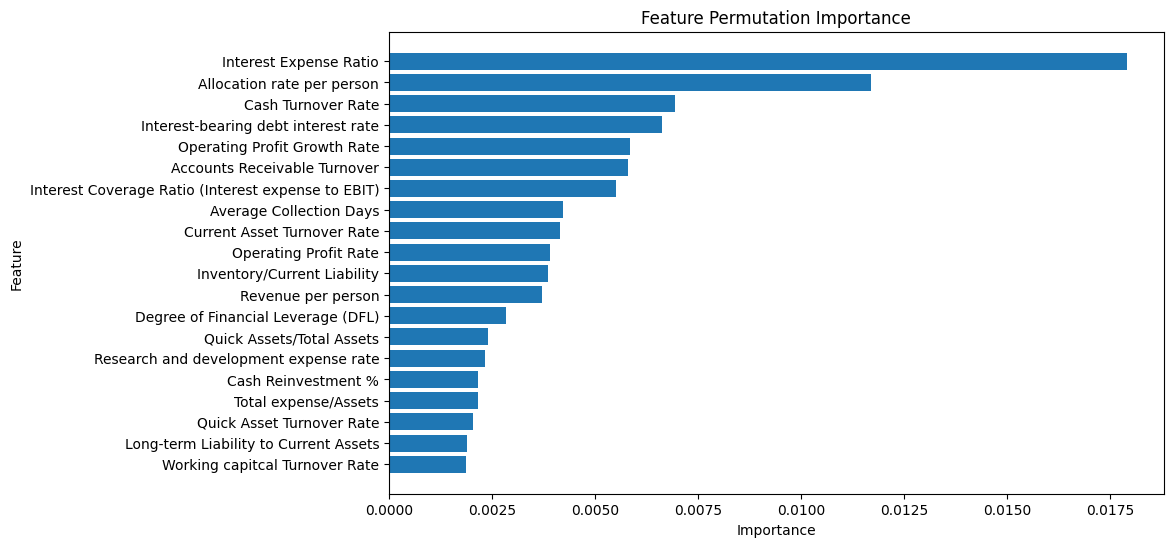

In [ ]:
plot_feat_permut_importance(rf_feat_permut_import_df)

In [ ]:
rf_perf, rf_orig_missing, rf_missing = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Allocation rate per person
Original feat removed so far:  ['Interest Expense Ratio', 'Allocation rate per person']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Interest Expense Ratio', 'Allocation rate per person', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest Expense Ratio', 'Allocation rate per person', 'Cash Turnover Rate', 'Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Operating Profit Growth Rate
Original feat removed so far:  ['Interest Expense Ratio', 'Allocation rate per person', 'Cash Turnover Rate', 'Interest-bearing debt interest rate', 'Operating Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover

In [ ]:
rf_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   33  1243  77  11      30.00   75.00        94.17     93.55     42.86   
1   33  1247  73  11      31.13   75.00        94.47     93.84     44.00   
2   32  1246  74  12      30.19   72.73        94.39     93.70     42.67   
3   33  1246  74  11      30.84   75.00        94.39     93.77     43.71   
4   29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
5   30  1244  76  14      28.30   68.18        94.24     93.40     40.00   
6   30  1244  76  14      28.30   68.18        94.24     93.40     40.00   
7   29  1244  76  15      27.62   65.91        94.24     93.33     38.93   
8   29  1244  76  15      27.62   65.91        94.24     93.33     38.93   
9   29  1245  75  15      27.88   65.91        94.32     93.40     39.19   
10  29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
11  29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
12  29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
13  29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
14  29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
15  29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
16  29  1247  73  15      28.43   65.91        94.47     93.55     39.73   
17  29  1247  73  15      28.43   65.91        94.47     93.55     39.73   
18  29  1248  72  15      28.71   65.91        94.55     93.62     40.00   
19  29  1248  72  15      28.71   65.91        94.55     93.62     40.00   
20  29  1248  72  15      28.71   65.91        94.55     93.62     40.00   

    balanced_accuracy  num_feat_missing  \
0               84.58                 0   
1               84.73                 1   
2               83.56                 2   
3               84.70                 3   
4               80.15                 4   
5               81.21                 5   
6               81.21                 6   
7               80.08                 7   
8               80.08                 8   
9               80.11                 9   
10              80.15                10   
11              80.15                11   
12              80.15                12   
13              80.15                13   
14              80.15                14   
15              80.15                15   
16              80.19                16   
17              80.19                17   
18              80.23                18   
19              80.23                19   
20              80.23                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Allocation rate pe...  
3   ['Interest Expense Ratio', 'Allocation rate pe...  
4   ['Interest Expense Ratio', 'Allocation rate pe...  
5   ['Interest Expense Ratio', 'Allocation rate pe...  
6   ['Interest Expense Ratio', 'Allocation rate pe...  
7   ['Interest Expense Ratio', 'Allocation rate pe...  
8   ['Interest Expense Ratio', 'Allocation rate pe...  
9   ['Interest Expense Ratio', 'Allocation rate pe...  
10  ['Interest Expense Ratio', 'Allocation rate pe...  
11  ['Interest Expense Ratio', 'Allocation rate pe...  
12  ['Interest Expense Ratio', 'Allocation rate pe...  
13  ['Interest Expense Ratio', 'Allocation rate pe...  
14  ['Interest Expense Ratio', 'Allocation rate pe...  
15  ['Interest Expense Ratio', 'Allocation rate pe...  
16  ['Interest Expense Ratio', 'Allocation rate pe...  
17  ['Interest Expense Ratio', 'Allocation rate pe...  
18  ['Interest Expense Ratio', 'Allocation rate pe...  
19  ['Interest Expense Ratio', 'Allocation rate pe...  
20  ['Interest Expense Ratio', 'Allocation rate pe...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf_perf_mf, rf_orig_missing_mf, rf_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf_classifier, rf_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:02:45.853058

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'Aft

In [ ]:
rf_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   33  1243  77  11      30.00   75.00        94.17     93.55     42.86   
1   33  1243  77  11      30.00   75.00        94.17     93.55     42.86   
2   34  1243  77  10      30.63   77.27        94.17     93.62     43.87   
3   33  1245  75  11      30.56   75.00        94.32     93.70     43.42   
4   34  1241  79  10      30.09   77.27        94.02     93.48     43.31   
5   34  1241  79  10      30.09   77.27        94.02     93.48     43.31   
6   34  1241  79  10      30.09   77.27        94.02     93.48     43.31   
7   34  1242  78  10      30.36   77.27        94.09     93.55     43.59   
8   34  1242  78  10      30.36   77.27        94.09     93.55     43.59   
9   34  1243  77  10      30.63   77.27        94.17     93.62     43.87   
10  34  1243  77  10      30.63   77.27        94.17     93.62     43.87   
11  34  1243  77  10      30.63   77.27        94.17     93.62     43.87   
12  34  1243  77  10      30.63   77.27        94.17     93.62     43.87   
13  34  1243  77  10      30.63   77.27        94.17     93.62     43.87   
14  34  1244  76  10      30.91   77.27        94.24     93.70     44.16   
15  33  1244  76  11      30.28   75.00        94.24     93.62     43.14   
16  33  1244  76  11      30.28   75.00        94.24     93.62     43.14   
17  33  1242  78  11      29.73   75.00        94.09     93.48     42.58   
18  34  1241  79  10      30.09   77.27        94.02     93.48     43.31   
19  33  1240  80  11      29.20   75.00        93.94     93.33     42.04   
20  34  1240  80  10      29.82   77.27        93.94     93.40     43.04   

    balanced_accuracy  num_feat_missing  \
0               84.58                 0   
1               84.58                 1   
2               85.72                 2   
3               84.66                 3   
4               85.64                 4   
5               85.64                 5   
6               85.64                 6   
7               85.68                 7   
8               85.68                 8   
9               85.72                 9   
10              85.72                10   
11              85.72                11   
12              85.72                12   
13              85.72                13   
14              85.76                14   
15              84.62                15   
16              84.62                16   
17              84.55                17   
18              85.64                18   
19              84.47                19   
20              85.61                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Allocation rate pe...  
3   ['Interest Expense Ratio', 'Allocation rate pe...  
4   ['Interest Expense Ratio', 'Allocation rate pe...  
5   ['Interest Expense Ratio', 'Allocation rate pe...  
6   ['Interest Expense Ratio', 'Allocation rate pe...  
7   ['Interest Expense Ratio', 'Allocation rate pe...  
8   ['Interest Expense Ratio', 'Allocation rate pe...  
9   ['Interest Expense Ratio', 'Allocation rate pe...  
10  ['Interest Expense Ratio', 'Allocation rate pe...  
11  ['Interest Expense Ratio', 'Allocation rate pe...  
12  ['Interest Expense Ratio', 'Allocation rate pe...  
13  ['Interest Expense Ratio', 'Allocation rate pe...  
14  ['Interest Expense Ratio', 'Allocation rate pe...  
15  ['Interest Expense Ratio', 'Allocation rate pe...  
16  ['Interest Expense Ratio', 'Allocation rate pe...  
17  ['Interest Expense Ratio', 'Allocation rate pe...  
18  ['Interest Expense Ratio', 'Allocation rate pe...  
19  ['Interest Expense Ratio', 'Allocation rate pe...  
20  ['Interest Expense Ratio', 'Allocation rate pe...

##**Gradient-Boosted Trees**

Instead of class_weight='balanced', GBT and XGBoost recommends the use of scale_pos_weight = # majority class samples / # minority class samples

- https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
# scale_pos_weight value
ratio_majority_minority = y_train[y_train==0].count()/y_train[y_train==1].count()
ratio_majority_minority

29.994318181818183

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt_param_grid = {
      'n_estimators': [100],
      'max_depth': [4],
      'min_child_samples': [1],
      'min_split_gain': [1.0],
      'reg_lambda': [5.0]
  }

gbt_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt_grid_search, gbt_best_model, gbt_best_params = hyperparameter_tuning(
    gbt_classifier, gbt_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:17:42.542131

Nested Cross-validation Results:
Individual scores: [0.546875   0.52631579 0.42962963]
Average nested CV score: 0.501 (+/- 0.102)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.501
2025-01-16 16:17:49.453932

Execution time: 0.12 minutes



```
Starting hyperparameter tuning at: 2025-01-13 02:45:25.425769

Nested Cross-validation Results:
Individual scores: [0.48571429 0.46357616 0.49655172]
Average nested CV score: 0.482 (+/- 0.027)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': None, 'min_child_samples': 15, 'min_split_gain': 0.5, 'n_estimators': 100, 'reg_lambda': 0.5}

Best Model Performance:
Best CV score: 0.502
2025-01-13 02:54:28.499933

Execution time: 9.05 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 18:36:53.235698

Nested Cross-validation Results:
Individual scores: [0.512      0.41618497 0.41221374]
Average nested CV score: 0.447 (+/- 0.092)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 4, 'min_child_samples': 1, 'min_split_gain': 1, 'n_estimators': 100, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.501
2025-01-15 18:46:50.038359

Execution time: 9.95 minutes
```



In [ ]:
gbt_classifier, gbt_train_pred, gbt_test_pred = apply_model(gbt_best_model, X_train, y_train, X_test, y_test)
gbt_feat_permut_import_df = analyze_feat_permut_import(gbt_classifier, X_train, y_train, scoring_metric="f1")
gbt_feat_permut_import_df[gbt_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
58                             Cash/Current Liability    0.056198  0.007330
50                                 Revenue per person    0.031038  0.004026
68                         Total income/Total expense    0.010001  0.003193
5                               Operating Profit Rate    0.009641  0.002144
20                         Revenue Per Share (Yuan ¥)    0.009265  0.003476
..                                                ...         ...       ...
39                               Borrowing dependency   -0.045785  0.006297
36                                       Debt ratio %   -0.050290  0.006918
33                                        Quick Ratio   -0.054891  0.006408
18            Persistent EPS in the Last Four Seasons   -0.068823  0.001842
2   ROA(B) before interest and depreciation after tax   -0.078707  0.006636

[85 rows x 3 columns]

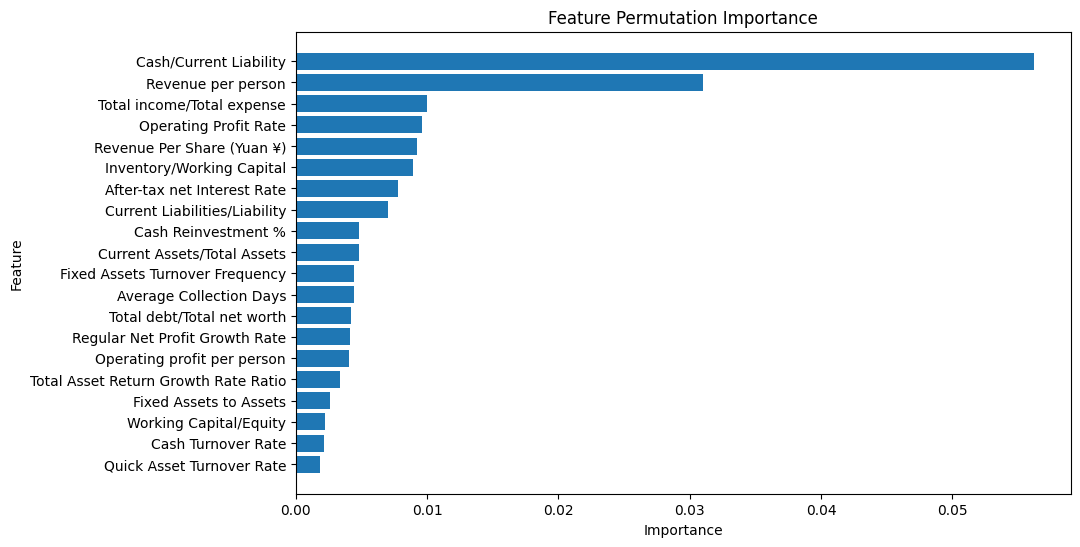

In [ ]:
plot_feat_permut_importance(gbt_feat_permut_import_df)

In [ ]:
gbt_perf, gbt_orig_missing, gbt_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Total income/Total expense
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person', 'Total income/Total expense']

--- NEW ITERATION ---
Removing feature:  Operating Profit Rate
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person', 'Total income/Total expense', 'Operating Profit Rate']

--- NEW ITERATION ---
Removing feature:  Revenue Per Share (Yuan ¥)
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person', 'Total income/Total expense', 'Operating Profit Rate', 'Revenue Per Share (Yuan ¥)']

--- NEW ITERATION ---
Removing feature:  Inventory/Working Capital
Original feat removed so far:  ['Cash/Current Liability'

In [ ]:
gbt_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   25  1271  49  19      33.78   56.82        96.29     95.01     42.37   
1   27  1261  59  17      31.40   61.36        95.53     94.43     41.54   
2   27  1258  62  17      30.34   61.36        95.30     94.21     40.60   
3   29  1254  66  15      30.53   65.91        95.00     94.06     41.73   
4   29  1252  68  15      29.90   65.91        94.85     93.91     41.13   
5   30  1249  71  14      29.70   68.18        94.62     93.77     41.38   
6   29  1245  75  15      27.88   65.91        94.32     93.40     39.19   
7   29  1242  78  15      27.10   65.91        94.09     93.18     38.41   
8   30  1242  78  14      27.78   68.18        94.09     93.26     39.47   
9   30  1240  80  14      27.27   68.18        93.94     93.11     38.96   
10  29  1243  77  15      27.36   65.91        94.17     93.26     38.67   
11  29  1246  74  15      28.16   65.91        94.39     93.48     39.46   
12  27  1246  74  17      26.73   61.36        94.39     93.33     37.24   
13  25  1264  56  19      30.86   56.82        95.76     94.50     40.00   
14  27  1263  57  17      32.14   61.36        95.68     94.57     42.19   
15  27  1266  54  17      33.33   61.36        95.91     94.79     43.20   
16  27  1264  56  17      32.53   61.36        95.76     94.65     42.52   
17  26  1272  48  18      35.14   59.09        96.36     95.16     44.07   
18  27  1268  52  17      34.18   61.36        96.06     94.94     43.90   
19  29  1241  79  15      26.85   65.91        94.02     93.11     38.16   
20  29  1243  77  15      27.36   65.91        94.17     93.26     38.67   

    balanced_accuracy  num_feat_missing  \
0               76.55                 0   
1               78.45                 1   
2               78.33                 2   
3               80.45                 3   
4               80.38                 4   
5               81.40                 5   
6               80.11                 6   
7               80.00                 7   
8               81.14                 8   
9               81.06                 9   
10              80.04                10   
11              80.15                11   
12              77.88                12   
13              76.29                13   
14              78.52                14   
15              78.64                15   
16              78.56                16   
17              77.73                17   
18              78.71                18   
19              79.96                19   
20              80.04                20   

                                              imputed  
0                                                      
1                  ['Cash/Current Liability'] imputed  
2   ['Cash/Current Liability', 'Revenue per person...  
3   ['Cash/Current Liability', 'Revenue per person...  
4   ['Cash/Current Liability', 'Revenue per person...  
5   ['Cash/Current Liability', 'Revenue per person...  
6   ['Cash/Current Liability', 'Revenue per person...  
7   ['Cash/Current Liability', 'Revenue per person...  
8   ['Cash/Current Liability', 'Revenue per person...  
9   ['Cash/Current Liability', 'Revenue per person...  
10  ['Cash/Current Liability', 'Revenue per person...  
11  ['Cash/Current Liability', 'Revenue per person...  
12  ['Cash/Current Liability', 'Revenue per person...  
13  ['Cash/Current Liability', 'Revenue per person...  
14  ['Cash/Current Liability', 'Revenue per person...  
15  ['Cash/Current Liability', 'Revenue per person...  
16  ['Cash/Current Liability', 'Revenue per person...  
17  ['Cash/Current Liability', 'Revenue per person...  
18  ['Cash/Current Liability', 'Revenue per person...  
19  ['Cash/Current Liability', 'Revenue per person...  
20  ['Cash/Current Liability', 'Revenue per person...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt_perf_mf, gbt_orig_missing_mf, gbt_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt_classifier, gbt_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:17:55.473159

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'Aft

In [ ]:
gbt_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   25  1271  49  19      33.78   56.82        96.29     95.01     42.37   
1   26  1262  58  18      30.95   59.09        95.61     94.43     40.62   
2   26  1260  60  18      30.23   59.09        95.45     94.28     40.00   
3   27  1259  61  17      30.68   61.36        95.38     94.28     40.91   
4   27  1260  60  17      31.03   61.36        95.45     94.35     41.22   
5   28  1259  61  16      31.46   63.64        95.38     94.35     42.11   
6   28  1258  62  16      31.11   63.64        95.30     94.28     41.79   
7   28  1257  63  16      30.77   63.64        95.23     94.21     41.48   
8   28  1253  67  16      29.47   63.64        94.92     93.91     40.29   
9   28  1251  69  16      28.87   63.64        94.77     93.77     39.72   
10  28  1250  70  16      28.57   63.64        94.70     93.70     39.44   
11  28  1250  70  16      28.57   63.64        94.70     93.70     39.44   
12  28  1251  69  16      28.87   63.64        94.77     93.77     39.72   
13  27  1249  71  17      27.55   61.36        94.62     93.55     38.03   
14  28  1251  69  16      28.87   63.64        94.77     93.77     39.72   
15  27  1250  70  17      27.84   61.36        94.70     93.62     38.30   
16  27  1251  69  17      28.12   61.36        94.77     93.70     38.57   
17  28  1250  70  16      28.57   63.64        94.70     93.70     39.44   
18  27  1248  72  17      27.27   61.36        94.55     93.48     37.76   
19  27  1249  71  17      27.55   61.36        94.62     93.55     38.03   
20  27  1249  71  17      27.55   61.36        94.62     93.55     38.03   

    balanced_accuracy  num_feat_missing  \
0               76.55                 0   
1               77.35                 1   
2               77.27                 2   
3               78.37                 3   
4               78.41                 4   
5               79.51                 5   
6               79.47                 6   
7               79.43                 7   
8               79.28                 8   
9               79.20                 9   
10              79.17                10   
11              79.17                11   
12              79.20                12   
13              77.99                13   
14              79.20                14   
15              78.03                15   
16              78.07                16   
17              79.17                17   
18              77.95                18   
19              77.99                19   
20              77.99                20   

                                              imputed  
0                                                      
1                  ['Cash/Current Liability'] imputed  
2   ['Cash/Current Liability', 'Revenue per person...  
3   ['Cash/Current Liability', 'Revenue per person...  
4   ['Cash/Current Liability', 'Revenue per person...  
5   ['Cash/Current Liability', 'Revenue per person...  
6   ['Cash/Current Liability', 'Revenue per person...  
7   ['Cash/Current Liability', 'Revenue per person...  
8   ['Cash/Current Liability', 'Revenue per person...  
9   ['Cash/Current Liability', 'Revenue per person...  
10  ['Cash/Current Liability', 'Revenue per person...  
11  ['Cash/Current Liability', 'Revenue per person...  
12  ['Cash/Current Liability', 'Revenue per person...  
13  ['Cash/Current Liability', 'Revenue per person...  
14  ['Cash/Current Liability', 'Revenue per person...  
15  ['Cash/Current Liability', 'Revenue per person...  
16  ['Cash/Current Liability', 'Revenue per person...  
17  ['Cash/Current Liability', 'Revenue per person...  
18  ['Cash/Current Liability', 'Revenue per person...  
19  ['Cash/Current Liability', 'Revenue per person...  
20  ['Cash/Current Liability', 'Revenue per person...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0.0],   # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  xgb_param_grid = {
      'n_estimators': [100],
      'max_depth': [3],
      'reg_lambda':[10.0],
      'gamma': [0.5],
      'colsample_bytree':[0.25]
  }

xgb_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE
)
xgb_grid_search, xgb_best_model, xgb_best_params = hyperparameter_tuning(
    xgb_classifier, xgb_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:32:49.765221

Nested Cross-validation Results:
Individual scores: [0.48695652 0.52238806 0.48062016]
Average nested CV score: 0.497 (+/- 0.037)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.5, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.497
2025-01-16 16:32:55.162572

Execution time: 0.09 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:01:40.431570

Nested Cross-validation Results:
Individual scores: [0.40449438 0.35443038 0.38202247]
Average nested CV score: 0.380 (+/- 0.041)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.444
2025-01-13 02:23:36.824783

Execution time: 21.94 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 18:46:50.048116

Nested Cross-validation Results:
Individual scores: [0.50434783 0.47222222 0.39285714]
Average nested CV score: 0.456 (+/- 0.094)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 0.5, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.497
2025-01-15 19:12:53.165486

Execution time: 26.05 minutes
```

In [ ]:
xgb_classifier, xgb_train_pred, xgb_test_pred = apply_model(xgb_best_model, X_train, y_train, X_test, y_test)
xgb_feat_permut_import_df = analyze_feat_permut_import(xgb_classifier, X_train, y_train, scoring_metric="f1")
xgb_feat_permut_import_df[xgb_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
58                             Cash/Current Liability    0.045871  0.002525
50                                 Revenue per person    0.039695  0.005806
24                       Operating Profit Growth Rate    0.017456  0.005258
42              Net profit before tax/Paid-in capital    0.017080  0.000816
26                     Regular Net Profit Growth Rate    0.011729  0.002798
..                                                ...         ...       ...
33                                        Quick Ratio   -0.043775  0.004080
85                         Net Income to Total Assets   -0.051350  0.004838
39                               Borrowing dependency   -0.051814  0.003376
35                         Total debt/Total net worth   -0.051859  0.007234
0   ROA(C) before interest and depreciation before...   -0.061540  0.009091

[91 rows x 3 columns]

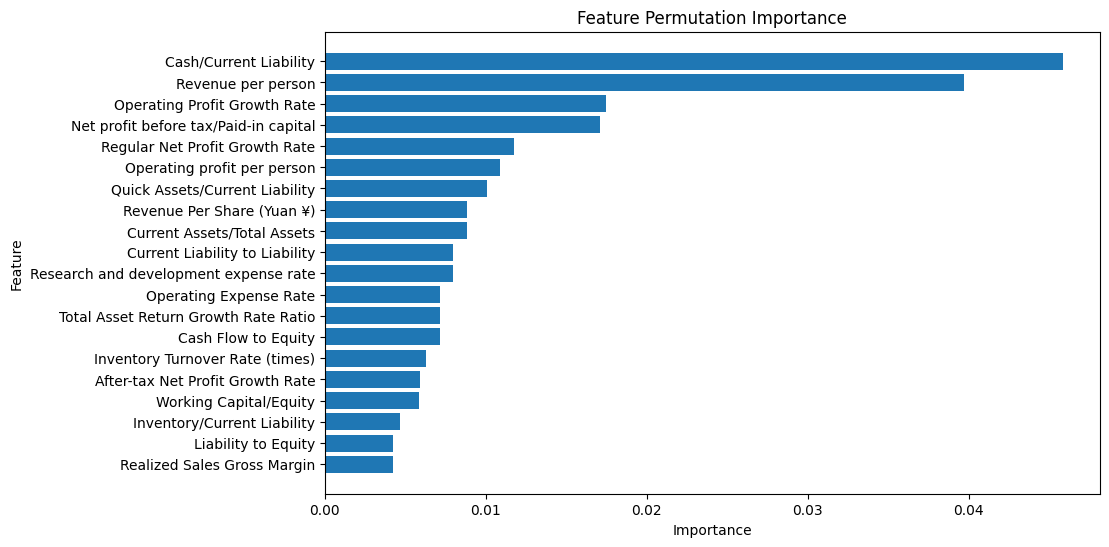

In [ ]:
plot_feat_permut_importance(xgb_feat_permut_import_df)

In [ ]:
xgb_perf, xgb_orig_missing, xgb_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Revenue per person
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person']

--- NEW ITERATION ---
Removing feature:  Operating Profit Growth Rate
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person', 'Operating Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Net profit before tax/Paid-in capital
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person', 'Operating Profit Growth Rate', 'Net profit before tax/Paid-in capital']

--- NEW ITERATION ---
Removing feature:  Regular Net Profit Growth Rate
Original feat removed so far:  ['Cash/Current Liability', 'Revenue per person', 'Operating Profit Growth Rate', 'Net profit before tax/Paid-in capital', 'Regular Net Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Operating profit p

In [ ]:
xgb_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1277  43  21      34.85   52.27        96.74     95.31     41.82   
1   26  1270  50  18      34.21   59.09        96.21     95.01     43.33   
2   25  1270  50  19      33.33   56.82        96.21     94.94     42.02   
3   26  1261  59  18      30.59   59.09        95.53     94.35     40.31   
4   26  1259  61  18      29.89   59.09        95.38     94.21     39.69   
5   27  1258  62  17      30.34   61.36        95.30     94.21     40.60   
6   27  1262  58  17      31.76   61.36        95.61     94.50     41.86   
7   27  1261  59  17      31.40   61.36        95.53     94.43     41.54   
8   28  1256  64  16      30.43   63.64        95.15     94.13     41.18   
9   27  1257  63  17      30.00   61.36        95.23     94.13     40.30   
10  28  1253  67  16      29.47   63.64        94.92     93.91     40.29   
11  28  1255  65  16      30.11   63.64        95.08     94.06     40.88   
12  29  1251  69  15      29.59   65.91        94.77     93.84     40.85   
13  29  1251  69  15      29.59   65.91        94.77     93.84     40.85   
14  28  1251  69  16      28.87   63.64        94.77     93.77     39.72   
15  27  1252  68  17      28.42   61.36        94.85     93.77     38.85   
16  27  1248  72  17      27.27   61.36        94.55     93.48     37.76   
17  27  1251  69  17      28.12   61.36        94.77     93.70     38.57   
18  29  1249  71  15      29.00   65.91        94.62     93.70     40.28   
19  29  1247  73  15      28.43   65.91        94.47     93.55     39.73   
20  29  1247  73  15      28.43   65.91        94.47     93.55     39.73   

    balanced_accuracy  num_feat_missing  \
0               74.51                 0   
1               77.65                 1   
2               76.52                 2   
3               77.31                 3   
4               77.23                 4   
5               78.33                 5   
6               78.48                 6   
7               78.45                 7   
8               79.39                 8   
9               78.30                 9   
10              79.28                10   
11              79.36                11   
12              80.34                12   
13              80.34                13   
14              79.20                14   
15              78.11                15   
16              77.95                16   
17              78.07                17   
18              80.27                18   
19              80.19                19   
20              80.19                20   

                                              imputed  
0                                                      
1                  ['Cash/Current Liability'] imputed  
2   ['Cash/Current Liability', 'Revenue per person...  
3   ['Cash/Current Liability', 'Revenue per person...  
4   ['Cash/Current Liability', 'Revenue per person...  
5   ['Cash/Current Liability', 'Revenue per person...  
6   ['Cash/Current Liability', 'Revenue per person...  
7   ['Cash/Current Liability', 'Revenue per person...  
8   ['Cash/Current Liability', 'Revenue per person...  
9   ['Cash/Current Liability', 'Revenue per person...  
10  ['Cash/Current Liability', 'Revenue per person...  
11  ['Cash/Current Liability', 'Revenue per person...  
12  ['Cash/Current Liability', 'Revenue per person...  
13  ['Cash/Current Liability', 'Revenue per person...  
14  ['Cash/Current Liability', 'Revenue per person...  
15  ['Cash/Current Liability', 'Revenue per person...  
16  ['Cash/Current Liability', 'Revenue per person...  
17  ['Cash/Current Liability', 'Revenue per person...  
18  ['Cash/Current Liability', 'Revenue per person...  
19  ['Cash/Current Liability', 'Revenue per person...  
20  ['Cash/Current Liability', 'Revenue per person...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb_perf_mf, xgb_orig_missing_mf, xgb_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb_classifier, xgb_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:33:01.824657

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'Aft

In [ ]:
xgb_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   23  1277  43  21      34.85   52.27        96.74     95.31     41.82   
1   25  1272  48  19      34.25   56.82        96.36     95.09     42.74   
2   25  1268  52  19      32.47   56.82        96.06     94.79     41.32   
3   26  1268  52  18      33.33   59.09        96.06     94.87     42.62   
4   26  1267  53  18      32.91   59.09        95.98     94.79     42.28   
5   26  1267  53  18      32.91   59.09        95.98     94.79     42.28   
6   27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
7   27  1269  51  17      34.62   61.36        96.14     95.01     44.26   
8   27  1270  50  17      35.06   61.36        96.21     95.09     44.63   
9   26  1269  51  18      33.77   59.09        96.14     94.94     42.98   
10  26  1270  50  18      34.21   59.09        96.21     95.01     43.33   
11  26  1272  48  18      35.14   59.09        96.36     95.16     44.07   
12  27  1265  55  17      32.93   61.36        95.83     94.72     42.86   
13  27  1268  52  17      34.18   61.36        96.06     94.94     43.90   
14  27  1268  52  17      34.18   61.36        96.06     94.94     43.90   
15  27  1268  52  17      34.18   61.36        96.06     94.94     43.90   
16  27  1268  52  17      34.18   61.36        96.06     94.94     43.90   
17  27  1262  58  17      31.76   61.36        95.61     94.50     41.86   
18  28  1262  58  16      32.56   63.64        95.61     94.57     43.08   
19  28  1263  57  16      32.94   63.64        95.68     94.65     43.41   
20  28  1262  58  16      32.56   63.64        95.61     94.57     43.08   

    balanced_accuracy  num_feat_missing  \
0               74.51                 0   
1               76.59                 1   
2               76.44                 2   
3               77.58                 3   
4               77.54                 4   
5               77.54                 5   
6               78.79                 6   
7               78.75                 7   
8               78.79                 8   
9               77.61                 9   
10              77.65                10   
11              77.73                11   
12              78.60                12   
13              78.71                13   
14              78.71                14   
15              78.71                15   
16              78.71                16   
17              78.48                17   
18              79.62                18   
19              79.66                19   
20              79.62                20   

                                              imputed  
0                                                      
1                  ['Cash/Current Liability'] imputed  
2   ['Cash/Current Liability', 'Revenue per person...  
3   ['Cash/Current Liability', 'Revenue per person...  
4   ['Cash/Current Liability', 'Revenue per person...  
5   ['Cash/Current Liability', 'Revenue per person...  
6   ['Cash/Current Liability', 'Revenue per person...  
7   ['Cash/Current Liability', 'Revenue per person...  
8   ['Cash/Current Liability', 'Revenue per person...  
9   ['Cash/Current Liability', 'Revenue per person...  
10  ['Cash/Current Liability', 'Revenue per person...  
11  ['Cash/Current Liability', 'Revenue per person...  
12  ['Cash/Current Liability', 'Revenue per person...  
13  ['Cash/Current Liability', 'Revenue per person...  
14  ['Cash/Current Liability', 'Revenue per person...  
15  ['Cash/Current Liability', 'Revenue per person...  
16  ['Cash/Current Liability', 'Revenue per person...  
17  ['Cash/Current Liability', 'Revenue per person...  
18  ['Cash/Current Liability', 'Revenue per person...  
19  ['Cash/Current Liability', 'Revenue per person...  
20  ['Cash/Current Liability', 'Revenue per person...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et_param_grid = {
      'n_estimators': [300],
      'max_depth': [None],
      'max_features':[1.0],
      'min_samples_split': [0.005],
      'min_samples_leaf': [0.001]
  }

et_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et_grid_search, et_best_model, et_best_params = hyperparameter_tuning(
    et_classifier, et_param_grid, 3, 3, 'f1', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 16:48:10.574494

Nested Cross-validation Results:
Individual scores: [0.55384615 0.46753247 0.43283582]
Average nested CV score: 0.485 (+/- 0.102)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.485
2025-01-16 16:48:33.785787

Execution time: 0.39 minutes




```
Starting hyperparameter tuning at: 2025-01-15 19:12:53.181603

Nested Cross-validation Results:
Individual scores: [0.52554745 0.38596491 0.44186047]
Average nested CV score: 0.451 (+/- 0.115)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'n_estimators': 300}

Best Model Performance:
Best CV score: 0.485
2025-01-15 19:34:03.771752

Execution time: 21.18 minutes
```



In [ ]:
# et_grid_search.cv_results_

In [ ]:
et_classifier, train_pred, test_pred = apply_model(et_best_model, X_train, y_train, X_test, y_test)
et_feat_permut_import_df = analyze_feat_permut_import(et_classifier, X_train, y_train, scoring_metric="f1")
et_feat_permut_import_df[et_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
71                          Quick Asset Turnover Rate    0.005390  0.001196
70                        Current Asset Turnover Rate    0.004050  0.001201
43        Inventory and accounts receivable/Net value    0.002975  0.001008
55                        Current Assets/Total Assets    0.002699  0.002254
78                      Equity to Long-term Liability    0.002433  0.001569
..                                                ...         ...       ...
93                                Equity to Liability   -0.042096  0.002634
0   ROA(C) before interest and depreciation before...   -0.046438  0.005743
18            Persistent EPS in the Last Four Seasons   -0.047639  0.002061
37                                   Net worth/Assets   -0.048256  0.001163
36                                       Debt ratio %   -0.053901  0.002097

[93 rows x 3 columns]

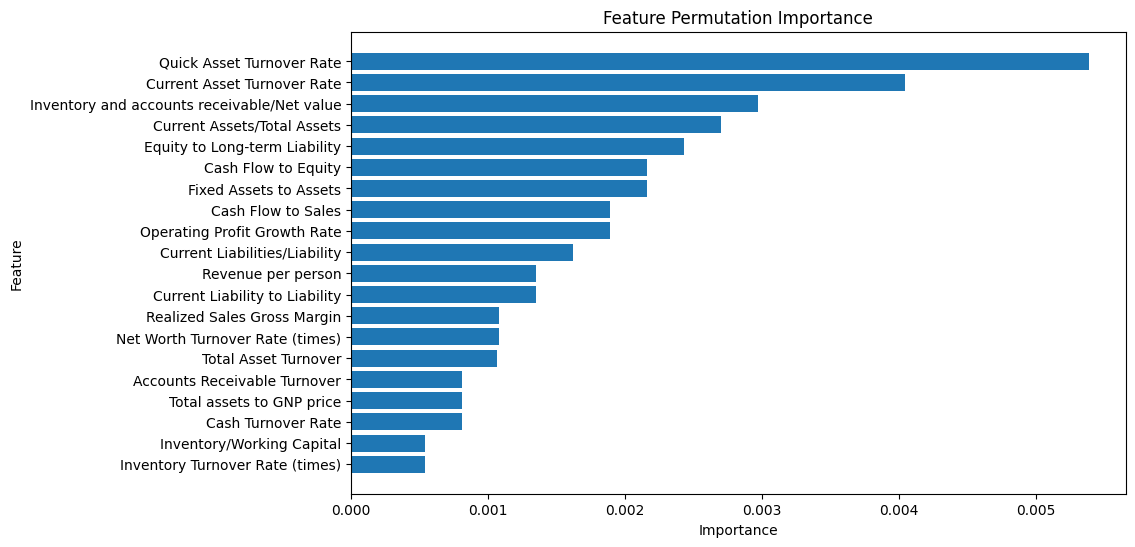

In [ ]:
plot_feat_permut_importance(et_feat_permut_import_df)

In [ ]:
et_perf, et_orig_missing, et_missing = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Current Asset Turnover Rate
Original feat removed so far:  ['Quick Asset Turnover Rate', 'Current Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Inventory and accounts receivable/Net value
Original feat removed so far:  ['Quick Asset Turnover Rate', 'Current Asset Turnover Rate', 'Inventory and accounts receivable/Net value']

--- NEW ITERATION ---
Removing feature:  Current Assets/Total Assets
Original feat removed so far:  ['Quick Asset Turnover Rate', 'Current Asset Turnover Rate', 'Inventory and accounts receivable/Net value', 'Current Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Equity to Long-term Liability
Original feat removed so far:  ['Quick Asset Turnover Rate', 'Current Asset Turnover Rate', 'Inventory and accounts receivable/Net value', 'Current Assets/Total Assets', 'E

In [ ]:
et_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
1   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
2   28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
3   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
4   28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
5   28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
6   28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
7   28  1267  53  16      34.57   63.64        95.98     94.94     44.80   
8   29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
9   29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
10  28  1266  54  16      34.15   63.64        95.91     94.87     44.44   
11  27  1266  54  17      33.33   61.36        95.91     94.79     43.20   
12  27  1266  54  17      33.33   61.36        95.91     94.79     43.20   
13  28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
14  28  1265  55  16      33.73   63.64        95.83     94.79     44.09   
15  28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
16  28  1264  56  16      33.33   63.64        95.76     94.72     43.75   
17  28  1263  57  16      32.94   63.64        95.68     94.65     43.41   
18  29  1263  57  15      33.72   65.91        95.68     94.72     44.62   
19  29  1263  57  15      33.72   65.91        95.68     94.72     44.62   
20  29  1264  56  15      34.12   65.91        95.76     94.79     44.96   

    balanced_accuracy  num_feat_missing  \
0               79.92                 0   
1               79.89                 1   
2               79.85                 2   
3               79.89                 3   
4               79.85                 4   
5               79.85                 5   
6               79.85                 6   
7               79.81                 7   
8               80.91                 8   
9               80.91                 9   
10              79.77                10   
11              78.64                11   
12              78.64                12   
13              79.73                13   
14              79.73                14   
15              79.70                15   
16              79.70                16   
17              79.66                17   
18              80.80                18   
19              80.80                19   
20              80.83                20   

                                              imputed  
0                                                      
1               ['Quick Asset Turnover Rate'] imputed  
2   ['Quick Asset Turnover Rate', 'Current Asset T...  
3   ['Quick Asset Turnover Rate', 'Current Asset T...  
4   ['Quick Asset Turnover Rate', 'Current Asset T...  
5   ['Quick Asset Turnover Rate', 'Current Asset T...  
6   ['Quick Asset Turnover Rate', 'Current Asset T...  
7   ['Quick Asset Turnover Rate', 'Current Asset T...  
8   ['Quick Asset Turnover Rate', 'Current Asset T...  
9   ['Quick Asset Turnover Rate', 'Current Asset T...  
10  ['Quick Asset Turnover Rate', 'Current Asset T...  
11  ['Quick Asset Turnover Rate', 'Current Asset T...  
12  ['Quick Asset Turnover Rate', 'Current Asset T...  
13  ['Quick Asset Turnover Rate', 'Current Asset T...  
14  ['Quick Asset Turnover Rate', 'Current Asset T...  
15  ['Quick Asset Turnover Rate', 'Current Asset T...  
16  ['Quick Asset Turnover Rate', 'Current Asset T...  
17  ['Quick Asset Turnover Rate', 'Current Asset T...  
18  ['Quick Asset Turnover Rate', 'Current Asset T...  
19  ['Quick Asset Turnover Rate', 'Current Asset T...  
20  ['Quick Asset Turnover Rate', 'Current Asset T...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et_perf_mf, et_orig_missing_mf, et_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et_classifier, et_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 16:48:58.145582

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', '

In [ ]:
et_perf_mf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
1   28  1270  50  16      35.90   63.64        96.21     95.16     45.90   
2   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
3   28  1269  51  16      35.44   63.64        96.14     95.09     45.53   
4   29  1269  51  15      36.25   65.91        96.14     95.16     46.77   
5   28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
6   28  1268  52  16      35.00   63.64        96.06     95.01     45.16   
7   29  1267  53  15      35.37   65.91        95.98     95.01     46.03   
8   29  1267  53  15      35.37   65.91        95.98     95.01     46.03   
9   29  1268  52  15      35.80   65.91        96.06     95.09     46.40   
10  29  1268  52  15      35.80   65.91        96.06     95.09     46.40   
11  29  1267  53  15      35.37   65.91        95.98     95.01     46.03   
12  29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
13  29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
14  29  1266  54  15      34.94   65.91        95.91     94.94     45.67   
15  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
16  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
17  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
18  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
19  29  1265  55  15      34.52   65.91        95.83     94.87     45.31   
20  29  1262  58  15      33.33   65.91        95.61     94.65     44.27   

    balanced_accuracy  num_feat_missing  \
0               79.92                 0   
1               79.92                 1   
2               79.89                 2   
3               79.89                 3   
4               81.02                 4   
5               79.85                 5   
6               79.85                 6   
7               80.95                 7   
8               80.95                 8   
9               80.98                 9   
10              80.98                10   
11              80.95                11   
12              80.91                12   
13              80.91                13   
14              80.91                14   
15              80.87                15   
16              80.87                16   
17              80.87                17   
18              80.87                18   
19              80.87                19   
20              80.76                20   

                                              imputed  
0                                                      
1               ['Quick Asset Turnover Rate'] imputed  
2   ['Quick Asset Turnover Rate', 'Current Asset T...  
3   ['Quick Asset Turnover Rate', 'Current Asset T...  
4   ['Quick Asset Turnover Rate', 'Current Asset T...  
5   ['Quick Asset Turnover Rate', 'Current Asset T...  
6   ['Quick Asset Turnover Rate', 'Current Asset T...  
7   ['Quick Asset Turnover Rate', 'Current Asset T...  
8   ['Quick Asset Turnover Rate', 'Current Asset T...  
9   ['Quick Asset Turnover Rate', 'Current Asset T...  
10  ['Quick Asset Turnover Rate', 'Current Asset T...  
11  ['Quick Asset Turnover Rate', 'Current Asset T...  
12  ['Quick Asset Turnover Rate', 'Current Asset T...  
13  ['Quick Asset Turnover Rate', 'Current Asset T...  
14  ['Quick Asset Turnover Rate', 'Current Asset T...  
15  ['Quick Asset Turnover Rate', 'Current Asset T...  
16  ['Quick Asset Turnover Rate', 'Current Asset T...  
17  ['Quick Asset Turnover Rate', 'Current Asset T...  
18  ['Quick Asset Turnover Rate', 'Current Asset T...  
19  ['Quick Asset Turnover Rate', 'Current Asset T...  
20  ['Quick Asset Turnover Rate', 'Current Asset T...

##**Support Vector Classifier**

In [ ]:
# scale data with MinMax
X_train_scaled, taiwan_scaler = scale_minmax_features(X_train, mode="train", scaler = None)
X_test_scaled, _ = scale_minmax_features(X_test, mode="test", scaler = taiwan_scaler)

In [ ]:
taiwan_imputation_scaled_values_dict = calculate_imputation_values_for_missing(X_train_scaled)

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm_param_grid = {
      'C': [0.1, 1, 2, 3, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm_param_grid = {
    'C': [10],
    'kernel': ['rbf'],
    'gamma': [0.5],
    'degree': [2]
}

svm_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm_grid_search, svm_best_model, svm_best_params = hyperparameter_tuning(
    svm_classifier, svm_param_grid, 3, 3, 'f1', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:03:54.109775

Nested Cross-validation Results:
Individual scores: [0.36158192 0.28037383 0.31088083]
Average nested CV score: 0.318 (+/- 0.067)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 10, 'degree': 2, 'gamma': 0.5, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.318
2025-01-16 17:04:00.881812

Execution time: 0.11 minutes




```
Starting hyperparameter tuning at: 2025-01-15 19:34:03.813954

Nested Cross-validation Results:
Individual scores: [0.32380952 0.24742268 0.27906977]
Average nested CV score: 0.283 (+/- 0.063)

Fitting final model on entire dataset...
Fitting 3 folds for each of 420 candidates, totalling 1260 fits
Best parameters: {'C': 10, 'degree': 2, 'gamma': 0.5, 'kernel': 'rbf'}

Best Model Performance:
Best CV score: 0.318
2025-01-15 19:40:32.921342

Execution time: 6.49 minutes
```



In [ ]:
svm_classifier, train_pred, test_pred = apply_model(svm_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm_feat_permut_import_df = analyze_feat_permut_import(svm_classifier, X_train_scaled, y_train, scoring_metric="f1")
svm_feat_permut_import_df[svm_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
73                                 Cash Turnover Rate    0.054872  0.007448
71                          Quick Asset Turnover Rate    0.054069  0.013729
48                    Fixed Assets Turnover Frequency    0.050068  0.007086
47                    Inventory Turnover Rate (times)    0.048345  0.009263
54                          Quick Assets/Total Assets    0.045250  0.005962
..                                                ...         ...       ...
0   ROA(C) before interest and depreciation before...   -0.028603  0.005421
53                    Working Capital to Total Assets   -0.029118  0.007524
2   ROA(B) before interest and depreciation after tax   -0.037934  0.008200
36                                       Debt ratio %   -0.045684  0.011024
37                                   Net worth/Assets   -0.045684  0.011024

[77 rows x 3 columns]

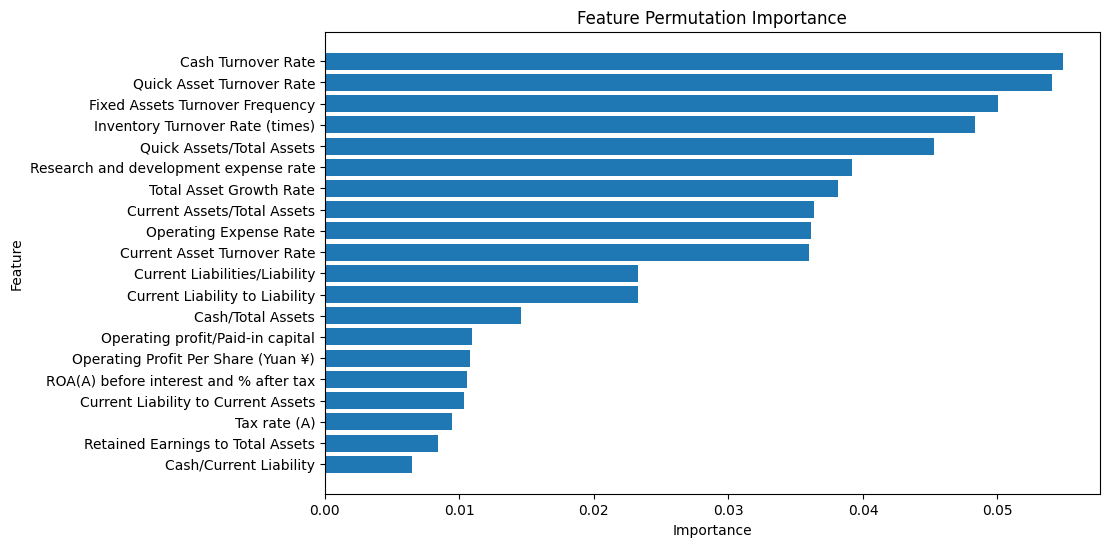

In [ ]:
plot_feat_permut_importance(svm_feat_permut_import_df)

In [ ]:
svm_perf, svm_orig_missing, svm_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Quick Asset Turnover Rate
Original feat removed so far:  ['Cash Turnover Rate', 'Quick Asset Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Fixed Assets Turnover Frequency
Original feat removed so far:  ['Cash Turnover Rate', 'Quick Asset Turnover Rate', 'Fixed Assets Turnover Frequency']

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Cash Turnover Rate', 'Quick Asset Turnover Rate', 'Fixed Assets Turnover Frequency', 'Inventory Turnover Rate (times)']

--- NEW ITERATION ---
Removing feature:  Quick Assets/Total Assets
Original feat removed so far:  ['Cash Turnover Rate', 'Quick Asset Turnover Rate', 'Fixed Assets Turnover Frequency', 'Inventory Turnover Rate (times)', 'Quick Assets/Total Assets']

--- NEW ITERATION ---
Removing feature:  Research and developmen

In [ ]:
svm_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1233   87  22      20.18   50.00        93.41     92.01     28.76   
1   30  1213  107  14      21.90   68.18        91.89     91.13     33.15   
2   30  1186  134  14      18.29   68.18        89.85     89.15     28.85   
3   33  1179  141  11      18.97   75.00        89.32     88.86     30.28   
4   35  1176  144   9      19.55   79.55        89.09     88.78     31.39   
5   36  1142  178   8      16.82   81.82        86.52     86.36     27.91   
6   39  1112  208   5      15.79   88.64        84.24     84.38     26.80   
7   36  1083  237   8      13.19   81.82        82.05     82.04     22.71   
8   37  1067  253   7      12.76   84.09        80.83     80.94     22.16   
9   40  1077  243   4      14.13   90.91        81.59     81.89     24.46   
10  40  1070  250   4      13.79   90.91        81.06     81.38     23.95   
11  41  1037  283   3      12.65   93.18        78.56     79.03     22.28   
12  42  1020  300   2      12.28   95.45        77.27     77.86     21.76   
13  41  1050  270   3      13.18   93.18        79.55     79.99     23.10   
14  41  1047  273   3      13.06   93.18        79.32     79.77     22.91   
15  41  1044  276   3      12.93   93.18        79.09     79.55     22.71   
16  42  1041  279   2      13.08   95.45        78.86     79.40     23.01   
17  42  1038  282   2      12.96   95.45        78.64     79.18     22.83   
18  42  1038  282   2      12.96   95.45        78.64     79.18     22.83   
19  42  1035  285   2      12.84   95.45        78.41     78.96     22.64   
20  42  1035  285   2      12.84   95.45        78.41     78.96     22.64   

    balanced_accuracy  num_feat_missing  \
0               71.70                 0   
1               80.04                 1   
2               79.02                 2   
3               82.16                 3   
4               84.32                 4   
5               84.17                 5   
6               86.44                 6   
7               81.93                 7   
8               82.46                 8   
9               86.25                 9   
10              85.98                10   
11              85.87                11   
12              86.36                12   
13              86.36                13   
14              86.25                14   
15              86.14                15   
16              87.16                16   
17              87.05                17   
18              87.05                18   
19              86.93                19   
20              86.93                20   

                                              imputed  
0                                                      
1                      ['Cash Turnover Rate'] imputed  
2   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
3   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
4   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
5   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
6   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
7   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
8   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
9   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
10  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
11  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
12  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
13  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
14  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
15  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
16  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
17  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
18  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
19  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
20  ['Cash Turnover Rate', 'Quick Asset Turnover R...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm_perf_mf, svm_orig_missing_mf, svm_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm_classifier, svm_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:05:29.556440

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-t

In [ ]:
svm_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   22  1233   87  22      20.18   50.00        93.41     92.01     28.76   
1   28  1228   92  16      23.33   63.64        93.03     92.08     34.15   
2   31  1226   94  13      24.80   70.45        92.88     92.16     36.69   
3   31  1224   96  13      24.41   70.45        92.73     92.01     36.26   
4   34  1192  128  10      20.99   77.27        90.30     89.88     33.01   
5   33  1185  135  11      19.64   75.00        89.77     89.30     31.13   
6   35  1179  141   9      19.89   79.55        89.32     89.00     31.82   
7   35  1163  157   9      18.23   79.55        88.11     87.83     29.66   
8   35  1151  169   9      17.16   79.55        87.20     86.95     28.23   
9   37  1136  184   7      16.74   84.09        86.06     86.00     27.92   
10  40  1119  201   4      16.60   90.91        84.77     84.97     28.07   
11  40  1110  210   4      16.00   90.91        84.09     84.31     27.21   
12  41  1090  230   3      15.13   93.18        82.58     82.92     26.03   
13  39  1093  227   5      14.66   88.64        82.80     82.99     25.16   
14  40  1092  228   4      14.93   90.91        82.73     82.99     25.64   
15  40  1087  233   4      14.65   90.91        82.35     82.62     25.24   
16  39  1084  236   5      14.18   88.64        82.12     82.33     24.45   
17  40  1082  238   4      14.39   90.91        81.97     82.26     24.84   
18  40  1105  215   4      15.69   90.91        83.71     83.94     26.76   
19  40  1106  214   4      15.75   90.91        83.79     84.02     26.85   
20  40  1102  218   4      15.50   90.91        83.48     83.72     26.49   

    balanced_accuracy  num_feat_missing  \
0               71.70                 0   
1               78.33                 1   
2               81.67                 2   
3               81.59                 3   
4               83.79                 4   
5               82.39                 5   
6               84.43                 6   
7               83.83                 7   
8               83.37                 8   
9               85.08                 9   
10              87.84                10   
11              87.50                11   
12              87.88                12   
13              85.72                13   
14              86.82                14   
15              86.63                15   
16              85.38                16   
17              86.44                17   
18              87.31                18   
19              87.35                19   
20              87.20                20   

                                              imputed  
0                                                      
1                      ['Cash Turnover Rate'] imputed  
2   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
3   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
4   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
5   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
6   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
7   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
8   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
9   ['Cash Turnover Rate', 'Quick Asset Turnover R...  
10  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
11  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
12  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
13  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
14  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
15  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
16  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
17  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
18  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
19  ['Cash Turnover Rate', 'Quick Asset Turnover R...  
20  ['Cash Turnover Rate', 'Quick Asset Turnover R...

##**Logistic Regression**

**Data pre-processing:** It is highly recommended to mitigate as much as possible the presence of multicolinearity between features before applying Logistic regression.

In [ ]:
present_features = list(X_train_scaled.columns) + ['Target']
filtered_taiwan_dist_corr = taiwan_dist_corr[present_features]
filtered_taiwan_dist_corr = filtered_taiwan_dist_corr[filtered_taiwan_dist_corr.index.isin(present_features)]
filtered_feat = filter_out_intercorrelated_features(filtered_taiwan_dist_corr, 'Target', 0.8)

appended feature:  Net Income to Stockholder's Equity
eliminated feature:  Net Income to Total Assets 0.8936021693923298
eliminated feature:  ROA(A) before interest and % after tax 0.8846014762494652
eliminated feature:  ROA(B) before interest and depreciation after tax 0.8212433093824045
eliminated feature:  Persistent EPS in the Last Four Seasons 0.8372269110916617
eliminated feature:  ROA(C) before interest and depreciation before interest 0.8080800916836077
eliminated feature:  Net profit before tax/Paid-in capital 0.838590891159282
eliminated feature:  Per Share Net profit before tax (Yuan ¥) 0.835522613001148
appended feature:  Borrowing dependency
eliminated feature:  Liability to Equity 0.8585354792380225
appended feature:  Retained Earnings to Total Assets
appended feature:  Current Liability to Equity
eliminated feature:  Current Liabilities/Equity 0.999999999929129
eliminated feature:  Debt ratio % 0.8520719525785985
eliminated feature:  Net worth/Assets 0.8520719525580661
e

In [ ]:
lr_X_train = X_train_scaled[filtered_feat]
lr_X_test = X_test_scaled[filtered_feat]

In [ ]:
print('Nr. features for Logistic Regression: ', len(lr_X_train.columns))

Nr. features for Logistic Regression:  61


In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],  # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
  }
else:
  lr_param_grid = {
      'C': [5],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr_grid_search, lr_best_model, lr_best_params = hyperparameter_tuning(
    lr_classifier, lr_param_grid, 3, 3, 'f1', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:18:31.632212

Nested Cross-validation Results:
Individual scores: [0.26666667 0.2739726  0.28125   ]
Average nested CV score: 0.274 (+/- 0.012)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.274
2025-01-16 17:19:55.725166

Execution time: 1.40 minutes


```
Starting hyperparameter tuning at: 2025-01-15 19:40:33.783032

Nested Cross-validation Results:
Individual scores: [0.26210826 0.26478873 0.26582278]
Average nested CV score: 0.264 (+/- 0.003)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.274
2025-01-15 19:42:52.150341

Execution time: 2.31 minutes
```



In [ ]:
lr_classifier, train_pred, test_pred = apply_model(lr_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr_feat_permut_import_df = analyze_feat_permut_import(lr_classifier, lr_X_train, y_train, scoring_metric="f1")
lr_feat_permut_import_df[lr_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11                          Equity to Liability  4.506841e-02  0.013072
20                         Total expense/Assets  2.892194e-02  0.001677
32                       Cash Flow to Liability  1.607261e-02  0.003295
50               Current Liability to Liability  1.569108e-02  0.001040
29                         Total Asset Turnover  1.475543e-02  0.006745
27                          Cash Flow to Equity  1.425682e-02  0.001337
19  Inventory and accounts receivable/Net value  1.092923e-02  0.001647
43                           Cash Turnover Rate  9.986278e-03  0.005684
28                    Quick Assets/Total Assets  8.490866e-03  0.000652
49              Inventory Turnover Rate (times)  6.627406e-03  0.001948
14                        Liability-Assets Flag  6.508600e-03  0.000292
34                      Total Asset Growth Rate  3.467687e-03  0.001564
46                   Total debt/Total net worth  2.463628e-03  0.000285
52                       Operating Expense Rate  2.408589e-03  0.001545
39         Long-term fund suitability ratio (A)  1.923947e-03  0.000538
55                 Accounts Receivable Turnover  1.381764e-03  0.000463
53                  Current Asset Turnover Rate  1.285594e-03  0.000349
10                Equity to Long-term Liability  1.199659e-03  0.001111
47                    Total assets to GNP price  8.935026e-04  0.000741
33           Degree of Financial Leverage (DFL)  8.273792e-04  0.000220
9                   Operating profit per person  7.146681e-04  0.001113
37                 Operating Profit Growth Rate  6.440970e-04  0.000286
42        Research and development expense rate  4.909561e-04  0.000454
57                  Inventory/Current Liability  4.683829e-04  0.000397
12                                 Tax rate (A)  4.432831e-04  0.002168
58                   Revenue Per Share (Yuan ¥)  2.932353e-04  0.000000
6          Continuous interest rate (after tax)  2.928943e-04  0.000321
16                       Interest Expense Ratio  2.345882e-04  0.000117
26                           No-credit Interval  2.342479e-04  0.000341
40                           Revenue per person  1.759412e-04  0.000144
59               Quick Assets/Current Liability  1.759412e-04  0.000144
25                    Inventory/Working Capital  5.670514e-05  0.000777
24             After-tax Net Profit Growth Rate -1.138778e-07  0.000186
56                      Average Collection Days -2.351580e-04  0.000220
51                   Allocation rate per person -2.939189e-04  0.000186
45                    Quick Asset Turnover Rate -1.163270e-03  0.002589
21                       Cash/Current Liability -1.306852e-03  0.001443
48          Interest-bearing debt interest rate -1.373415e-03  0.001177
17                                CFO to Assets -1.466866e-03  0.002710
15                       Operating Gross Margin -4.319652e-03  0.002251
23                            Cash/Total Assets -4.332644e-03  0.005067
2             Retained Earnings to Total Assets -5.842139e-03  0.001745
31              Fixed Assets Turnover Frequency -6.352030e-03  0.003011
1                          Borrowing dependency -6.908147e-03  0.002194
8           Operating Profit Per Share (Yuan ¥) -1.092085e-02  0.002862
5                       Net Value Per Share (A) -1.549640e-02  0.006989

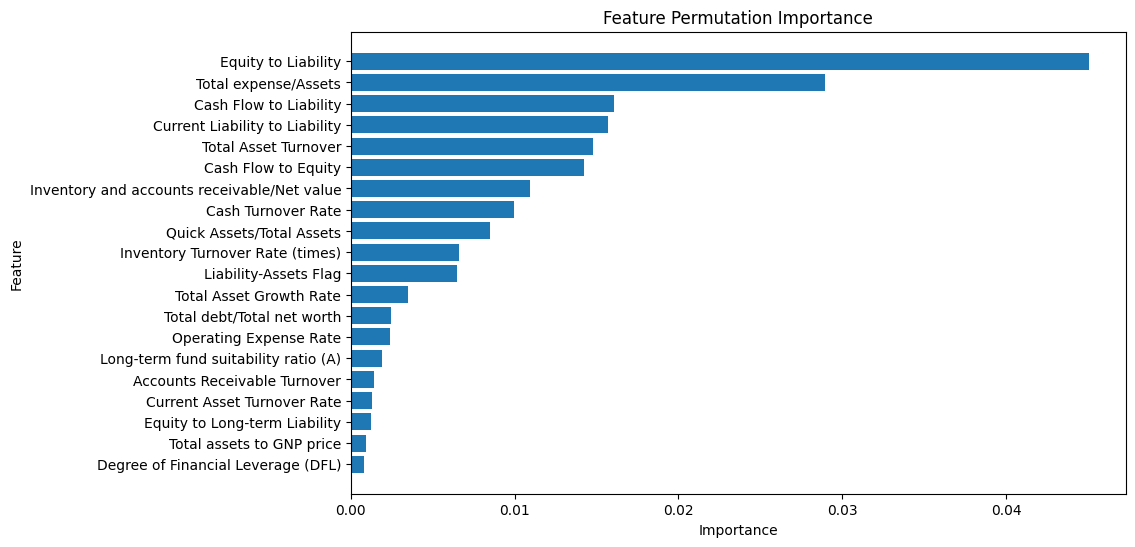

In [ ]:
plot_feat_permut_importance(lr_feat_permut_import_df)

In [ ]:
lr_perf, lr_orig_missing, lr_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Current Liability to Liability
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets', 'Cash Flow to Liability', 'Current Liability to Liability']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Liability', 'Total expense/Assets', 'Cash Flow to Liability', 'Current Liability to Liability', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Equity
Original feat removed so far:  ['Equity to Liability', 'Total expense/A

In [ ]:
lr_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
2   32  1160  160  12      16.67   72.73        87.88     87.39     27.12   
3   32  1181  139  12      18.71   72.73        89.47     88.93     29.77   
4   34  1165  155  10      17.99   77.27        88.26     87.90     29.18   
5   33  1183  137  11      19.41   75.00        89.62     89.15     30.84   
6   33  1178  142  11      18.86   75.00        89.24     88.78     30.14   
7   34  1166  154  10      18.09   77.27        88.33     87.98     29.31   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               81.02                 1   
2               80.30                 2   
3               81.10                 3   
4               82.77                 4   
5               82.31                 5   
6               82.12                 6   
7               82.80                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total expense/Assets'...  
3   ['Equity to Liability', 'Total expense/Assets'...  
4   ['Equity to Liability', 'Total expense/Assets'...  
5   ['Equity to Liability', 'Total expense/Assets'...  
6   ['Equity to Liability', 'Total expense/Assets'...  
7   ['Equity to Liability', 'Total expense/Assets'...  
8   ['Equity to Liability', 'Total expense/Assets'...  
9   ['Equity to Liability', 'Total expense/Assets'...  
10  ['Equity to Liability', 'Total expense/Assets'...  
11  ['Equity to Liability', 'Total expense/Assets'...  
12  ['Equity to Liability', 'Total expense/Assets'...  
13  ['Equity to Liability', 'Total expense/Assets'...  
14  ['Equity to Liability', 'Total expense/Assets'...  
15  ['Equity to Liability', 'Total expense/Assets'...  
16  ['Equity to Liability', 'Total expense/Assets'...  
17  ['Equity to Liability', 'Total expense/Assets'...  
18  ['Equity to Liability', 'Total expense/Assets'...  
19  ['Equity to Liability', 'Total expense/Assets'...  
20  ['Equity to Liability', 'Total expense/Assets'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr_perf_mf, lr_orig_missing_mf, lr_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr_classifier, lr_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:20:16.368137

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total Asse

In [ ]:
lr_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   36  1161  159   8      18.46   81.82        87.95     87.76     30.13   
2   35  1157  163   9      17.68   79.55        87.65     87.39     28.93   
3   36  1156  164   8      18.00   81.82        87.58     87.39     29.51   
4   36  1164  156   8      18.75   81.82        88.18     87.98     30.51   
5   34  1164  156  10      17.89   77.27        88.18     87.83     29.06   
6   34  1166  154  10      18.09   77.27        88.33     87.98     29.31   
7   34  1164  156  10      17.89   77.27        88.18     87.83     29.06   
8   35  1172  148   9      19.13   79.55        88.79     88.49     30.84   
9   35  1162  158   9      18.13   79.55        88.03     87.76     29.54   
10  34  1167  153  10      18.18   77.27        88.41     88.05     29.44   
11  34  1167  153  10      18.18   77.27        88.41     88.05     29.44   
12  35  1169  151   9      18.82   79.55        88.56     88.27     30.43   
13  35  1169  151   9      18.82   79.55        88.56     88.27     30.43   
14  35  1160  160   9      17.95   79.55        87.88     87.61     29.29   
15  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
16  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
17  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
18  35  1158  162   9      17.77   79.55        87.73     87.46     29.05   
19  36  1158  162   8      18.18   81.82        87.73     87.54     29.75   
20  36  1160  160   8      18.37   81.82        87.88     87.68     30.00   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               84.89                 1   
2               83.60                 2   
3               84.70                 3   
4               85.00                 4   
5               82.73                 5   
6               82.80                 6   
7               82.73                 7   
8               84.17                 8   
9               83.79                 9   
10              82.84                10   
11              82.84                11   
12              84.05                12   
13              84.05                13   
14              83.71                14   
15              83.64                15   
16              83.64                16   
17              83.64                17   
18              83.64                18   
19              84.77                19   
20              84.85                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Total expense/Assets'...  
3   ['Equity to Liability', 'Total expense/Assets'...  
4   ['Equity to Liability', 'Total expense/Assets'...  
5   ['Equity to Liability', 'Total expense/Assets'...  
6   ['Equity to Liability', 'Total expense/Assets'...  
7   ['Equity to Liability', 'Total expense/Assets'...  
8   ['Equity to Liability', 'Total expense/Assets'...  
9   ['Equity to Liability', 'Total expense/Assets'...  
10  ['Equity to Liability', 'Total expense/Assets'...  
11  ['Equity to Liability', 'Total expense/Assets'...  
12  ['Equity to Liability', 'Total expense/Assets'...  
13  ['Equity to Liability', 'Total expense/Assets'...  
14  ['Equity to Liability', 'Total expense/Assets'...  
15  ['Equity to Liability', 'Total expense/Assets'...  
16  ['Equity to Liability', 'Total expense/Assets'...  
17  ['Equity to Liability', 'Total expense/Assets'...  
18  ['Equity to Liability', 'Total expense/Assets'...  
19  ['Equity to Liability', 'Total expense/Assets'...  
20  ['Equity to Liability', 'Total expense/Assets'...

# **Models optimized for Balanced Accuracy**

##**Decision tree**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  dt2_param_grid = {
      'max_depth': [2, 3, 4, 5, None],
      'min_samples_split': [0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.1, 0.05, 0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  dt2_param_grid = {
      'max_depth': [4],
      'min_samples_split': [0.1],
      'min_samples_leaf': [0.05]
  }

dt2_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)
dt2_grid_search, dt2_best_model, dt2_best_params = hyperparameter_tuning(
    dt2_classifier, dt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:26:34.034922

Nested Cross-validation Results:
Individual scores: [0.81927966 0.87716497 0.85413997]
Average nested CV score: 0.850 (+/- 0.048)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.850
2025-01-16 17:26:39.600967

Execution time: 0.09 minutes




```
Starting hyperparameter tuning at: 2025-01-15 21:13:29.431811

Nested Cross-validation Results:
Individual scores: [0.79882512 0.8242065  0.83576955]
Average nested CV score: 0.820 (+/- 0.031)

Fitting final model on entire dataset...
Fitting 3 folds for each of 210 candidates, totalling 630 fits
Best parameters: {'max_depth': 4, 'min_samples_leaf': 0.05, 'min_samples_split': 0.1}

Best Model Performance:
Best CV score: 0.850
2025-01-15 21:14:10.639582

Execution time: 0.69 minutes
```



In [ ]:
# dt_grid_search.cv_results_

In [ ]:
dt2_classifier, dt2_train_pred, dt2_test_pred = apply_model(dt2_best_model, X_train, y_train, X_test, y_test)
dt2_feat_permut_import_df = analyze_feat_permut_import(dt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
dt2_feat_permut_import_df[dt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
18      Persistent EPS in the Last Four Seasons    0.317538  0.014494
35                   Total debt/Total net worth    0.058371  0.007998
34                       Interest Expense Ratio    0.039183  0.003630
8   Non-industry income and expenditure/revenue    0.034355  0.012795

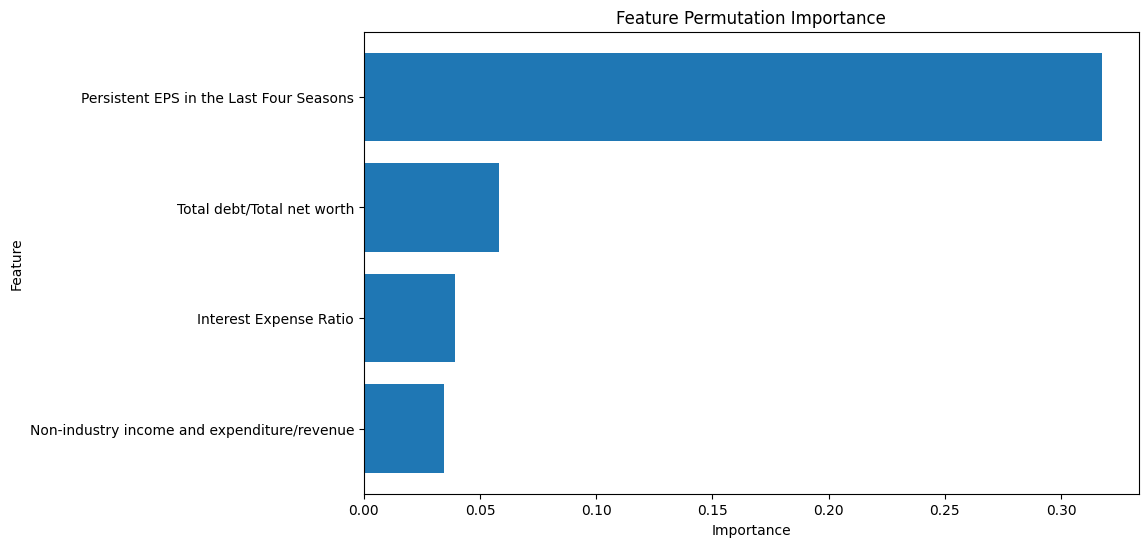

In [ ]:
plot_feat_permut_importance(dt2_feat_permut_import_df)

In [ ]:
dt2_perf, dt2_orig_missing, dt2_missing = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Non-industry income and expenditure/revenue
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth', 'Interest Expense Ratio', 'Non-industry income and expenditure/revenue']

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth', 'Interest Expense Ratio', 'Non

In [ ]:
dt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1108  212   5      15.54   88.64        83.94     84.09     26.44   
1    5  1250   70  39       6.67   11.36        94.70     92.01      8.40   
2    5  1250   70  39       6.67   11.36        94.70     92.01      8.40   
3    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
4    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
5    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
6    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
7    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               86.29                 0   
1               53.03                 1   
2               53.03                 2   
3               50.00                 3   
4               50.00                 4   
5               50.00                 5   
6               50.00                 6   
7               50.00                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'T...  
3   ['Persistent EPS in the Last Four Seasons', 'T...  
4   ['Persistent EPS in the Last Four Seasons', 'T...  
5   ['Persistent EPS in the Last Four Seasons', 'T...  
6   ['Persistent EPS in the Last Four Seasons', 'T...  
7   ['Persistent EPS in the Last Four Seasons', 'T...  
8   ['Persistent EPS in the Last Four Seasons', 'T...  
9   ['Persistent EPS in the Last Four Seasons', 'T...  
10  ['Persistent EPS in the Last Four Seasons', 'T...  
11  ['Persistent EPS in the Last Four Seasons', 'T...  
12  ['Persistent EPS in the Last Four Seasons', 'T...  
13  ['Persistent EPS in the Last Four Seasons', 'T...  
14  ['Persistent EPS in the Last Four Seasons', 'T...  
15  ['Persistent EPS in the Last Four Seasons', 'T...  
16  ['Persistent EPS in the Last Four Seasons', 'T...  
17  ['Persistent EPS in the Last Four Seasons', 'T...  
18  ['Persistent EPS in the Last Four Seasons', 'T...  
19  ['Persistent EPS in the Last Four Seasons', 'T...  
20  ['Persistent EPS in the Last Four Seasons', 'T...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

dt2_perf_mf, dt2_orig_missing_mf, dt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, dt2_classifier, dt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:26:42.431516

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit G

In [ ]:
dt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   39  1108  212   5      15.54   88.64        83.94     84.09     26.44   
1   37  1097  223   7      14.23   84.09        83.11     83.14     24.34   
2   37  1090  230   7      13.86   84.09        82.58     82.62     23.79   
3   36  1103  217   8      14.23   81.82        83.56     83.50     24.24   
4   34  1115  205  10      14.23   77.27        84.47     84.24     24.03   
5   34  1112  208  10      14.05   77.27        84.24     84.02     23.78   
6   34  1112  208  10      14.05   77.27        84.24     84.02     23.78   
7   34  1114  206  10      14.17   77.27        84.39     84.16     23.94   
8   34  1115  205  10      14.23   77.27        84.47     84.24     24.03   
9   34  1116  204  10      14.29   77.27        84.55     84.31     24.11   
10  34  1117  203  10      14.35   77.27        84.62     84.38     24.20   
11  34  1117  203  10      14.35   77.27        84.62     84.38     24.20   
12  34  1120  200  10      14.53   77.27        84.85     84.60     24.46   
13  35  1122  198   9      15.02   79.55        85.00     84.82     25.27   
14  34  1123  197  10      14.72   77.27        85.08     84.82     24.73   
15  34  1125  195  10      14.85   77.27        85.23     84.97     24.91   
16  34  1122  198  10      14.66   77.27        85.00     84.75     24.64   
17  34  1124  196  10      14.78   77.27        85.15     84.90     24.82   
18  34  1124  196  10      14.78   77.27        85.15     84.90     24.82   
19  34  1127  193  10      14.98   77.27        85.38     85.12     25.09   
20  34  1125  195  10      14.85   77.27        85.23     84.97     24.91   

    balanced_accuracy  num_feat_missing  \
0               86.29                 0   
1               83.60                 1   
2               83.33                 2   
3               82.69                 3   
4               80.87                 4   
5               80.76                 5   
6               80.76                 6   
7               80.83                 7   
8               80.87                 8   
9               80.91                 9   
10              80.95                10   
11              80.95                11   
12              81.06                12   
13              82.27                13   
14              81.17                14   
15              81.25                15   
16              81.14                16   
17              81.21                17   
18              81.21                18   
19              81.33                19   
20              81.25                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'T...  
3   ['Persistent EPS in the Last Four Seasons', 'T...  
4   ['Persistent EPS in the Last Four Seasons', 'T...  
5   ['Persistent EPS in the Last Four Seasons', 'T...  
6   ['Persistent EPS in the Last Four Seasons', 'T...  
7   ['Persistent EPS in the Last Four Seasons', 'T...  
8   ['Persistent EPS in the Last Four Seasons', 'T...  
9   ['Persistent EPS in the Last Four Seasons', 'T...  
10  ['Persistent EPS in the Last Four Seasons', 'T...  
11  ['Persistent EPS in the Last Four Seasons', 'T...  
12  ['Persistent EPS in the Last Four Seasons', 'T...  
13  ['Persistent EPS in the Last Four Seasons', 'T...  
14  ['Persistent EPS in the Last Four Seasons', 'T...  
15  ['Persistent EPS in the Last Four Seasons', 'T...  
16  ['Persistent EPS in the Last Four Seasons', 'T...  
17  ['Persistent EPS in the Last Four Seasons', 'T...  
18  ['Persistent EPS in the Last Four Seasons', 'T...  
19  ['Persistent EPS in the Last Four Seasons', 'T...  
20  ['Persistent EPS in the Last Four Seasons', 'T...

## **Random Forests**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  rf2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_features': ['sqrt', 0.5, 1.0],
      'max_depth': [3, 5, None],
      'min_samples_split': [0.01, 0.005, 0.001, 2],
      'min_samples_leaf': [0.01, 0.005, 0.001, 1]
  }
else:
  # best model
  rf2_param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'min_samples_split': [0.01],
    'min_samples_leaf': [0.01],
    'max_depth': [None],
}

rf2_classifier = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
rf2_grid_search, rf2_best_model, rf2_best_params = hyperparameter_tuning(
    rf2_classifier, rf2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:41:39.155864

Nested Cross-validation Results:
Individual scores: [0.84778505 0.87544083 0.85287769]
Average nested CV score: 0.859 (+/- 0.024)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.859
2025-01-16 17:41:50.930551

Execution time: 0.20 minutes



```
Starting hyperparameter tuning at: 2025-01-16 06:10:38.991168

Nested Cross-validation Results:
Individual scores: [0.84996148 0.87592085 0.82876924]
Average nested CV score: 0.852 (+/- 0.039)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.01, 'min_samples_split': 0.01, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.859
2025-01-16 07:41:22.048394

Execution time: 90.72 minutes

```



In [ ]:
# rf2_grid_search.cv_results_

In [ ]:
rf2_classifier, rf2_train_pred, rf2_test_pred = apply_model(rf2_best_model, X_train, y_train, X_test, y_test)
rf2_feat_permut_import_df = analyze_feat_permut_import(rf2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
rf2_feat_permut_import_df[rf2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
34                             Interest Expense Ratio    0.007481  0.002262
39                               Borrowing dependency    0.007158  0.004886
86                          Total assets to GNP price    0.006269  0.001224
72                     Working capitcal Turnover Rate    0.005928  0.000114
64                             Working Capital/Equity    0.004981  0.001133
..                                                ...         ...       ...
85                         Net Income to Total Assets   -0.002311  0.003712
2   ROA(B) before interest and depreciation after tax   -0.003504  0.001461
68                         Total income/Total expense   -0.003523  0.002806
9                Continuous interest rate (after tax)   -0.003713  0.002462
18            Persistent EPS in the Last Four Seasons   -0.004452  0.002654

[93 rows x 3 columns]

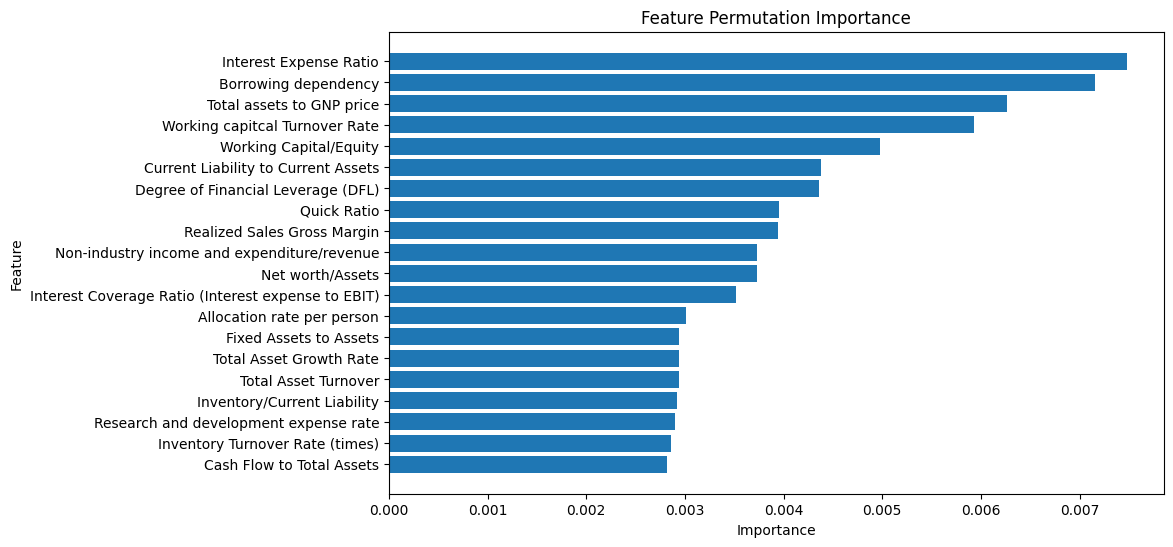

In [ ]:
plot_feat_permut_importance(rf2_feat_permut_import_df)

In [ ]:
rf2_perf, rf2_orig_missing, rf2_missing = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Interest Expense Ratio', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Total assets to GNP price
Original feat removed so far:  ['Interest Expense Ratio', 'Borrowing dependency', 'Total assets to GNP price']

--- NEW ITERATION ---
Removing feature:  Working capitcal Turnover Rate
Original feat removed so far:  ['Interest Expense Ratio', 'Borrowing dependency', 'Total assets to GNP price', 'Working capitcal Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Working Capital/Equity
Original feat removed so far:  ['Interest Expense Ratio', 'Borrowing dependency', 'Total assets to GNP price', 'Working capitcal Turnover Rate', 'Working Capital/Equity']

--- NEW ITERATION ---
Removing feature:  Current Liability to Current Assets
Original feat removed

In [ ]:
rf2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1202  118   9      22.88   79.55        91.06     90.69     35.53   
1   35  1209  111   9      23.97   79.55        91.59     91.20     36.84   
2   34  1224   96  10      26.15   77.27        92.73     92.23     39.08   
3   34  1224   96  10      26.15   77.27        92.73     92.23     39.08   
4   34  1226   94  10      26.56   77.27        92.88     92.38     39.53   
5   35  1229   91   9      27.78   79.55        93.11     92.67     41.18   
6   34  1232   88  10      27.87   77.27        93.33     92.82     40.96   
7   33  1235   85  11      27.97   75.00        93.56     92.96     40.74   
8   29  1239   81  15      26.36   65.91        93.86     92.96     37.66   
9   29  1239   81  15      26.36   65.91        93.86     92.96     37.66   
10  27  1244   76  17      26.21   61.36        94.24     93.18     36.73   
11  25  1263   57  19      30.49   56.82        95.68     94.43     39.68   
12  25  1264   56  19      30.86   56.82        95.76     94.50     40.00   
13  25  1265   55  19      31.25   56.82        95.83     94.57     40.32   
14  25  1265   55  19      31.25   56.82        95.83     94.57     40.32   
15  23  1266   54  21      29.87   52.27        95.91     94.50     38.02   
16  23  1266   54  21      29.87   52.27        95.91     94.50     38.02   
17  22  1270   50  22      30.56   50.00        96.21     94.72     37.93   
18  22  1272   48  22      31.43   50.00        96.36     94.87     38.60   
19  22  1272   48  22      31.43   50.00        96.36     94.87     38.60   
20  22  1272   48  22      31.43   50.00        96.36     94.87     38.60   

    balanced_accuracy  num_feat_missing  \
0               85.30                 0   
1               85.57                 1   
2               85.00                 2   
3               85.00                 3   
4               85.08                 4   
5               86.33                 5   
6               85.30                 6   
7               84.28                 7   
8               79.89                 8   
9               79.89                 9   
10              77.80                10   
11              76.25                11   
12              76.29                12   
13              76.33                13   
14              76.33                14   
15              74.09                15   
16              74.09                16   
17              73.11                17   
18              73.18                18   
19              73.18                19   
20              73.18                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Borrowing dependen...  
3   ['Interest Expense Ratio', 'Borrowing dependen...  
4   ['Interest Expense Ratio', 'Borrowing dependen...  
5   ['Interest Expense Ratio', 'Borrowing dependen...  
6   ['Interest Expense Ratio', 'Borrowing dependen...  
7   ['Interest Expense Ratio', 'Borrowing dependen...  
8   ['Interest Expense Ratio', 'Borrowing dependen...  
9   ['Interest Expense Ratio', 'Borrowing dependen...  
10  ['Interest Expense Ratio', 'Borrowing dependen...  
11  ['Interest Expense Ratio', 'Borrowing dependen...  
12  ['Interest Expense Ratio', 'Borrowing dependen...  
13  ['Interest Expense Ratio', 'Borrowing dependen...  
14  ['Interest Expense Ratio', 'Borrowing dependen...  
15  ['Interest Expense Ratio', 'Borrowing dependen...  
16  ['Interest Expense Ratio', 'Borrowing dependen...  
17  ['Interest Expense Ratio', 'Borrowing dependen...  
18  ['Interest Expense Ratio', 'Borrowing dependen...  
19  ['Interest Expense Ratio', 'Borrowing dependen...  
20  ['Interest Expense Ratio', 'Borrowing dependen...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

rf2_perf_mf, rf2_orig_missing_mf, rf2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, rf2_classifier, rf2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:41:59.413476

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'Aft

In [ ]:
rf2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1202  118   9      22.88   79.55        91.06     90.69     35.53   
1   35  1204  116   9      23.18   79.55        91.21     90.84     35.90   
2   35  1203  117   9      23.03   79.55        91.14     90.76     35.71   
3   35  1202  118   9      22.88   79.55        91.06     90.69     35.53   
4   35  1202  118   9      22.88   79.55        91.06     90.69     35.53   
5   35  1203  117   9      23.03   79.55        91.14     90.76     35.71   
6   35  1203  117   9      23.03   79.55        91.14     90.76     35.71   
7   35  1201  119   9      22.73   79.55        90.98     90.62     35.35   
8   35  1215  105   9      25.00   79.55        92.05     91.64     38.04   
9   35  1214  106   9      24.82   79.55        91.97     91.57     37.84   
10  35  1213  107   9      24.65   79.55        91.89     91.50     37.63   
11  35  1214  106   9      24.82   79.55        91.97     91.57     37.84   
12  35  1217  103   9      25.36   79.55        92.20     91.79     38.46   
13  35  1215  105   9      25.00   79.55        92.05     91.64     38.04   
14  35  1217  103   9      25.36   79.55        92.20     91.79     38.46   
15  35  1218  102   9      25.55   79.55        92.27     91.86     38.67   
16  35  1217  103   9      25.36   79.55        92.20     91.79     38.46   
17  35  1221   99   9      26.12   79.55        92.50     92.08     39.33   
18  35  1220  100   9      25.93   79.55        92.42     92.01     39.11   
19  35  1220  100   9      25.93   79.55        92.42     92.01     39.11   
20  35  1221   99   9      26.12   79.55        92.50     92.08     39.33   

    balanced_accuracy  num_feat_missing  \
0               85.30                 0   
1               85.38                 1   
2               85.34                 2   
3               85.30                 3   
4               85.30                 4   
5               85.34                 5   
6               85.34                 6   
7               85.27                 7   
8               85.80                 8   
9               85.76                 9   
10              85.72                10   
11              85.76                11   
12              85.87                12   
13              85.80                13   
14              85.87                14   
15              85.91                15   
16              85.87                16   
17              86.02                17   
18              85.98                18   
19              85.98                19   
20              86.02                20   

                                              imputed  
0                                                      
1                  ['Interest Expense Ratio'] imputed  
2   ['Interest Expense Ratio', 'Borrowing dependen...  
3   ['Interest Expense Ratio', 'Borrowing dependen...  
4   ['Interest Expense Ratio', 'Borrowing dependen...  
5   ['Interest Expense Ratio', 'Borrowing dependen...  
6   ['Interest Expense Ratio', 'Borrowing dependen...  
7   ['Interest Expense Ratio', 'Borrowing dependen...  
8   ['Interest Expense Ratio', 'Borrowing dependen...  
9   ['Interest Expense Ratio', 'Borrowing dependen...  
10  ['Interest Expense Ratio', 'Borrowing dependen...  
11  ['Interest Expense Ratio', 'Borrowing dependen...  
12  ['Interest Expense Ratio', 'Borrowing dependen...  
13  ['Interest Expense Ratio', 'Borrowing dependen...  
14  ['Interest Expense Ratio', 'Borrowing dependen...  
15  ['Interest Expense Ratio', 'Borrowing dependen...  
16  ['Interest Expense Ratio', 'Borrowing dependen...  
17  ['Interest Expense Ratio', 'Borrowing dependen...  
18  ['Interest Expense Ratio', 'Borrowing dependen...  
19  ['Interest Expense Ratio', 'Borrowing dependen...  
20  ['Interest Expense Ratio', 'Borrowing dependen...

##**Gradient-Boosted Trees**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  gbt2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 4, 5, None],  # literature recommends weak learners
      'min_child_samples': [25, 15, 1],
      'min_split_gain': [1.0, 0.5, 0.0],
      'reg_lambda': [10.0, 5.0, 1.0, 0.5, 0.0]
  }
else:
  # best model
  gbt2_param_grid = {
      'n_estimators': [100],
      'max_depth': [2],
      'min_child_samples': [15],
      'min_split_gain': [1.0],
      'reg_lambda': [10.0]
  }

gbt2_classifier = LGBMClassifier(
    objective= "binary",
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE,
    verbose=-1, n_jobs=1
)
gbt2_grid_search, gbt2_best_model, gbt2_best_params = hyperparameter_tuning(
    gbt2_classifier, gbt2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 17:56:55.821288

Nested Cross-validation Results:
Individual scores: [0.85147824 0.89562108 0.83166476]
Average nested CV score: 0.860 (+/- 0.053)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.860
2025-01-16 17:57:03.248897

Execution time: 0.12 minutes


```
Starting hyperparameter tuning at: 2025-01-13 02:54:28.509241

Nested Cross-validation Results:
Individual scores: [0.87548151 0.79681622 0.84463437]
Average nested CV score: 0.839 (+/- 0.065)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 0.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.841
2025-01-13 03:03:30.955758

Execution time: 9.04 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 21:24:30.141631

Nested Cross-validation Results:
Individual scores: [0.84129911 0.87487265 0.82096916]
Average nested CV score: 0.846 (+/- 0.044)

Fitting final model on entire dataset...
Fitting 3 folds for each of 675 candidates, totalling 2025 fits
Best parameters: {'max_depth': 2, 'min_child_samples': 15, 'min_split_gain': 1.0, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.860
2025-01-15 21:34:29.478178

Execution time: 9.99 minutes
```



In [ ]:
gbt2_classifier, gbt2_train_pred, gbt2_test_pred = apply_model(gbt2_best_model, X_train, y_train, X_test, y_test)
gbt2_feat_permut_import_df = analyze_feat_permut_import(gbt2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
gbt2_feat_permut_import_df[gbt2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
18            Persistent EPS in the Last Four Seasons    0.064258  0.004256
35                         Total debt/Total net worth    0.055585  0.010100
33                                        Quick Ratio    0.015339  0.006222
34                             Interest Expense Ratio    0.012290  0.003205
45                       Accounts Receivable Turnover    0.011477  0.003430
..                                                ...         ...       ...
67                  Retained Earnings to Total Assets   -0.000493  0.001934
17                            Net Value Per Share (C)   -0.000511  0.000097
44                               Total Asset Turnover   -0.000511  0.000165
2   ROA(B) before interest and depreciation after tax   -0.000758  0.001396
68                         Total income/Total expense   -0.000890  0.000097

[64 rows x 3 columns]

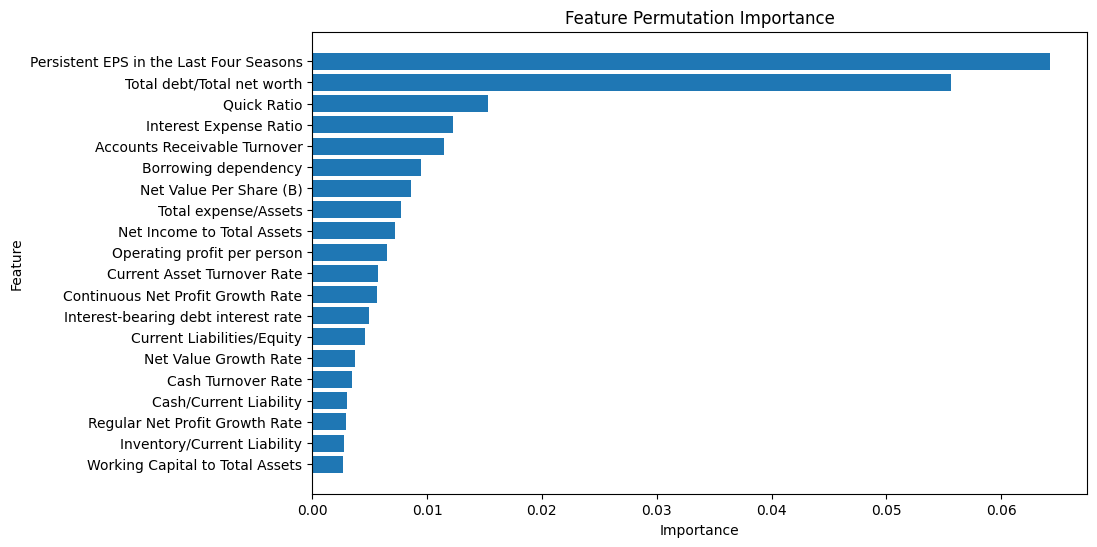

In [ ]:
plot_feat_permut_importance(gbt2_feat_permut_import_df)

In [ ]:
gbt2_perf, gbt2_orig_missing, gbt2_missing = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons']

--- NEW ITERATION ---
Removing feature:  Total debt/Total net worth
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Interest Expense Ratio
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth', 'Quick Ratio', 'Interest Expense Ratio']

--- NEW ITERATION ---
Removing feature:  Accounts Receivable Turnover
Original feat removed so far:  ['Persistent EPS in the Last Four Seasons', 'Total debt/Total net worth', 'Quick Ratio', 'Interest Expense Ratio', 'Accounts Receivable Turnover']

--- NEW ITERATION ---
Removing fea

In [ ]:
gbt2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1181  139   9      20.11   79.55        89.47     89.15     32.11   
1   22  1265   55  22      28.57   50.00        95.83     94.35     36.36   
2   13  1282   38  31      25.49   29.55        97.12     94.94     27.37   
3    4  1313    7  40      36.36    9.09        99.47     96.55     14.55   
4    2  1318    2  42      50.00    4.55        99.85     96.77      8.33   
5    1  1319    1  43      50.00    2.27        99.92     96.77      4.35   
6    0  1319    1  44       0.00    0.00        99.92     96.70      0.00   
7    0  1319    1  44       0.00    0.00        99.92     96.70      0.00   
8    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
9    0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
10   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.51                 0   
1               72.92                 1   
2               63.33                 2   
3               54.28                 3   
4               52.20                 4   
5               51.10                 5   
6               49.96                 6   
7               49.96                 7   
8               50.00                 8   
9               50.00                 9   
10              50.00                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'T...  
3   ['Persistent EPS in the Last Four Seasons', 'T...  
4   ['Persistent EPS in the Last Four Seasons', 'T...  
5   ['Persistent EPS in the Last Four Seasons', 'T...  
6   ['Persistent EPS in the Last Four Seasons', 'T...  
7   ['Persistent EPS in the Last Four Seasons', 'T...  
8   ['Persistent EPS in the Last Four Seasons', 'T...  
9   ['Persistent EPS in the Last Four Seasons', 'T...  
10  ['Persistent EPS in the Last Four Seasons', 'T...  
11  ['Persistent EPS in the Last Four Seasons', 'T...  
12  ['Persistent EPS in the Last Four Seasons', 'T...  
13  ['Persistent EPS in the Last Four Seasons', 'T...  
14  ['Persistent EPS in the Last Four Seasons', 'T...  
15  ['Persistent EPS in the Last Four Seasons', 'T...  
16  ['Persistent EPS in the Last Four Seasons', 'T...  
17  ['Persistent EPS in the Last Four Seasons', 'T...  
18  ['Persistent EPS in the Last Four Seasons', 'T...  
19  ['Persistent EPS in the Last Four Seasons', 'T...  
20  ['Persistent EPS in the Last Four Seasons', 'T...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

gbt2_perf_mf, gbt2_orig_missing_mf, gbt2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, gbt2_classifier, gbt2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 17:57:08.039683

--- NEW ITERATION ---
Removing feature:  Persistent EPS in the Last Four Seasons
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit G

In [ ]:
gbt2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   35  1181  139   9      20.11   79.55        89.47     89.15     32.11   
1   35  1182  138   9      20.23   79.55        89.55     89.22     32.26   
2   35  1178  142   9      19.77   79.55        89.24     88.93     31.67   
3   31  1222   98  13      24.03   70.45        92.58     91.86     35.84   
4   30  1225   95  14      24.00   68.18        92.80     92.01     35.50   
5   28  1233   87  16      24.35   63.64        93.41     92.45     35.22   
6   28  1233   87  16      24.35   63.64        93.41     92.45     35.22   
7   28  1236   84  16      25.00   63.64        93.64     92.67     35.90   
8   28  1237   83  16      25.23   63.64        93.71     92.74     36.13   
9   27  1238   82  17      24.77   61.36        93.79     92.74     35.29   
10  28  1238   82  16      25.45   63.64        93.79     92.82     36.36   
11  28  1235   85  16      24.78   63.64        93.56     92.60     35.67   
12  27  1235   85  17      24.11   61.36        93.56     92.52     34.62   
13  28  1201  119  16      19.05   63.64        90.98     90.10     29.32   
14  28  1199  121  16      18.79   63.64        90.83     89.96     29.02   
15  27  1219  101  17      21.09   61.36        92.35     91.35     31.40   
16  26  1230   90  18      22.41   59.09        93.18     92.08     32.50   
17  29  1209  111  15      20.71   65.91        91.59     90.76     31.52   
18  29  1211  109  15      21.01   65.91        91.74     90.91     31.87   
19  29  1213  107  15      21.32   65.91        91.89     91.06     32.22   
20  28  1219  101  16      21.71   63.64        92.35     91.42     32.37   

    balanced_accuracy  num_feat_missing  \
0               84.51                 0   
1               84.55                 1   
2               84.39                 2   
3               81.52                 3   
4               80.49                 4   
5               78.52                 5   
6               78.52                 6   
7               78.64                 7   
8               78.67                 8   
9               77.58                 9   
10              78.71                10   
11              78.60                11   
12              77.46                12   
13              77.31                13   
14              77.23                14   
15              76.86                15   
16              76.14                16   
17              78.75                17   
18              78.83                18   
19              78.90                19   
20              77.99                20   

                                              imputed  
0                                                      
1   ['Persistent EPS in the Last Four Seasons'] im...  
2   ['Persistent EPS in the Last Four Seasons', 'T...  
3   ['Persistent EPS in the Last Four Seasons', 'T...  
4   ['Persistent EPS in the Last Four Seasons', 'T...  
5   ['Persistent EPS in the Last Four Seasons', 'T...  
6   ['Persistent EPS in the Last Four Seasons', 'T...  
7   ['Persistent EPS in the Last Four Seasons', 'T...  
8   ['Persistent EPS in the Last Four Seasons', 'T...  
9   ['Persistent EPS in the Last Four Seasons', 'T...  
10  ['Persistent EPS in the Last Four Seasons', 'T...  
11  ['Persistent EPS in the Last Four Seasons', 'T...  
12  ['Persistent EPS in the Last Four Seasons', 'T...  
13  ['Persistent EPS in the Last Four Seasons', 'T...  
14  ['Persistent EPS in the Last Four Seasons', 'T...  
15  ['Persistent EPS in the Last Four Seasons', 'T...  
16  ['Persistent EPS in the Last Four Seasons', 'T...  
17  ['Persistent EPS in the Last Four Seasons', 'T...  
18  ['Persistent EPS in the Last Four Seasons', 'T...  
19  ['Persistent EPS in the Last Four Seasons', 'T...  
20  ['Persistent EPS in the Last Four Seasons', 'T...

## **XGBoost**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  xgb2_param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [2, 3, 5, None],
      'reg_lambda':[10.0, 5.0, 1.0, 0.5, 0],     # L2 regularization on weights
      'gamma': [1.0, 0.5, 0.1, 0.05, 0.0],       # Minimum loss reduction required for node splitting (default=0)
      'colsample_bytree':[0.25, 0.5, 0.75, 1.0]  # Fraction of features used for each tree
  }
else:
  # best model
  xgb2_param_grid = {
    'n_estimators': [100],
    'max_depth': [2],
    'reg_lambda':[10.0],
    'gamma': [1.0],
    'colsample_bytree':[0.25]
}

xgb2_classifier = XGBClassifier(
    scale_pos_weight=ratio_majority_minority, random_state=RANDOM_STATE, n_jobs=1
)
xgb2_grid_search, xgb2_best_model, xgb2_best_params = hyperparameter_tuning(
    xgb2_classifier, xgb2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 18:12:09.219629

Nested Cross-validation Results:
Individual scores: [0.83069626 0.84767829 0.77585974]
Average nested CV score: 0.818 (+/- 0.061)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2, 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.818
2025-01-16 18:12:16.313857

Execution time: 0.12 minutes


In [ ]:
xgb2_best_params

{'colsample_bytree': 0.25,
 'gamma': 1.0,
 'max_depth': 2,
 'n_estimators': 100,
 'reg_lambda': 10.0}

```
Starting hyperparameter tuning at: 2025-01-13 02:23:36.833708

Nested Cross-validation Results:
Individual scores: [0.6409428  0.64456309 0.64037252]
Average nested CV score: 0.642 (+/- 0.004)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 5.0}

Best Model Performance:
Best CV score: 0.667

Train score: 1.000
Test score: 0.667
Train-test score difference: 0.333
2025-01-13 02:45:25.416343

Execution time: 21.81 minutes
---
WITH SCALE_POS_WEIGHT
Starting hyperparameter tuning at: 2025-01-15 21:40:57.357906

Nested Cross-validation Results:
Individual scores: [0.78377793 0.79538597 0.7707432 ]
Average nested CV score: 0.783 (+/- 0.020)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1200 candidates, totalling 3600 fits
Best parameters: {'colsample_bytree': 0.25, 'gamma': 1.0, 'max_depth': 2 'n_estimators': 100, 'reg_lambda': 10.0}

Best Model Performance:
Best CV score: 0.799
2025-01-13 22:04:32.037175

Execution time: 23.58 minutes
```


In [ ]:
xgb2_classifier, xgb2_train_pred, xgb2_test_pred = apply_model(xgb2_best_model, X_train, y_train, X_test, y_test)
xgb2_feat_permut_import_df = analyze_feat_permut_import(xgb2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
xgb2_feat_permut_import_df[xgb2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
13          Interest-bearing debt interest rate    0.009318  0.004471
33                                  Quick Ratio    0.008957  0.003885
58                       Cash/Current Liability    0.004300  0.001447
27            Continuous Net Profit Growth Rate    0.003352  0.004613
89           Net Income to Stockholder's Equity    0.002974  0.000455
..                                          ...         ...       ...
1        ROA(A) before interest and % after tax   -0.002841  0.000268
8   Non-industry income and expenditure/revenue   -0.003220  0.000529
29                        Net Value Growth Rate   -0.003599  0.000323
35                   Total debt/Total net worth   -0.005152  0.000451
39                         Borrowing dependency   -0.006706  0.000193

[79 rows x 3 columns]

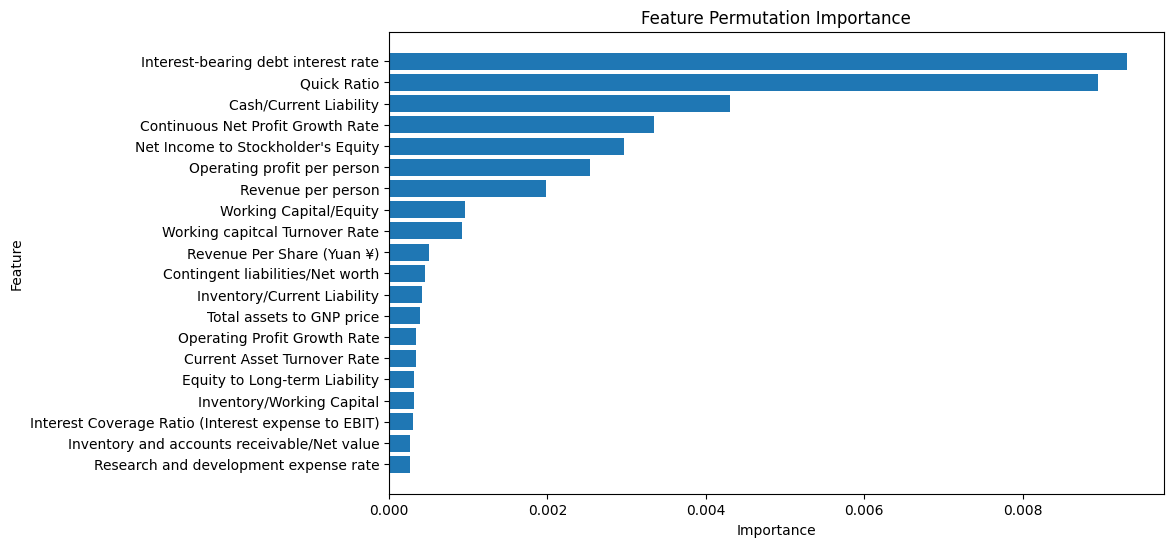

In [ ]:
plot_feat_permut_importance(xgb2_feat_permut_import_df)

In [ ]:
xgb2_perf, xgb2_orig_missing, xgb2_missing = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Original feat removed so far:  ['Interest-bearing debt interest rate']

--- NEW ITERATION ---
Removing feature:  Quick Ratio
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Quick Ratio']

--- NEW ITERATION ---
Removing feature:  Cash/Current Liability
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Quick Ratio', 'Cash/Current Liability']

--- NEW ITERATION ---
Removing feature:  Continuous Net Profit Growth Rate
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Quick Ratio', 'Cash/Current Liability', 'Continuous Net Profit Growth Rate']

--- NEW ITERATION ---
Removing feature:  Net Income to Stockholder's Equity
Original feat removed so far:  ['Interest-bearing debt interest rate', 'Quick Ratio', 'Cash/Current Liability', 'Continuous Net Profit Growth Rate', "Net Income to Stockholder's Equity"]

--- NEW ITERATION ---
Removing feature:  Ope

In [ ]:
xgb2_perf

tp    tn  fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1240  80  17      25.23   61.36        93.94     92.89     35.76   
1   22  1266  54  22      28.95   50.00        95.91     94.43     36.67   
2   17  1287  33  27      34.00   38.64        97.50     95.60     36.17   
3   21  1275  45  23      31.82   47.73        96.59     95.01     38.18   
4   22  1285  35  22      38.60   50.00        97.35     95.82     43.56   
5   22  1270  50  22      30.56   50.00        96.21     94.72     37.93   
6   21  1272  48  23      30.43   47.73        96.36     94.79     37.17   
7   21  1266  54  23      28.00   47.73        95.91     94.35     35.29   
8   21  1263  57  23      26.92   47.73        95.68     94.13     34.43   
9   23  1259  61  21      27.38   52.27        95.38     93.99     35.94   
10  24  1256  64  20      27.27   54.55        95.15     93.84     36.36   
11  24  1254  66  20      26.67   54.55        95.00     93.70     35.82   
12  24  1254  66  20      26.67   54.55        95.00     93.70     35.82   
13  22  1260  60  22      26.83   50.00        95.45     93.99     34.92   
14  22  1256  64  22      25.58   50.00        95.15     93.70     33.85   
15  22  1261  59  22      27.16   50.00        95.53     94.06     35.20   
16  23  1260  60  21      27.71   52.27        95.45     94.06     36.22   
17  23  1262  58  21      28.40   52.27        95.61     94.21     36.80   
18  23  1263  57  21      28.75   52.27        95.68     94.28     37.10   
19  23  1265  55  21      29.49   52.27        95.83     94.43     37.70   
20  23  1265  55  21      29.49   52.27        95.83     94.43     37.70   

    balanced_accuracy  num_feat_missing  \
0               77.65                 0   
1               72.95                 1   
2               68.07                 2   
3               72.16                 3   
4               73.67                 4   
5               73.11                 5   
6               72.05                 6   
7               71.82                 7   
8               71.70                 8   
9               73.83                 9   
10              74.85                10   
11              74.77                11   
12              74.77                12   
13              72.73                13   
14              72.58                14   
15              72.77                15   
16              73.86                16   
17              73.94                17   
18              73.98                18   
19              74.05                19   
20              74.05                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Quick...  
3   ['Interest-bearing debt interest rate', 'Quick...  
4   ['Interest-bearing debt interest rate', 'Quick...  
5   ['Interest-bearing debt interest rate', 'Quick...  
6   ['Interest-bearing debt interest rate', 'Quick...  
7   ['Interest-bearing debt interest rate', 'Quick...  
8   ['Interest-bearing debt interest rate', 'Quick...  
9   ['Interest-bearing debt interest rate', 'Quick...  
10  ['Interest-bearing debt interest rate', 'Quick...  
11  ['Interest-bearing debt interest rate', 'Quick...  
12  ['Interest-bearing debt interest rate', 'Quick...  
13  ['Interest-bearing debt interest rate', 'Quick...  
14  ['Interest-bearing debt interest rate', 'Quick...  
15  ['Interest-bearing debt interest rate', 'Quick...  
16  ['Interest-bearing debt interest rate', 'Quick...  
17  ['Interest-bearing debt interest rate', 'Quick...  
18  ['Interest-bearing debt interest rate', 'Quick...  
19  ['Interest-bearing debt interest rate', 'Quick...  
20  ['Interest-bearing debt interest rate', 'Quick...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

xgb2_perf_mf, xgb2_orig_missing_mf, xgb2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, xgb2_classifier, xgb2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 18:12:22.236711

--- NEW ITERATION ---
Removing feature:  Interest-bearing debt interest rate
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growt

In [ ]:
xgb2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   27  1240   80  17      25.23   61.36        93.94     92.89     35.76   
1   30  1221   99  14      23.26   68.18        92.50     91.72     34.68   
2   25  1251   69  19      26.60   56.82        94.77     93.55     36.23   
3   29  1232   88  15      24.79   65.91        93.33     92.45     36.02   
4   29  1230   90  15      24.37   65.91        93.18     92.30     35.58   
5   29  1230   90  15      24.37   65.91        93.18     92.30     35.58   
6   29  1231   89  15      24.58   65.91        93.26     92.38     35.80   
7   29  1223   97  15      23.02   65.91        92.65     91.79     34.12   
8   29  1223   97  15      23.02   65.91        92.65     91.79     34.12   
9   29  1225   95  15      23.39   65.91        92.80     91.94     34.52   
10  29  1223   97  15      23.02   65.91        92.65     91.79     34.12   
11  28  1224   96  16      22.58   63.64        92.73     91.79     33.33   
12  29  1230   90  15      24.37   65.91        93.18     92.30     35.58   
13  29  1223   97  15      23.02   65.91        92.65     91.79     34.12   
14  30  1219  101  14      22.90   68.18        92.35     91.57     34.29   
15  29  1222   98  15      22.83   65.91        92.58     91.72     33.92   
16  28  1222   98  16      22.22   63.64        92.58     91.64     32.94   
17  28  1223   97  16      22.40   63.64        92.65     91.72     33.14   
18  27  1221   99  17      21.43   61.36        92.50     91.50     31.76   
19  28  1221   99  16      22.05   63.64        92.50     91.57     32.75   
20  28  1224   96  16      22.58   63.64        92.73     91.79     33.33   

    balanced_accuracy  num_feat_missing  \
0               77.65                 0   
1               80.34                 1   
2               75.80                 2   
3               79.62                 3   
4               79.55                 4   
5               79.55                 5   
6               79.58                 6   
7               79.28                 7   
8               79.28                 8   
9               79.36                 9   
10              79.28                10   
11              78.18                11   
12              79.55                12   
13              79.28                13   
14              80.27                14   
15              79.24                15   
16              78.11                16   
17              78.14                17   
18              76.93                18   
19              78.07                19   
20              78.18                20   

                                              imputed  
0                                                      
1     ['Interest-bearing debt interest rate'] imputed  
2   ['Interest-bearing debt interest rate', 'Quick...  
3   ['Interest-bearing debt interest rate', 'Quick...  
4   ['Interest-bearing debt interest rate', 'Quick...  
5   ['Interest-bearing debt interest rate', 'Quick...  
6   ['Interest-bearing debt interest rate', 'Quick...  
7   ['Interest-bearing debt interest rate', 'Quick...  
8   ['Interest-bearing debt interest rate', 'Quick...  
9   ['Interest-bearing debt interest rate', 'Quick...  
10  ['Interest-bearing debt interest rate', 'Quick...  
11  ['Interest-bearing debt interest rate', 'Quick...  
12  ['Interest-bearing debt interest rate', 'Quick...  
13  ['Interest-bearing debt interest rate', 'Quick...  
14  ['Interest-bearing debt interest rate', 'Quick...  
15  ['Interest-bearing debt interest rate', 'Quick...  
16  ['Interest-bearing debt interest rate', 'Quick...  
17  ['Interest-bearing debt interest rate', 'Quick...  
18  ['Interest-bearing debt interest rate', 'Quick...  
19  ['Interest-bearing debt interest rate', 'Quick...  
20  ['Interest-bearing debt interest rate', 'Quick...

## **Extra Trees Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  et2_param_grid = {
      'n_estimators': [100, 200, 300, 500],
      'max_depth': [2, 3, 5, None],
      'max_features':['sqrt', 0.5, 1.0],
      'min_samples_split': [0.005, 0.001, 2],
      'min_samples_leaf': [0.005, 0.001, 1]
  }
else:
  et2_param_grid = {
      'n_estimators': [100],
      'max_depth': [5],
      'max_features':['sqrt'],
      'min_samples_split': [0.001],
      'min_samples_leaf': [1]
  }

et2_classifier = ExtraTreesClassifier(class_weight='balanced', random_state=RANDOM_STATE)
et2_grid_search, et2_best_model, et2_best_params = hyperparameter_tuning(
    et2_classifier, et2_param_grid, 3, 3, 'balanced_accuracy', X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 19:16:59.551346

Nested Cross-validation Results:
Individual scores: [0.86998748 0.90614224 0.87085786]
Average nested CV score: 0.882 (+/- 0.034)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.001, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.882
2025-01-16 19:17:01.286256

Execution time: 0.03 minutes




```
Starting hyperparameter tuning at: 2025-01-15 20:19:13.851675

Nested Cross-validation Results:
Individual scores: [0.85360651 0.88918495 0.8402646 ]
Average nested CV score: 0.861 (+/- 0.041)

Fitting final model on entire dataset...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.001, 'n_estimators': 100}

Best Model Performance:
Best CV score: 0.882
2025-01-15 20:40:14.890204

Execution time: 21.02 minutes
```



In [ ]:
# et2_grid_search.cv_results_

In [ ]:
et2_classifier, train_pred, test_pred = apply_model(et2_best_model, X_train, y_train, X_test, y_test)
et2_feat_permut_import_df = analyze_feat_permut_import(et2_classifier, X_train, y_train, scoring_metric="balanced_accuracy")
et2_feat_permut_import_df[et2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
36                              Debt ratio %    0.010358  0.005881
56                         Cash/Total Assets    0.006571  0.003192
39                      Borrowing dependency    0.005492  0.002169
59               Current Liability to Assets    0.005417  0.002224
65                Current Liabilities/Equity    0.004943  0.002328
..                                       ...         ...       ...
48           Fixed Assets Turnover Frequency   -0.002026  0.002195
17                   Net Value Per Share (C)   -0.002311  0.001498
22  Per Share Net profit before tax (Yuan ¥)   -0.002482  0.000243
1     ROA(A) before interest and % after tax   -0.002482  0.002060
85                Net Income to Total Assets   -0.003770  0.001870

[89 rows x 3 columns]

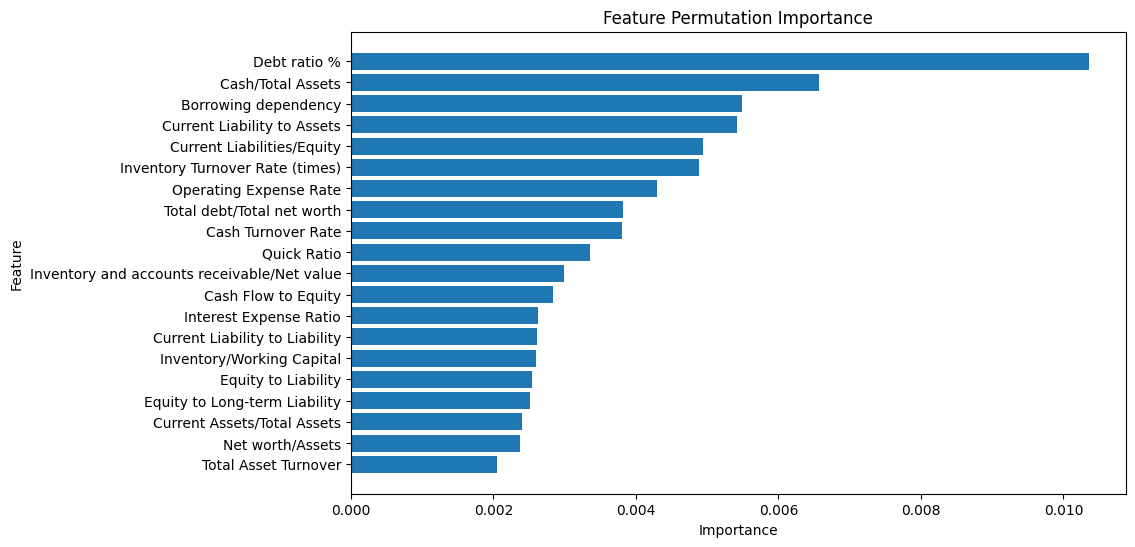

In [ ]:
plot_feat_permut_importance(et2_feat_permut_import_df)

In [ ]:
et2_perf, et2_orig_missing, et2_missing = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Debt ratio %
Original feat removed so far:  ['Debt ratio %']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Debt ratio %', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Debt ratio %', 'Cash/Total Assets', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Current Liability to Assets
Original feat removed so far:  ['Debt ratio %', 'Cash/Total Assets', 'Borrowing dependency', 'Current Liability to Assets']

--- NEW ITERATION ---
Removing feature:  Current Liabilities/Equity
Original feat removed so far:  ['Debt ratio %', 'Cash/Total Assets', 'Borrowing dependency', 'Current Liability to Assets', 'Current Liabilities/Equity']

--- NEW ITERATION ---
Removing feature:  Inventory Turnover Rate (times)
Original feat removed so far:  ['Debt ratio %', 'Cash/Total Assets', 'Borrowing dependency', 'Current Liability to Assets

In [ ]:
et2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  1138  182   6      17.27   86.36        86.21     86.22     28.79   
1   34  1176  144  10      19.10   77.27        89.09     88.71     30.63   
2   33  1174  146  11      18.44   75.00        88.94     88.49     29.60   
3   33  1183  137  11      19.41   75.00        89.62     89.15     30.84   
4   32  1189  131  12      19.63   72.73        90.08     89.52     30.92   
5   29  1197  123  15      19.08   65.91        90.68     89.88     29.59   
6   29  1198  122  15      19.21   65.91        90.76     89.96     29.74   
7   28  1197  123  16      18.54   63.64        90.68     89.81     28.72   
8   27  1204  116  17      18.88   61.36        91.21     90.25     28.88   
9   27  1207  113  17      19.29   61.36        91.44     90.47     29.35   
10  27  1208  112  17      19.42   61.36        91.52     90.54     29.51   
11  27  1208  112  17      19.42   61.36        91.52     90.54     29.51   
12  27  1207  113  17      19.29   61.36        91.44     90.47     29.35   
13  27  1207  113  17      19.29   61.36        91.44     90.47     29.35   
14  27  1207  113  17      19.29   61.36        91.44     90.47     29.35   
15  27  1207  113  17      19.29   61.36        91.44     90.47     29.35   
16  25  1206  114  19      17.99   56.82        91.36     90.25     27.32   
17  25  1207  113  19      18.12   56.82        91.44     90.32     27.47   
18  25  1203  117  19      17.61   56.82        91.14     90.03     26.88   
19  24  1211  109  20      18.05   54.55        91.74     90.54     27.12   
20  24  1211  109  20      18.05   54.55        91.74     90.54     27.12   

    balanced_accuracy  num_feat_missing  \
0               86.29                 0   
1               83.18                 1   
2               81.97                 2   
3               82.31                 3   
4               81.40                 4   
5               78.30                 5   
6               78.33                 6   
7               77.16                 7   
8               76.29                 8   
9               76.40                 9   
10              76.44                10   
11              76.44                11   
12              76.40                12   
13              76.40                13   
14              76.40                14   
15              76.40                15   
16              74.09                16   
17              74.13                17   
18              73.98                18   
19              73.14                19   
20              73.14                20   

                                              imputed  
0                                                      
1                            ['Debt ratio %'] imputed  
2       ['Debt ratio %', 'Cash/Total Assets'] imputed  
3   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
4   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
5   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
6   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
7   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
8   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
9   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
10  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
11  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
12  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
13  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
14  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
15  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
16  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
17  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
18  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
19  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
20  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

et2_perf_mf, et2_orig_missing_mf, et2_missing_mf = measure_performance_decline(
    X_train, X_test, y_test, et2_classifier, et2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 19:17:16.713245

--- NEW ITERATION ---
Removing feature:  Debt ratio %
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-tax Net

In [ ]:
et2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   38  1138  182   6      17.27   86.36        86.21     86.22     28.79   
1   38  1140  180   6      17.43   86.36        86.36     86.36     29.01   
2   38  1143  177   6      17.67   86.36        86.59     86.58     29.34   
3   37  1142  178   7      17.21   84.09        86.52     86.44     28.57   
4   37  1146  174   7      17.54   84.09        86.82     86.73     29.02   
5   37  1151  169   7      17.96   84.09        87.20     87.10     29.60   
6   37  1148  172   7      17.70   84.09        86.97     86.88     29.25   
7   37  1147  173   7      17.62   84.09        86.89     86.80     29.13   
8   37  1148  172   7      17.70   84.09        86.97     86.88     29.25   
9   37  1146  174   7      17.54   84.09        86.82     86.73     29.02   
10  36  1145  175   8      17.06   81.82        86.74     86.58     28.24   
11  36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
12  36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
13  36  1147  173   8      17.22   81.82        86.89     86.73     28.46   
14  36  1145  175   8      17.06   81.82        86.74     86.58     28.24   
15  36  1147  173   8      17.22   81.82        86.89     86.73     28.46   
16  35  1162  158   9      18.13   79.55        88.03     87.76     29.54   
17  35  1165  155   9      18.42   79.55        88.26     87.98     29.91   
18  35  1167  153   9      18.62   79.55        88.41     88.12     30.17   
19  32  1186  134  12      19.28   72.73        89.85     89.30     30.48   
20  32  1188  132  12      19.51   72.73        90.00     89.44     30.77   

    balanced_accuracy  num_feat_missing  \
0               86.29                 0   
1               86.36                 1   
2               86.48                 2   
3               85.30                 3   
4               85.45                 4   
5               85.64                 5   
6               85.53                 6   
7               85.49                 7   
8               85.53                 8   
9               85.45                 9   
10              84.28                10   
11              84.39                11   
12              84.39                12   
13              84.36                13   
14              84.28                14   
15              84.36                15   
16              83.79                16   
17              83.90                17   
18              83.98                18   
19              81.29                19   
20              81.36                20   

                                              imputed  
0                                                      
1                            ['Debt ratio %'] imputed  
2       ['Debt ratio %', 'Cash/Total Assets'] imputed  
3   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
4   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
5   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
6   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
7   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
8   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
9   ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
10  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
11  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
12  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
13  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
14  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
15  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
16  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
17  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
18  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
19  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  
20  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...

##**Support Vector Classifier**

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  svm2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],
      'kernel': ['linear', 'poly', 'rbf'],
      'gamma': ['scale', 0.1, 0.5, 1, 2],
      'degree': [2, 3, 4, 5]
  }
else:
  # best model
  svm2_param_grid = {
    'C': [2.0],
    'kernel': ['poly'],
    'gamma': [0.1],
    'degree': [2]
}

svm2_classifier = SVC(class_weight='balanced', random_state=RANDOM_STATE)
svm2_grid_search, svm2_best_model, svm2_best_params = hyperparameter_tuning(
    svm2_classifier, svm2_param_grid, 3, 3, 'balanced_accuracy', X_train_scaled, y_train
)

Starting hyperparameter tuning at: 2025-01-16 19:32:34.894523

Nested Cross-validation Results:
Individual scores: [0.83717739 0.88558973 0.84111735]
Average nested CV score: 0.855 (+/- 0.044)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 2.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.855
2025-01-16 19:32:44.584994

Execution time: 0.16 minutes




```
Starting hyperparameter tuning at: 2025-01-15 20:40:14.899037

Nested Cross-validation Results:
Individual scores: [0.83883378 0.86806426 0.8354323 ]
Average nested CV score: 0.847 (+/- 0.029)

Fitting final model on entire dataset...
Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters: {'C': 2, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}

Best Model Performance:
Best CV score: 0.855
2025-01-15 20:45:53.173746

Execution time: 5.64 minutes
```



In [ ]:
svm2_classifier, train_pred, test_pred = apply_model(svm2_best_model, X_train_scaled, y_train, X_test_scaled, y_test)
svm2_feat_permut_import_df = analyze_feat_permut_import(svm2_classifier, X_train_scaled, y_train, scoring_metric="balanced_accuracy")
svm2_feat_permut_import_df[svm2_feat_permut_import_df['Importance']!=0]

Feature  Importance       Std
37                   Net worth/Assets    0.019278  0.007455
36                       Debt ratio %    0.014638  0.007998
56                  Cash/Total Assets    0.013086  0.010058
44               Total Asset Turnover    0.008977  0.004619
73                 Cash Turnover Rate    0.008864  0.004274
..                                ...         ...       ...
85         Net Income to Total Assets   -0.002065  0.002706
16            Net Value Per Share (A)   -0.002140  0.001313
15            Net Value Per Share (B)   -0.002216  0.001343
67  Retained Earnings to Total Assets   -0.003315  0.001358
49    Net Worth Turnover Rate (times)   -0.003977  0.002072

[76 rows x 3 columns]

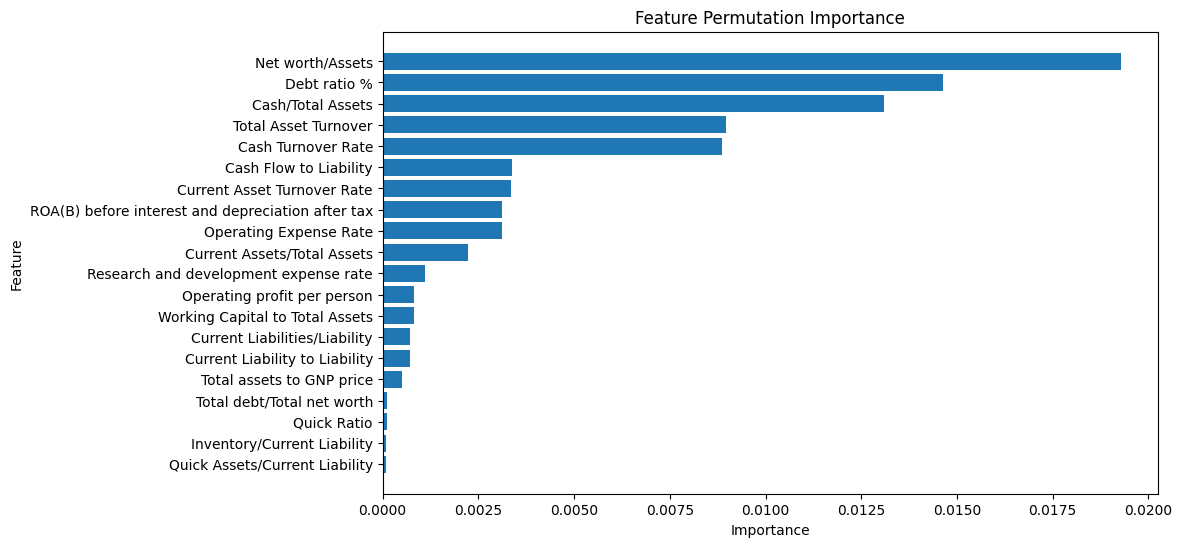

In [ ]:
plot_feat_permut_importance(svm2_feat_permut_import_df)

In [ ]:
svm2_perf, svm2_orig_missing, svm2_missing = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    taiwan_imputation_scaled_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Net worth/Assets
Original feat removed so far:  ['Net worth/Assets']

--- NEW ITERATION ---
Removing feature:  Debt ratio %
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Cash/Total Assets', 'Total Asset Turnover']

--- NEW ITERATION ---
Removing feature:  Cash Turnover Rate
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Cash/Total Assets', 'Total Asset Turnover', 'Cash Turnover Rate']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Net worth/Assets', 'Debt ratio %', 'Cash/Total Assets', 'Total Asset Turnover', 'Cash Turnover Rate', 'Cash Flow to Liability']

--- NEW ITERATION 

In [ ]:
svm2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1141  179   8      16.74   81.82        86.44     86.29     27.80   
1   33  1189  131  11      20.12   75.00        90.08     89.59     31.73   
2   24  1208  112  20      17.65   54.55        91.52     90.32     26.67   
3   24  1209  111  20      17.78   54.55        91.59     90.40     26.82   
4   24  1223   97  20      19.83   54.55        92.65     91.42     29.09   
5   25  1207  113  19      18.12   56.82        91.44     90.32     27.47   
6   25  1209  111  19      18.38   56.82        91.59     90.47     27.78   
7   27  1208  112  17      19.42   61.36        91.52     90.54     29.51   
8   22  1243   77  22      22.22   50.00        94.17     92.74     30.77   
9   23  1241   79  21      22.55   52.27        94.02     92.67     31.51   
10  26  1222   98  18      20.97   59.09        92.58     91.50     30.95   
11  26  1225   95  18      21.49   59.09        92.80     91.72     31.52   
12  25  1228   92  19      21.37   56.82        93.03     91.86     31.06   
13  21  1245   75  23      21.88   47.73        94.32     92.82     30.00   
14  21  1246   74  23      22.11   47.73        94.39     92.89     30.22   
15  20  1247   73  24      21.51   45.45        94.47     92.89     29.20   
16  20  1247   73  24      21.51   45.45        94.47     92.89     29.20   
17  20  1247   73  24      21.51   45.45        94.47     92.89     29.20   
18  20  1247   73  24      21.51   45.45        94.47     92.89     29.20   
19  20  1248   72  24      21.74   45.45        94.55     92.96     29.41   
20  20  1248   72  24      21.74   45.45        94.55     92.96     29.41   

    balanced_accuracy  num_feat_missing  \
0               84.13                 0   
1               82.54                 1   
2               73.03                 2   
3               73.07                 3   
4               73.60                 4   
5               74.13                 5   
6               74.20                 6   
7               76.44                 7   
8               72.08                 8   
9               73.14                 9   
10              75.83                10   
11              75.95                11   
12              74.92                12   
13              71.02                13   
14              71.06                14   
15              69.96                15   
16              69.96                16   
17              69.96                17   
18              69.96                18   
19              70.00                19   
20              70.00                20   

                                              imputed  
0                                                      
1                        ['Net worth/Assets'] imputed  
2        ['Net worth/Assets', 'Debt ratio %'] imputed  
3   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
4   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
5   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
6   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
7   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
8   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
9   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
10  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
11  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
12  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
13  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
14  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
15  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
16  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
17  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
18  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
19  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
20  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

svm2_perf_mf, svm2_orig_missing_mf, svm2_missing_mf = measure_performance_decline(
    X_train_scaled, X_test_scaled, y_test, svm2_classifier, svm2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 18:43:51.557468

--- NEW ITERATION ---
Removing feature:  Net worth/Assets
Nr. columns with nan:  1
Numerical columns:  ['ROA(C) before interest and depreciation before interest', 'ROA(A) before interest and % after tax', 'ROA(B) before interest and depreciation after tax', 'Operating Gross Margin', 'Realized Sales Gross Margin', 'Operating Profit Rate', 'Pre-tax net Interest Rate', 'After-tax net Interest Rate', 'Non-industry income and expenditure/revenue', 'Continuous interest rate (after tax)', 'Operating Expense Rate', 'Research and development expense rate', 'Cash flow rate', 'Interest-bearing debt interest rate', 'Tax rate (A)', 'Net Value Per Share (B)', 'Net Value Per Share (A)', 'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons', 'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)', 'Operating Profit Per Share (Yuan ¥)', 'Per Share Net profit before tax (Yuan ¥)', 'Realized Sales Gross Profit Growth Rate', 'Operating Profit Growth Rate', 'After-tax

In [ ]:
svm2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1141  179   8      16.74   81.82        86.44     86.29     27.80   
1   36  1143  177   8      16.90   81.82        86.59     86.44     28.02   
2   34  1154  166  10      17.00   77.27        87.42     87.10     27.87   
3   34  1156  164  10      17.17   77.27        87.58     87.24     28.10   
4   34  1161  159  10      17.62   77.27        87.95     87.61     28.69   
5   34  1170  150  10      18.48   77.27        88.64     88.27     29.82   
6   33  1171  149  11      18.13   75.00        88.71     88.27     29.20   
7   35  1165  155   9      18.42   79.55        88.26     87.98     29.91   
8   35  1164  156   9      18.32   79.55        88.18     87.90     29.79   
9   33  1165  155  11      17.55   75.00        88.26     87.83     28.45   
10  33  1165  155  11      17.55   75.00        88.26     87.83     28.45   
11  34  1164  156  10      17.89   77.27        88.18     87.83     29.06   
12  35  1167  153   9      18.62   79.55        88.41     88.12     30.17   
13  34  1166  154  10      18.09   77.27        88.33     87.98     29.31   
14  34  1165  155  10      17.99   77.27        88.26     87.90     29.18   
15  34  1168  152  10      18.28   77.27        88.48     88.12     29.57   
16  34  1167  153  10      18.18   77.27        88.41     88.05     29.44   
17  34  1168  152  10      18.28   77.27        88.48     88.12     29.57   
18  34  1168  152  10      18.28   77.27        88.48     88.12     29.57   
19  34  1168  152  10      18.28   77.27        88.48     88.12     29.57   
20  34  1168  152  10      18.28   77.27        88.48     88.12     29.57   

    balanced_accuracy  num_feat_missing  \
0               84.13                 0   
1               84.20                 1   
2               82.35                 2   
3               82.42                 3   
4               82.61                 4   
5               82.95                 5   
6               81.86                 6   
7               83.90                 7   
8               83.86                 8   
9               81.63                 9   
10              81.63                10   
11              82.73                11   
12              83.98                12   
13              82.80                13   
14              82.77                14   
15              82.88                15   
16              82.84                16   
17              82.88                17   
18              82.88                18   
19              82.88                19   
20              82.88                20   

                                              imputed  
0                                                      
1                        ['Net worth/Assets'] imputed  
2        ['Net worth/Assets', 'Debt ratio %'] imputed  
3   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
4   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
5   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
6   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
7   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
8   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
9   ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
10  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
11  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
12  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
13  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
14  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
15  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
16  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
17  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
18  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
19  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...  
20  ['Net worth/Assets', 'Debt ratio %', 'Cash/Tot...

##**Logistic Regression**

In [ ]:
len(lr_X_test.columns)

61

In [ ]:
FINE_TUNE = False

if FINE_TUNE:
  lr2_param_grid = {
      'C': [0.1, 1, 2, 5, 10, 20],            # Regularization strength
      'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization type
      'solver': ['liblinear', 'saga']         # Algorithm to use in the optimization problem
  }
else:
  lr2_param_grid = {
      'C': [5.0],
      'penalty': ['l1'],
      'solver': ['liblinear']
  }

lr2_classifier = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
lr2_grid_search, lr2_best_model, lr2_best_params = hyperparameter_tuning(
    lr2_classifier, lr2_param_grid, 3, 3, 'balanced_accuracy', lr_X_train, y_train
)

Starting hyperparameter tuning at: 2025-01-16 18:57:01.440024

Nested Cross-validation Results:
Individual scores: [0.83490466 0.85802312 0.81995741]
Average nested CV score: 0.838 (+/- 0.031)

Fitting final model on entire dataset...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'C': 5.0, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.838
2025-01-16 18:58:28.229358

Execution time: 1.45 minutes




```
Starting hyperparameter tuning at: 2025-01-15 20:45:53.187247

Nested Cross-validation Results:
Individual scores: [0.83121148 0.8304565  0.81739914]
Average nested CV score: 0.826 (+/- 0.013)

Fitting final model on entire dataset...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

Best Model Performance:
Best CV score: 0.838
2025-01-15 20:48:08.607907

Execution time: 2.26 minutes
```



In [ ]:
lr2_classifier, train_pred, test_pred = apply_model(lr2_best_model, lr_X_train, y_train, lr_X_test, y_test)
lr2_feat_permut_import_df = analyze_feat_permut_import(lr2_classifier, lr_X_train, y_train, scoring_metric="balanced_accuracy")
lr2_feat_permut_import_df[lr2_feat_permut_import_df['Importance']!=0]

Feature    Importance       Std
11                          Equity to Liability  1.011160e-01  0.018673
1                          Borrowing dependency  3.499802e-02  0.005016
23                            Cash/Total Assets  3.293388e-02  0.007631
20                         Total expense/Assets  2.199000e-02  0.000780
32                       Cash Flow to Liability  2.049275e-02  0.004405
29                         Total Asset Turnover  1.823897e-02  0.007316
2             Retained Earnings to Total Assets  1.486637e-02  0.002990
5                       Net Value Per Share (A)  9.752299e-03  0.009680
14                        Liability-Assets Flag  9.034188e-03  0.000097
50               Current Liability to Liability  6.705493e-03  0.002916
43                           Cash Turnover Rate  6.553518e-03  0.006969
27                          Cash Flow to Equity  5.739508e-03  0.003359
28                    Quick Assets/Total Assets  5.568591e-03  0.001884
17                                CFO to Assets  4.620904e-03  0.003250
19  Inventory and accounts receivable/Net value  3.201472e-03  0.002786
49              Inventory Turnover Rate (times)  3.106434e-03  0.002787
46                   Total debt/Total net worth  3.106111e-03  0.000093
34                      Total Asset Growth Rate  2.973618e-03  0.003094
33           Degree of Financial Leverage (DFL)  2.575707e-03  0.000071
9                   Operating profit per person  2.537821e-03  0.003580
10                Equity to Long-term Liability  2.234841e-03  0.001266
52                       Operating Expense Rate  1.704653e-03  0.003200
8           Operating Profit Per Share (Yuan ¥)  1.268103e-03  0.001962
47                    Total assets to GNP price  1.212136e-03  0.001369
48          Interest-bearing debt interest rate  9.468262e-04  0.001449
15                       Operating Gross Margin  9.466109e-04  0.002139
55                 Accounts Receivable Turnover  9.091555e-04  0.001062
39         Long-term fund suitability ratio (A)  6.251184e-04  0.000176
12                                 Tax rate (A)  6.060678e-04  0.002908
53                  Current Asset Turnover Rate  4.167456e-04  0.000114
37                 Operating Profit Growth Rate  2.083728e-04  0.000093
57                  Inventory/Current Liability  1.515439e-04  0.000128
58                   Revenue Per Share (Yuan ¥)  9.471491e-05  0.000000
6          Continuous interest rate (after tax)  9.471491e-05  0.000104
16                       Interest Expense Ratio  7.577193e-05  0.000038
26                           No-credit Interval  7.577193e-05  0.000110
59               Quick Assets/Current Liability  5.682894e-05  0.000046
40                           Revenue per person  5.682894e-05  0.000046
25                    Inventory/Working Capital  1.894298e-05  0.000250
24             After-tax Net Profit Growth Rate  2.220446e-17  0.000060
56                      Average Collection Days -7.577193e-05  0.000071
51                   Allocation rate per person -9.471491e-05  0.000060
42        Research and development expense rate -3.029801e-04  0.000994
31              Fixed Assets Turnover Frequency -6.064983e-04  0.001784
45                    Quick Asset Turnover Rate -8.333836e-04  0.002967
21                       Cash/Current Liability -1.344736e-03  0.002273

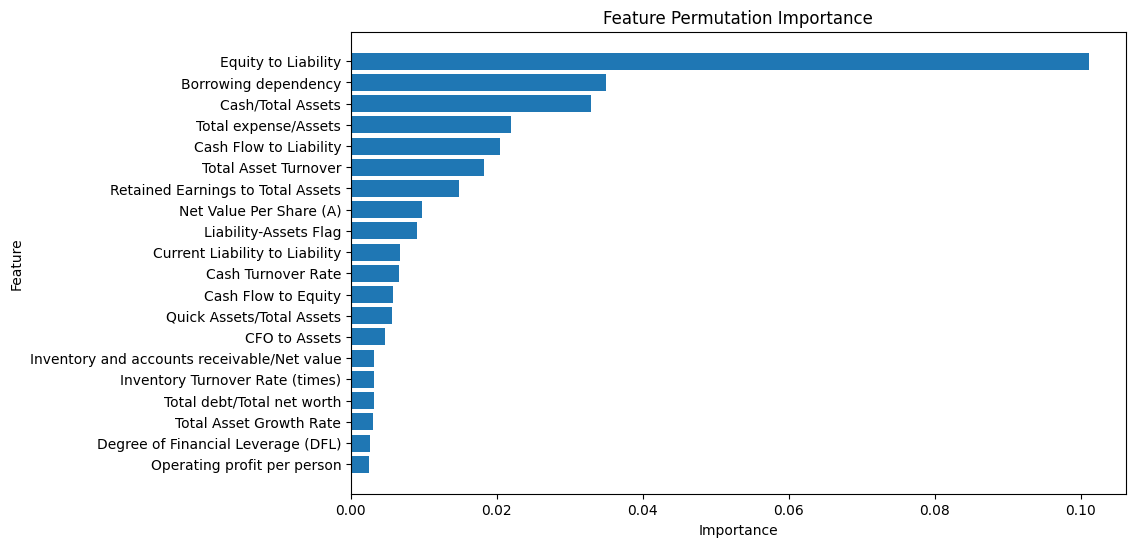

In [ ]:
plot_feat_permut_importance(lr2_feat_permut_import_df)

In [ ]:
lr2_perf, lr2_orig_missing, lr2_missing = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    taiwan_imputation_values_dict, num_feat=20, method='simple'
)


--- NEW ITERATION ---
Removing feature:  Equity to Liability
Original feat removed so far:  ['Equity to Liability']

--- NEW ITERATION ---
Removing feature:  Borrowing dependency
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency']

--- NEW ITERATION ---
Removing feature:  Cash/Total Assets
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets']

--- NEW ITERATION ---
Removing feature:  Total expense/Assets
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets', 'Total expense/Assets']

--- NEW ITERATION ---
Removing feature:  Cash Flow to Liability
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets', 'Total expense/Assets', 'Cash Flow to Liability']

--- NEW ITERATION ---
Removing feature:  Total Asset Turnover
Original feat removed so far:  ['Equity to Liability', 'Borrowing dependency', 'Cash/Total Assets', 'Total expense/A

In [ ]:
lr2_perf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
2   23  1190  130  21      15.03   52.27        90.15     88.93     23.35   
3   22  1188  132  22      14.29   50.00        90.00     88.71     22.22   
4   18  1209  111  26      13.95   40.91        91.59     89.96     20.81   
5   17  1214  106  27      13.82   38.64        91.97     90.25     20.36   
6   17  1231   89  27      16.04   38.64        93.26     91.50     22.67   
7    6  1277   43  38      12.24   13.64        96.74     94.06     12.90   
8    3  1288   32  41       8.57    6.82        97.58     94.65      7.59   
9    2  1288   32  42       5.88    4.55        97.58     94.57      5.13   
10   4  1283   37  40       9.76    9.09        97.20     94.35      9.41   
11   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
12   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
13   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
14   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
15   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
16   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
17   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
18   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
19   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   
20   0  1320    0  44       0.00    0.00       100.00     96.77      0.00   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               81.02                 1   
2               71.21                 2   
3               70.00                 3   
4               66.25                 4   
5               65.30                 5   
6               65.95                 6   
7               55.19                 7   
8               52.20                 8   
9               51.06                 9   
10              53.14                10   
11              50.00                11   
12              50.00                12   
13              50.00                13   
14              50.00                14   
15              50.00                15   
16              50.00                16   
17              50.00                17   
18              50.00                18   
19              50.00                19   
20              50.00                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Borrowing dependency'...  
3   ['Equity to Liability', 'Borrowing dependency'...  
4   ['Equity to Liability', 'Borrowing dependency'...  
5   ['Equity to Liability', 'Borrowing dependency'...  
6   ['Equity to Liability', 'Borrowing dependency'...  
7   ['Equity to Liability', 'Borrowing dependency'...  
8   ['Equity to Liability', 'Borrowing dependency'...  
9   ['Equity to Liability', 'Borrowing dependency'...  
10  ['Equity to Liability', 'Borrowing dependency'...  
11  ['Equity to Liability', 'Borrowing dependency'...  
12  ['Equity to Liability', 'Borrowing dependency'...  
13  ['Equity to Liability', 'Borrowing dependency'...  
14  ['Equity to Liability', 'Borrowing dependency'...  
15  ['Equity to Liability', 'Borrowing dependency'...  
16  ['Equity to Liability', 'Borrowing dependency'...  
17  ['Equity to Liability', 'Borrowing dependency'...  
18  ['Equity to Liability', 'Borrowing dependency'...  
19  ['Equity to Liability', 'Borrowing dependency'...  
20  ['Equity to Liability', 'Borrowing dependency'...

In [ ]:
start_time = time.time()
print(datetime.datetime.now())

lr2_perf_mf, lr2_orig_missing_mf, lr2_missing_mf = measure_performance_decline(
    lr_X_train, lr_X_test, y_test, lr2_classifier, lr2_feat_permut_import_df,
    imputation_dict=None, num_feat=20, method='missforest', categorical_vars=taiwan_cat_vars
)

print(datetime.datetime.now())
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time/60} minutes")

2025-01-16 18:58:48.804986

--- NEW ITERATION ---
Removing feature:  Equity to Liability
Nr. columns with nan:  1
Numerical columns:  ["Net Income to Stockholder's Equity", 'Borrowing dependency', 'Retained Earnings to Total Assets', 'Current Liability to Equity', 'Current Liability to Current Assets', 'Net Value Per Share (A)', 'Continuous interest rate (after tax)', 'Working Capital/Equity', 'Operating Profit Per Share (Yuan ¥)', 'Operating profit per person', 'Equity to Long-term Liability', 'Equity to Liability', 'Tax rate (A)', 'Total income/Total expense', 'Operating Gross Margin', 'Interest Expense Ratio', 'CFO to Assets', 'Interest Coverage Ratio (Interest expense to EBIT)', 'Inventory and accounts receivable/Net value', 'Total expense/Assets', 'Cash/Current Liability', 'Total Asset Return Growth Rate Ratio', 'Cash/Total Assets', 'After-tax Net Profit Growth Rate', 'Inventory/Working Capital', 'No-credit Interval', 'Cash Flow to Equity', 'Quick Assets/Total Assets', 'Total Asse

In [ ]:
lr2_perf_mf

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0   36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1   36  1161  159   8      18.46   81.82        87.95     87.76     30.13   
2   34  1179  141  10      19.43   77.27        89.32     88.93     31.05   
3   32  1182  138  12      18.82   72.73        89.55     89.00     29.91   
4   33  1176  144  11      18.64   75.00        89.09     88.64     29.86   
5   33  1173  147  11      18.33   75.00        88.86     88.42     29.46   
6   34  1179  141  10      19.43   77.27        89.32     88.93     31.05   
7   31  1187  133  13      18.90   70.45        89.92     89.30     29.81   
8   30  1197  123  14      19.61   68.18        90.68     89.96     30.46   
9   29  1197  123  15      19.08   65.91        90.68     89.88     29.59   
10  30  1201  119  14      20.13   68.18        90.98     90.25     31.09   
11  28  1195  125  16      18.30   63.64        90.53     89.66     28.43   
12  28  1195  125  16      18.30   63.64        90.53     89.66     28.43   
13  28  1191  129  16      17.83   63.64        90.23     89.37     27.86   
14  28  1203  117  16      19.31   63.64        91.14     90.25     29.63   
15  28  1201  119  16      19.05   63.64        90.98     90.10     29.32   
16  28  1205  115  16      19.58   63.64        91.29     90.40     29.95   
17  28  1206  114  16      19.72   63.64        91.36     90.47     30.11   
18  28  1206  114  16      19.72   63.64        91.36     90.47     30.11   
19  26  1212  108  18      19.40   59.09        91.82     90.76     29.21   
20  27  1215  105  17      20.45   61.36        92.05     91.06     30.68   

    balanced_accuracy  num_feat_missing  \
0               84.39                 0   
1               84.89                 1   
2               83.30                 2   
3               81.14                 3   
4               82.05                 4   
5               81.93                 5   
6               83.30                 6   
7               80.19                 7   
8               79.43                 8   
9               78.30                 9   
10              79.58                10   
11              77.08                11   
12              77.08                12   
13              76.93                13   
14              77.39                14   
15              77.31                15   
16              77.46                16   
17              77.50                17   
18              77.50                18   
19              75.45                19   
20              76.70                20   

                                              imputed  
0                                                      
1                     ['Equity to Liability'] imputed  
2   ['Equity to Liability', 'Borrowing dependency'...  
3   ['Equity to Liability', 'Borrowing dependency'...  
4   ['Equity to Liability', 'Borrowing dependency'...  
5   ['Equity to Liability', 'Borrowing dependency'...  
6   ['Equity to Liability', 'Borrowing dependency'...  
7   ['Equity to Liability', 'Borrowing dependency'...  
8   ['Equity to Liability', 'Borrowing dependency'...  
9   ['Equity to Liability', 'Borrowing dependency'...  
10  ['Equity to Liability', 'Borrowing dependency'...  
11  ['Equity to Liability', 'Borrowing dependency'...  
12  ['Equity to Liability', 'Borrowing dependency'...  
13  ['Equity to Liability', 'Borrowing dependency'...  
14  ['Equity to Liability', 'Borrowing dependency'...  
15  ['Equity to Liability', 'Borrowing dependency'...  
16  ['Equity to Liability', 'Borrowing dependency'...  
17  ['Equity to Liability', 'Borrowing dependency'...  
18  ['Equity to Liability', 'Borrowing dependency'...  
19  ['Equity to Liability', 'Borrowing dependency'...  
20  ['Equity to Liability', 'Borrowing dependency'...

# **Results comparison**

##**F1-score**

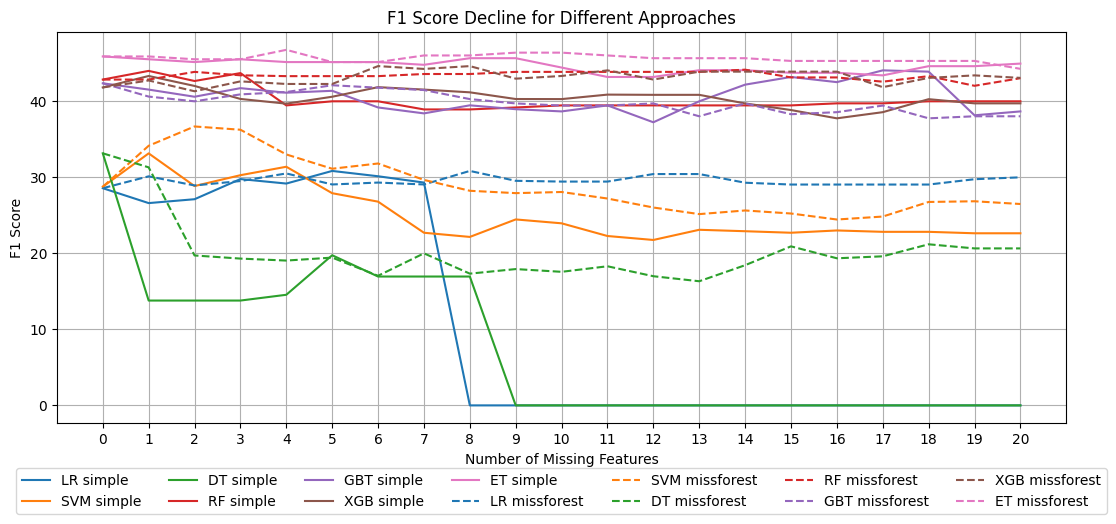

In [ ]:
# # Line plot for the f1 score of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr_perf['num_feat_missing'], lr_perf['f1_score'], label='LR simple', color=colors[0])
plt.plot(svm_perf['num_feat_missing'], svm_perf['f1_score'], label='SVM simple', color=colors[1])
plt.plot(dt_perf['num_feat_missing'], dt_perf['f1_score'], label='DT simple', color=colors[2])
plt.plot(rf_perf['num_feat_missing'], rf_perf['f1_score'], label='RF simple', color=colors[3])
plt.plot(gbt_perf['num_feat_missing'], gbt_perf['f1_score'], label='GBT simple', color=colors[4])
plt.plot(xgb_perf['num_feat_missing'], xgb_perf['f1_score'], label='XGB simple', color=colors[5])
plt.plot(et_perf['num_feat_missing'], et_perf['f1_score'], label='ET simple', color=colors[6])

plt.plot(lr_perf_mf['num_feat_missing'], lr_perf_mf['f1_score'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm_perf_mf['num_feat_missing'], svm_perf_mf['f1_score'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt_perf_mf['num_feat_missing'], dt_perf_mf['f1_score'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf_perf_mf['num_feat_missing'], rf_perf_mf['f1_score'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt_perf_mf['num_feat_missing'], gbt_perf_mf['f1_score'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb_perf_mf['num_feat_missing'], xgb_perf_mf['f1_score'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et_perf_mf['num_feat_missing'], et_perf_mf['f1_score'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score')
plt.title('F1 Score Decline for Different Approaches')
plt.xticks(et_perf.index.astype(int))
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

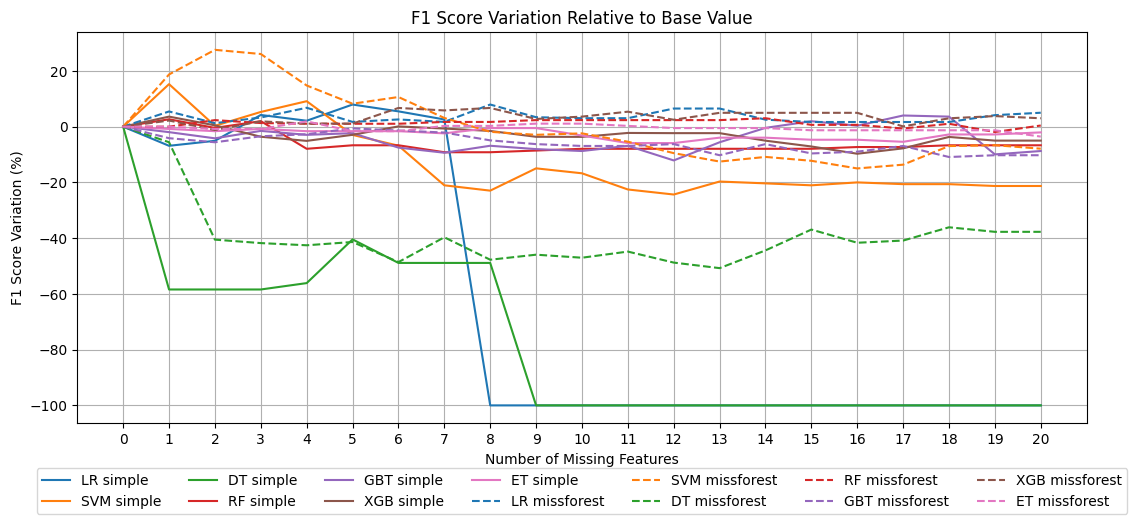

In [ ]:
# # Line plot for the f1 score variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the F1-score variation for each model
for perf_df, label, color, linestyle in zip(
    [lr_perf, svm_perf, dt_perf, rf_perf, gbt_perf, xgb_perf, et_perf,
     lr_perf_mf, svm_perf_mf, dt_perf_mf, rf_perf_mf, gbt_perf_mf, xgb_perf_mf, et_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base F1-score
    f1_variation = (perf_df['f1_score'] - perf_df['f1_score'].iloc[0]) / perf_df['f1_score'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], f1_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('F1 Score Variation (%)')
plt.title('F1 Score Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##**Balanced Accuracy**

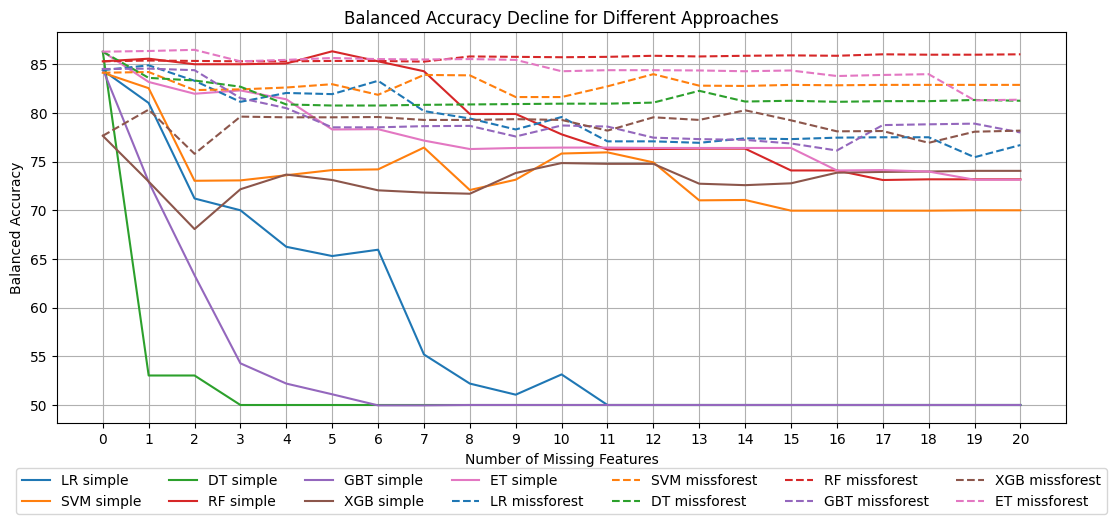

In [ ]:
# # Line plot for the balanced accuracy of the different models
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

plt.plot(lr2_perf['num_feat_missing'], lr2_perf['balanced_accuracy'], label='LR simple', color=colors[0])
plt.plot(svm2_perf['num_feat_missing'], svm2_perf['balanced_accuracy'], label='SVM simple', color=colors[1])
plt.plot(dt2_perf['num_feat_missing'], dt2_perf['balanced_accuracy'], label='DT simple', color=colors[2])
plt.plot(rf2_perf['num_feat_missing'], rf2_perf['balanced_accuracy'], label='RF simple', color=colors[3])
plt.plot(gbt2_perf['num_feat_missing'], gbt2_perf['balanced_accuracy'], label='GBT simple', color=colors[4])
plt.plot(xgb2_perf['num_feat_missing'], xgb2_perf['balanced_accuracy'], label='XGB simple', color=colors[5])
plt.plot(et2_perf['num_feat_missing'], et2_perf['balanced_accuracy'], label='ET simple', color=colors[6])

plt.plot(lr2_perf_mf['num_feat_missing'], lr2_perf_mf['balanced_accuracy'], label='LR missforest', color=colors[0], linestyle='--')
plt.plot(svm2_perf_mf['num_feat_missing'], svm2_perf_mf['balanced_accuracy'], label='SVM missforest', color=colors[1], linestyle='--')
plt.plot(dt2_perf_mf['num_feat_missing'], dt2_perf_mf['balanced_accuracy'], label='DT missforest', color=colors[2], linestyle='--')
plt.plot(rf2_perf_mf['num_feat_missing'], rf2_perf_mf['balanced_accuracy'], label='RF missforest', color=colors[3], linestyle='--')
plt.plot(gbt2_perf_mf['num_feat_missing'], gbt2_perf_mf['balanced_accuracy'], label='GBT missforest', color=colors[4], linestyle='--')
plt.plot(xgb2_perf_mf['num_feat_missing'], xgb2_perf_mf['balanced_accuracy'], label='XGB missforest', color=colors[5], linestyle='--')
plt.plot(et2_perf_mf['num_feat_missing'], et2_perf_mf['balanced_accuracy'], label='ET missforest', color=colors[6], linestyle='--')

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Decline for Different Approaches')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

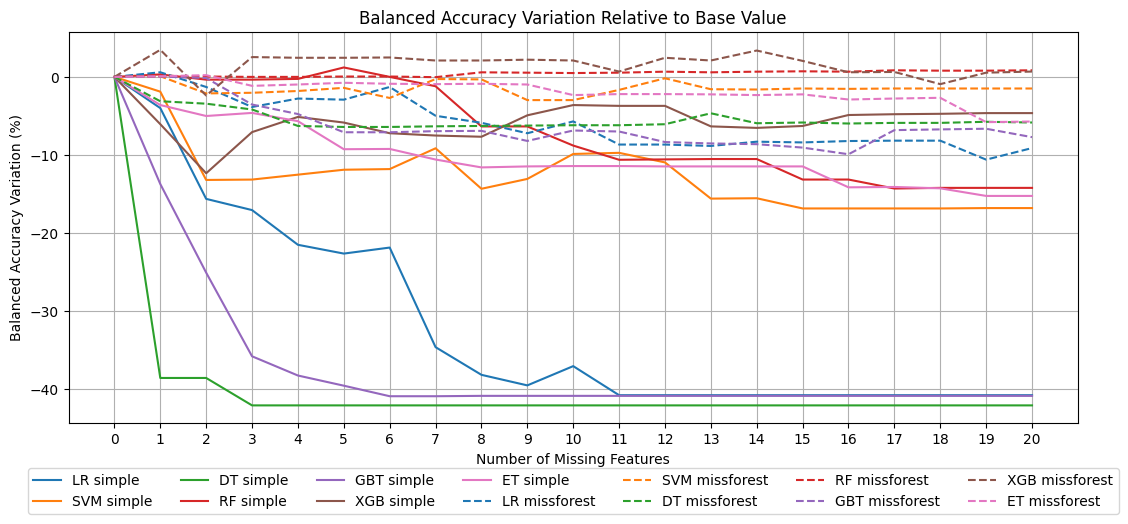

In [ ]:
# # Line plot for the balanced accuracy variation relative to the first value
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
          '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '-', '-', '-', '-', '-', '-', '--', '--', '--', '--', '--', '--', '--']

# Calculate and plot the Balanced Accuracy variation for each model
for perf_df, label, color, linestyle in zip(
    [lr2_perf, svm2_perf, dt2_perf, rf2_perf, gbt2_perf, xgb2_perf, et2_perf,
     lr2_perf_mf, svm2_perf_mf, dt2_perf_mf, rf2_perf_mf, gbt2_perf_mf, xgb2_perf_mf, et2_perf_mf],
    ['LR simple', 'SVM simple', 'DT simple', 'RF simple', 'GBT simple', 'XGB simple', 'ET simple',
     'LR missforest', 'SVM missforest', 'DT missforest', 'RF missforest', 'GBT missforest', 'XGB missforest', 'ET missforest'],
    colors,
    linestyles
):
    # Calculate the variation relative to the base Balanced Accuracy
    balanced_accy_variation = (perf_df['balanced_accuracy'] - perf_df['balanced_accuracy'].iloc[0]) / perf_df['balanced_accuracy'].iloc[0] * 100
    plt.plot(perf_df['num_feat_missing'], balanced_accy_variation, label=label, color=color, linestyle=linestyle)

plt.xlabel('Number of Missing Features')
plt.ylabel('Balanced Accuracy Variation (%)')
plt.title('Balanced Accuracy Variation Relative to Base Value')
plt.xticks(range(0, 21))
plt.legend(loc='lower center',  bbox_to_anchor=(0.5, -0.25), ncol=7)
plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Save results**

In [ ]:
dataset_dict = {
    'lr_perf': lr_perf,
    'svm_perf': svm_perf,
    'dt_perf': dt_perf,
    'rf_perf': rf_perf,
    'gbt_perf': gbt_perf,
    'xgb_perf': xgb_perf,
    'et_perf': et_perf,
    'lr_perf_mf': lr_perf_mf,
    'svm_perf_mf': svm_perf_mf,
    'dt_perf_mf': dt_perf_mf,
    'rf_perf_mf': rf_perf_mf,
    'gbt_perf_mf': gbt_perf_mf,
    'xgb_perf_mf': xgb_perf_mf,
    'et_perf_mf': et_perf_mf,
    'lr2_perf': lr2_perf,
    'svm2_perf': svm2_perf,
    'dt2_perf': dt2_perf,
    'rf2_perf': rf2_perf,
    'gbt2_perf': gbt2_perf,
    'xgb2_perf': xgb2_perf,
    'et2_perf': et2_perf,
    'lr2_perf_mf': lr2_perf_mf,
    'svm2_perf_mf': svm2_perf_mf,
    'dt2_perf_mf': dt2_perf_mf,
    'rf2_perf_mf': rf2_perf_mf,
    'gbt2_perf_mf': gbt2_perf_mf,
    'xgb2_perf_mf': xgb2_perf_mf,
    'et2_perf_mf': et2_perf_mf,
}

all_data = combine_datasets(
    dataset_dict,
    'Taiwanese Bankruptcy',  'Scenario 1: standard',
    RANDOM_STATE
)
save_dataset(all_data, 'taiwanese_bankruptcy_scenario1_seed_2025.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
all_data

tp    tn   fp  fn  precision  recall  specificity  accuracy  f1_score  \
0    36  1148  172   8      17.31   81.82        86.97     86.80     28.57   
1    33  1149  171  11      16.18   75.00        87.05     86.66     26.61   
2    32  1160  160  12      16.67   72.73        87.88     87.39     27.12   
3    32  1181  139  12      18.71   72.73        89.47     88.93     29.77   
4    34  1165  155  10      17.99   77.27        88.26     87.90     29.18   
..   ..   ...  ...  ..        ...     ...          ...       ...       ...   
583  35  1162  158   9      18.13   79.55        88.03     87.76     29.54   
584  35  1165  155   9      18.42   79.55        88.26     87.98     29.91   
585  35  1167  153   9      18.62   79.55        88.41     88.12     30.17   
586  32  1186  134  12      19.28   72.73        89.85     89.30     30.48   
587  32  1188  132  12      19.51   72.73        90.00     89.44     30.77   

     balanced_accuracy  num_feat_missing  \
0                84.39                 0   
1                81.02                 1   
2                80.30                 2   
3                81.10                 3   
4                82.77                 4   
..                 ...               ...   
583              83.79                16   
584              83.90                17   
585              83.98                18   
586              81.29                19   
587              81.36                20   

                                               imputed      dataset  \
0                                                           lr_perf   
1                      ['Equity to Liability'] imputed      lr_perf   
2    ['Equity to Liability', 'Total expense/Assets'...      lr_perf   
3    ['Equity to Liability', 'Total expense/Assets'...      lr_perf   
4    ['Equity to Liability', 'Total expense/Assets'...      lr_perf   
..                                                 ...          ...   
583  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  et2_perf_mf   
584  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  et2_perf_mf   
585  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  et2_perf_mf   
586  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  et2_perf_mf   
587  ['Debt ratio %', 'Cash/Total Assets', 'Borrowi...  et2_perf_mf   

                   source              scenario  random_state  \
0    Taiwanese Bankruptcy  Scenario 1: standard          2025   
1    Taiwanese Bankruptcy  Scenario 1: standard          2025   
2    Taiwanese Bankruptcy  Scenario 1: standard          2025   
3    Taiwanese Bankruptcy  Scenario 1: standard          2025   
4    Taiwanese Bankruptcy  Scenario 1: standard          2025   
..                    ...                   ...           ...   
583  Taiwanese Bankruptcy  Scenario 1: standard          2025   
584  Taiwanese Bankruptcy  Scenario 1: standard          2025   
585  Taiwanese Bankruptcy  Scenario 1: standard          2025   
586  Taiwanese Bankruptcy  Scenario 1: standard          2025   
587  Taiwanese Bankruptcy  Scenario 1: standard          2025   

                metric  
0             f1 score  
1             f1 score  
2             f1 score  
3             f1 score  
4             f1 score  
..                 ...  
583  balanced accuracy  
584  balanced accuracy  
585  balanced accuracy  
586  balanced accuracy  
587  balanced accuracy  

[588 rows x 17 columns]